## Controle Quântico Ótimo - Utilização do CG para ajuste do caminho percorrido por uma partícula

Nessa etapa, é necessário avaliar, a partir da equação de Heisenberg, com o método de Runge-Kutta e com o controle MPC, como a curva de origem ajusta-se a curva de destino. Além disso, é interessantíssimo a avaliação a partir do estado estacionário e ainda verificar como ocorre o ajuste de fases.

Para analisar como o controle melhora o condicionamento da curva através da sua análise futura, esse arquivo estará analisando os ajustes no horizonte 3 ao 10.

Nesse projeto usa-se o gradiente devido a sua facilidade de reprodução, vide os projetos fora da biblioteca do python, além dos problemas do cálculo da Hessiana na otimização não linear utilizando o método de Newton e suas variantes.

In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

import random

Abaixo se dão os requisitos básicos para a instauração do teste. Se tem formas de subtrair e somar matrizes, a manipulação das derivadas com o Runge-Kutta além da própria proposta da função objetivo.

In [2]:
# Manipulação das matrizes

def somar(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] + B[i][j]

    return C

def sub(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] - B[i][j]

    return C


#################################################################

## d (psi) / dt = -i * H * |psi>
def dpsidt(t, psi, H): # A derivada da onda em relação ao tempo não tem dependência temporal
    A = np.zeros((2,2), dtype=np.complex_)
    A = np.dot(complex(0,1),H) # i * H
    return -1*np.matmul(A,psi) # - i * H * |psi>

# Runge-Kutta de quarta ordem

def rungeKutta(onda, fatorRungeKutta, hamiltoniano, tempoFinal = 2, tempoInicial = 0):
    
    resultado = np.zeros((2,int(100*tempoFinal)), dtype=np.complex_)
    indice = 0

    for i in range(0, 2):
        
        resultado[0][indice] = onda[0][0]
        resultado[1][indice] = onda[1][0]
        
        k1 = dpsidt(tempoInicial, onda, hamiltoniano)
        k2 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k1)), hamiltoniano)
        k3 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k2)), hamiltoniano)
        k4 = dpsidt(tempoInicial + fatorRungeKutta, somar(onda, np.dot(fatorRungeKutta, k3)), hamiltoniano)
        
        ## y(i+1) = y(i) + h/6*(k1+2*k2+2*k3+k4)
        
        A = somar(np.dot(2,k3), k4)
        B = somar(np.dot(2,k2), k1)
        C = somar(A, B)
 
        onda = somar(onda,np.dot((fatorRungeKutta / 6.0),(C)))
    
        tempoInicial += fatorRungeKutta
        
        indice += 1
        
    runge = np.zeros((2,1), dtype=np.complex_)
    runge[0][0] = resultado[0][indice-1]
    runge[1][0] = resultado[1][indice-1]
    return runge

def funcaoObjetivo(x, iteracao, ondaDestino, hamiltoniano, onda, horizonteAnalisavel, fatorRungeKutta, tempoAnalise):
    
    avanco = np.zeros((2,1),dtype=np.complex_)
    
    y = 0
    
    horizonte = (horizonteAnalisavel+iteracao)/100
    
    tempo = iteracao/100
    
    tempoInicialAnalise = 0.00
    tempoFinalAnalise = 0.02
    
    controles = np.zeros((2,2), dtype=np.complex_)
    controles = [[0, x[0]], [x[0], 0]]
    
    matrizOrigem = np.zeros((2,1),dtype=np.complex_)
    matrizOrigem = [[onda[0][0]], [onda[1][0]]] 

    matrizDestino = np.zeros((2,1),dtype=np.complex_)
    
    ## Função-Objetivo (Return) = somatorio ||(Matriz_Origem - Matriz_Destino)||^2
    
    ## Avanço temporal
    
    matrizDestino[0][0] = ondaDestino[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
    matrizDestino[1][0] = ondaDestino[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)

    y += (np.linalg.norm(matrizOrigem-matrizDestino))**2

    avanco = rungeKutta(matrizOrigem, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

    matrizOrigem = avanco

    tempoInicialAnalise += 0.01
    tempoFinalAnalise += 0.01
    
    for indice in range((iteracao+1), (horizonteAnalisavel+iteracao)):
        tempo = indice/100
        
        matrizDestino[0][0] = ondaDestino[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
        matrizDestino[1][0] = ondaDestino[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)
        
        y += (np.linalg.norm(matrizOrigem-matrizDestino))**2
        
        controles = [[0, x[int(tempoInicialAnalise*100)]], [x[int(tempoInicialAnalise*100)], 0]]

        avanco = rungeKutta(matrizOrigem, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

        matrizOrigem = avanco

        tempoInicialAnalise += 0.01
        tempoFinalAnalise += 0.01
    
    return y

Para o funcionamento do MPC, cria-se um looping que consiste em uma otimização não linear, com o apoio da biblioteca de otimização do pyhton, de forma a obter o melhor resultado para o ajuste da curva. Com esse valor em mãos, utiliza-se para os pontos da próxima iteração do método de controle além de efetivar o ajuste realizando o Runge-Kutta com o valor otimizado.

In [3]:
## Constantes

horizonte = 3
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos3 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes3 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda3 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo3 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda3[0][iteracao] = ondaOrigem[0][0]
    valoresOnda3[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes3[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes3[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos3[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo3[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo3[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-0.26026203  0.94365437  0.08310312]
 Conferindo: (0.06025339720105624+0j)
Iteração: 2
Mínimo: [0.45506772 0.9653929  0.08310312]
 Conferindo: (0.06014602637046508+0j)
Iteração: 3
Mínimo: [0.45506772 0.9653929  0.08310312]
 Conferindo: (0.05995818614705538+0j)
Iteração: 4
Mínimo: [0.44432624 0.95012322 0.08310312]
 Conferindo: (0.059772413843756894+0j)
Iteração: 5
Mínimo: [0.44432624 0.95012322 0.08310312]
 Conferindo: (0.05958826988776131+0j)
Iteração: 6
Mínimo: [0.44432624 0.95012322 0.08310312]
 Conferindo: (0.059403868946606014+0j)
Iteração: 7
Mínimo: [0.44432624 0.95012322 0.08310312]
 Conferindo: (0.05921940674037471+0j)
Iteração: 8
Mínimo: [0.44432624 0.95012322 0.08310312]
 Conferindo: (0.059035081367343846+0j)
Iteração: 9
Mínimo: [0.44432624 0.95012322 0.08310312]
 Conferindo: (0.058851093100734164+0j)
Iteração: 10
Mínimo: [0.44432624 0.95012322 0.08310312]
 Conferindo: (0.05866764418323041+0j)
Iteração: 11
Mínimo: [0.44432624 0.95012322 0.08310312]
 Confe

Mínimo: [0.35421181 0.74017975 0.08310312]
 Conferindo: (0.04558546810224081+0j)
Iteração: 99
Mínimo: [0.35421181 0.74017975 0.08310312]
 Conferindo: (0.04547244501648265+0j)
Iteração: 100
Mínimo: [0.35421181 0.74017975 0.08310312]
 Conferindo: (0.045359551918411914+0j)
Iteração: 101
Mínimo: [0.35421181 0.74017975 0.08310312]
 Conferindo: (0.04524702233729458+0j)
Iteração: 102
Mínimo: [0.35421181 0.74017975 0.08310312]
 Conferindo: (0.04513509037176443+0j)
Iteração: 103
Mínimo: [0.35421181 0.74017975 0.08310312]
 Conferindo: (0.04502399045294056+0j)
Iteração: 104
Mínimo: [0.35421181 0.74017975 0.08310312]
 Conferindo: (0.044913957107208205+0j)
Iteração: 105
Mínimo: [0.33830268 0.72611776 0.08310312]
 Conferindo: (0.044805008831552987+0j)
Iteração: 106
Mínimo: [0.33830268 0.72611776 0.08310312]
 Conferindo: (0.04469661781005908+0j)
Iteração: 107
Mínimo: [0.33830268 0.72611776 0.08310312]
 Conferindo: (0.04458671239916079+0j)
Iteração: 108
Mínimo: [0.33830268 0.72611776 0.08310312]
 Conf

Mínimo: [0.25447485 0.57039975 0.08310312]
 Conferindo: (0.03770428353200275+0j)
Iteração: 187
Mínimo: [0.25447485 0.57039975 0.08310312]
 Conferindo: (0.03764121249839224+0j)
Iteração: 188
Mínimo: [0.25447485 0.57039975 0.08310312]
 Conferindo: (0.037577889465901765+0j)
Iteração: 189
Mínimo: [0.25447485 0.57039975 0.08310312]
 Conferindo: (0.03751447137507552+0j)
Iteração: 190
Mínimo: [0.25447485 0.57039975 0.08310312]
 Conferindo: (0.03745111551154043+0j)
Iteração: 191
Mínimo: [0.25447485 0.57039975 0.08310312]
 Conferindo: (0.037387979348751106+0j)
Iteração: 192
Mínimo: [0.25447485 0.57039975 0.08310312]
 Conferindo: (0.03732522039054596+0j)
Iteração: 193
Mínimo: [0.25447485 0.57039975 0.08310312]
 Conferindo: (0.03726299601367357+0j)
Iteração: 194
Mínimo: [0.25447485 0.57039975 0.08310312]
 Conferindo: (0.037201463310445354+0j)
Iteração: 195
Mínimo: [0.25447485 0.57039975 0.08310312]
 Conferindo: (0.03714077893167333+0j)
Iteração: 196
Mínimo: [0.23818753 0.54361424 0.08310312]
 Con

Mínimo: [0.14604195 0.34631112 0.08310312]
 Conferindo: (0.03278477682405334+0j)
Iteração: 312
Mínimo: [0.17473822 0.34891102 0.08310312]
 Conferindo: (0.03276049822250316+0j)
Iteração: 313
Mínimo: [0.16026371 0.33467105 0.08310312]
 Conferindo: (0.032736664433990884+0j)
Iteração: 314
Mínimo: [0.16026371 0.33467105 0.08310312]
 Conferindo: (0.032715021502372064+0j)
Iteração: 315
Mínimo: [0.14431072 0.32125231 0.08310312]
 Conferindo: (0.0326943924772237+0j)
Iteração: 316
Mínimo: [0.14431072 0.32125231 0.08310312]
 Conferindo: (0.032674587700103154+0j)
Iteração: 317
Mínimo: [0.14431072 0.32125231 0.08310312]
 Conferindo: (0.03265462267452117+0j)
Iteração: 318
Mínimo: [0.14431072 0.32125231 0.08310312]
 Conferindo: (0.032634553797232416+0j)
Iteração: 319
Mínimo: [0.14431072 0.32125231 0.08310312]
 Conferindo: (0.03261443759377692+0j)
Iteração: 320
Mínimo: [0.14431072 0.32125231 0.08310312]
 Conferindo: (0.032594330662461715+0j)
Iteração: 321
Mínimo: [0.14431072 0.32125231 0.08310312]
 Co

Mínimo: [0.07582953 0.18566203 0.08310312]
 Conferindo: (0.031092702615304314+0j)
Iteração: 444
Mínimo: [0.07582953 0.18566203 0.08310312]
 Conferindo: (0.031086774848877338+0j)
Iteração: 445
Mínimo: [0.07582953 0.18566203 0.08310312]
 Conferindo: (0.031080657134844543+0j)
Iteração: 446
Mínimo: [0.07582953 0.18566203 0.08310312]
 Conferindo: (0.03107436618386737+0j)
Iteração: 447
Mínimo: [0.07582953 0.18566203 0.08310312]
 Conferindo: (0.03106791887974341+0j)
Iteração: 448
Mínimo: [0.07582953 0.18566203 0.08310312]
 Conferindo: (0.03106133226272612+0j)
Iteração: 449
Mínimo: [0.07582953 0.18566203 0.08310312]
 Conferindo: (0.031054623512687493+0j)
Iteração: 450
Mínimo: [0.07582953 0.18566203 0.08310312]
 Conferindo: (0.031047809932143556+0j)
Iteração: 451
Mínimo: [0.07582953 0.18566203 0.08310312]
 Conferindo: (0.03104090892915825+0j)
Iteração: 452
Mínimo: [0.07582953 0.18566203 0.08310312]
 Conferindo: (0.03103393800014357+0j)
Iteração: 453
Mínimo: [0.07582953 0.18566203 0.08310312]
 C

Mínimo: [0.03784443 0.11664145 0.08310312]
 Conferindo: (0.030657024021889745+0j)
Iteração: 546
Mínimo: [0.03784443 0.11664145 0.08310312]
 Conferindo: (0.030655004574866203+0j)
Iteração: 547
Mínimo: [0.03784443 0.11664145 0.08310312]
 Conferindo: (0.03065273875567307+0j)
Iteração: 548
Mínimo: [0.05210473 0.12111595 0.08310312]
 Conferindo: (0.03065012305713591+0j)
Iteração: 549
Mínimo: [0.05210473 0.12111595 0.08310312]
 Conferindo: (0.030647291089112377+0j)
Iteração: 550
Mínimo: [0.05210473 0.12111595 0.08310312]
 Conferindo: (0.030644584753302753+0j)
Iteração: 551
Mínimo: [0.05210473 0.12111595 0.08310312]
 Conferindo: (0.030642011826713694+0j)
Iteração: 552
Mínimo: [0.05210473 0.12111595 0.08310312]
 Conferindo: (0.030639579955061454+0j)
Iteração: 553
Mínimo: [0.05210473 0.12111595 0.08310312]
 Conferindo: (0.03063729664522219+0j)
Iteração: 554
Mínimo: [0.05210473 0.12111595 0.08310312]
 Conferindo: (0.030635169257819405+0j)
Iteração: 555
Mínimo: [0.05210473 0.12111595 0.08310312]


Mínimo: [0.02947321 0.07020885 0.08310312]
 Conferindo: (0.030504531356822136+0j)
Iteração: 637
Mínimo: [0.02947321 0.07020885 0.08310312]
 Conferindo: (0.030503732938857567+0j)
Iteração: 638
Mínimo: [0.02947321 0.07020885 0.08310312]
 Conferindo: (0.030502904382462684+0j)
Iteração: 639
Mínimo: [0.02947321 0.07020885 0.08310312]
 Conferindo: (0.030502048145832995+0j)
Iteração: 640
Mínimo: [0.02947321 0.07020885 0.08310312]
 Conferindo: (0.030501166714532138+0j)
Iteração: 641
Mínimo: [0.02947321 0.07020885 0.08310312]
 Conferindo: (0.03050026259903868+0j)
Iteração: 642
Mínimo: [0.02947321 0.07020885 0.08310312]
 Conferindo: (0.03049933833226735+0j)
Iteração: 643
Mínimo: [0.02947321 0.07020885 0.08310312]
 Conferindo: (0.03049839646706865+0j)
Iteração: 644
Mínimo: [0.02947321 0.07020885 0.08310312]
 Conferindo: (0.030497439573709213+0j)
Iteração: 645
Mínimo: [0.02947321 0.07020885 0.08310312]
 Conferindo: (0.03049647023733487+0j)
Iteração: 646
Mínimo: [0.02947321 0.07020885 0.08310312]
 

Mínimo: [0.01042631 0.04158781 0.08310312]
 Conferindo: (0.03044274703815402+0j)
Iteração: 733
Mínimo: [0.01042631 0.04158781 0.08310312]
 Conferindo: (0.030442522925209575+0j)
Iteração: 734
Mínimo: [0.01042631 0.04158781 0.08310312]
 Conferindo: (0.030442241714385386+0j)
Iteração: 735
Mínimo: [0.01042631 0.04158781 0.08310312]
 Conferindo: (0.030441903888351534+0j)
Iteração: 736
Mínimo: [0.02573826 0.04888163 0.08310312]
 Conferindo: (0.03044137355431553+0j)
Iteração: 737
Mínimo: [0.02573826 0.04888163 0.08310312]
 Conferindo: (0.030440785009503042+0j)
Iteração: 738
Mínimo: [0.02573826 0.04888163 0.08310312]
 Conferindo: (0.03044029622655854+0j)
Iteração: 739
Mínimo: [0.02573826 0.04888163 0.08310312]
 Conferindo: (0.0304399089410425+0j)
Iteração: 740
Mínimo: [0.02573826 0.04888163 0.08310312]
 Conferindo: (0.030439624788362887+0j)
Iteração: 741
Mínimo: [0.02573826 0.04888163 0.08310312]
 Conferindo: (0.03043944530215864+0j)
Iteração: 742
Mínimo: [0.00915537 0.03906055 0.08310312]
 Co

Mínimo: [0.00308608 0.01995962 0.08310312]
 Conferindo: (0.03041422729644011+0j)
Iteração: 853
Mínimo: [0.00308608 0.01995962 0.08310312]
 Conferindo: (0.030414184475619433+0j)
Iteração: 854
Mínimo: [0.00308608 0.01995962 0.08310312]
 Conferindo: (0.030414127354206472+0j)
Iteração: 855
Mínimo: [0.00308608 0.01995962 0.08310312]
 Conferindo: (0.030414056006037648+0j)
Iteração: 856
Mínimo: [0.00308608 0.01995962 0.08310312]
 Conferindo: (0.030413970518986533+0j)
Iteração: 857
Mínimo: [0.01840153 0.02782933 0.08310312]
 Conferindo: (0.03041373069134052+0j)
Iteração: 858
Mínimo: [0.01840153 0.02782933 0.08310312]
 Conferindo: (0.030413477064522083+0j)
Iteração: 859
Mínimo: [0.01840153 0.02782933 0.08310312]
 Conferindo: (0.03041330896196375+0j)
Iteração: 860
Mínimo: [0.01840153 0.02782933 0.08310312]
 Conferindo: (0.030413227190504148+0j)
Iteração: 861
Mínimo: [0.01840153 0.02782933 0.08310312]
 Conferindo: (0.030413232471783874+0j)
Iteração: 862
Mínimo: [0.00194894 0.01864705 0.08310312]


 Conferindo: (0.03040563415065406+0j)
Iteração: 964
Mínimo: [0.00077367 0.01091146 0.08310312]
 Conferindo: (0.03040561588434116+0j)
Iteração: 965
Mínimo: [0.00077367 0.01091146 0.08310312]
 Conferindo: (0.030405595098565392+0j)
Iteração: 966
Mínimo: [0.00077367 0.01091146 0.08310312]
 Conferindo: (0.030405571814405077+0j)
Iteração: 967
Mínimo: [0.00077367 0.01091146 0.08310312]
 Conferindo: (0.03040554605540729+0j)
Iteração: 968
Mínimo: [0.01721418 0.01933702 0.08310312]
 Conferindo: (0.030405356343821584+0j)
Iteração: 969
Mínimo: [0.01721418 0.01933702 0.08310312]
 Conferindo: (0.030405187609908554+0j)
Iteração: 970
Mínimo: [0.01721418 0.01933702 0.08310312]
 Conferindo: (0.030405133156034256+0j)
Iteração: 971
Mínimo: [0.01721418 0.01933702 0.08310312]
 Conferindo: (0.030405193596764142+0j)
Iteração: 972
Mínimo: [-0.00179904  0.00882374  0.08310312]
 Conferindo: (0.030405146525054088+0j)
Iteração: 973
Mínimo: [-0.00179904  0.00882374  0.08310312]
 Conferindo: (0.03040513013361808+0j)

Mínimo: [-0.00512019  0.00371584  0.08310312]
 Conferindo: (0.030402641542600414+0j)
Iteração: 1093
Mínimo: [-0.00512019  0.00371584  0.08310312]
 Conferindo: (0.030402625030452282+0j)
Iteração: 1094
Mínimo: [-0.00512019  0.00371584  0.08310312]
 Conferindo: (0.03040263467153399+0j)
Iteração: 1095
Mínimo: [-0.00512019  0.00371584  0.08310312]
 Conferindo: (0.030402670505427318+0j)
Iteração: 1096
Mínimo: [0.00906829 0.01123881 0.08310312]
 Conferindo: (0.030402610635825236+0j)
Iteração: 1097
Mínimo: [0.00906829 0.01123881 0.08310312]
 Conferindo: (0.030402544088372688+0j)
Iteração: 1098
Mínimo: [0.00906829 0.01123881 0.08310312]
 Conferindo: (0.030402508423149347+0j)
Iteração: 1099
Mínimo: [0.00906829 0.01123881 0.08310312]
 Conferindo: (0.03040250383060021+0j)
Iteração: 1100
Mínimo: [0.00906829 0.01123881 0.08310312]
 Conferindo: (0.03040253047050738+0j)
Iteração: 1101
Mínimo: [0.00906829 0.01123881 0.08310312]
 Conferindo: (0.030402588471826242+0j)
Iteração: 1102
Mínimo: [-0.00523905 

Mínimo: [-0.003711    0.00153564  0.08310312]
 Conferindo: (0.030401858503853654+0j)
Iteração: 1212
Mínimo: [-0.003711    0.00153564  0.08310312]
 Conferindo: (0.030401844039334144+0j)
Iteração: 1213
Mínimo: [-0.003711    0.00153564  0.08310312]
 Conferindo: (0.03040184221394629+0j)
Iteração: 1214
Mínimo: [-0.003711    0.00153564  0.08310312]
 Conferindo: (0.03040185305500272+0j)
Iteração: 1215
Mínimo: [-0.003711    0.00153564  0.08310312]
 Conferindo: (0.030401876577316155+0j)
Iteração: 1216
Mínimo: [-0.003711    0.00153564  0.08310312]
 Conferindo: (0.030401912783183965+0j)
Iteração: 1217
Mínimo: [0.01046953 0.00895786 0.08310312]
 Conferindo: (0.0304018405028151+0j)
Iteração: 1218
Mínimo: [0.01046953 0.00895786 0.08310312]
 Conferindo: (0.030401778632096615+0j)
Iteração: 1219
Mínimo: [0.01046953 0.00895786 0.08310312]
 Conferindo: (0.030401770209175318+0j)
Iteração: 1220
Mínimo: [0.01046953 0.00895786 0.08310312]
 Conferindo: (0.030401815449529638+0j)
Iteração: 1221
Mínimo: [-0.0037

Mínimo: [0.00893449 0.00637372 0.08310312]
 Conferindo: (0.030401466669035027+0j)
Iteração: 1298
Mínimo: [0.00893449 0.00637372 0.08310312]
 Conferindo: (0.030401415151296348+0j)
Iteração: 1299
Mínimo: [0.00893449 0.00637372 0.08310312]
 Conferindo: (0.030401404856064088+0j)
Iteração: 1300
Mínimo: [0.00893449 0.00637372 0.08310312]
 Conferindo: (0.03040143594418527+0j)
Iteração: 1301
Mínimo: [0.00893449 0.00637372 0.08310312]
 Conferindo: (0.030401508535669166+0j)
Iteração: 1302
Mínimo: [-0.00732232 -0.00231086  0.08310312]
 Conferindo: (0.030401462157639593+0j)
Iteração: 1303
Mínimo: [-0.00732232 -0.00231086  0.08310312]
 Conferindo: (0.03040142851045846+0j)
Iteração: 1304
Mínimo: [-0.00732232 -0.00231086  0.08310312]
 Conferindo: (0.030401432080905108+0j)
Iteração: 1305
Mínimo: [-0.00732232 -0.00231086  0.08310312]
 Conferindo: (0.030401472966488974+0j)
Iteração: 1306
Mínimo: [-0.00732232 -0.00231086  0.08310312]
 Conferindo: (0.030401551227894542+0j)
Iteração: 1307
Mínimo: [0.010805

Mínimo: [-0.00775773 -0.00337618  0.08310312]
 Conferindo: (0.03040126763241742+0j)
Iteração: 1383
Mínimo: [-0.00775773 -0.00337618  0.08310312]
 Conferindo: (0.03040123010512144+0j)
Iteração: 1384
Mínimo: [-0.00775773 -0.00337618  0.08310312]
 Conferindo: (0.030401231894003008+0j)
Iteração: 1385
Mínimo: [-0.00775773 -0.00337618  0.08310312]
 Conferindo: (0.030401273110786164+0j)
Iteração: 1386
Mínimo: [-0.00775773 -0.00337618  0.08310312]
 Conferindo: (0.03040135382828154+0j)
Iteração: 1387
Mínimo: [0.01031889 0.00632986 0.08310312]
 Conferindo: (0.03040127515671162+0j)
Iteração: 1388
Mínimo: [0.01031889 0.00632986 0.08310312]
 Conferindo: (0.030401211175331413+0j)
Iteração: 1389
Mínimo: [0.01031889 0.00632986 0.08310312]
 Conferindo: (0.030401206462212803+0j)
Iteração: 1390
Mínimo: [0.01031889 0.00632986 0.08310312]
 Conferindo: (0.03040126122319254+0j)
Iteração: 1391
Mínimo: [-0.00502548 -0.00202928  0.08310312]
 Conferindo: (0.030401231369417435+0j)
Iteração: 1392
Mínimo: [-0.00502

Mínimo: [0.00806495 0.00427837 0.08310312]
 Conferindo: (0.03040109047609275+0j)
Iteração: 1498
Mínimo: [0.00806495 0.00427837 0.08310312]
 Conferindo: (0.03040104876708469+0j)
Iteração: 1499
Mínimo: [0.00806495 0.00427837 0.08310312]
 Conferindo: (0.03040104447304484+0j)
Iteração: 1500
Mínimo: [0.00806495 0.00427837 0.08310312]
 Conferindo: (0.030401077720889805+0j)
Iteração: 1501
Mínimo: [0.00806495 0.00427837 0.08310312]
 Conferindo: (0.030401148600487114+0j)
Iteração: 1502
Mínimo: [-0.00827481 -0.00440685  0.08310312]
 Conferindo: (0.03040109532787888+0j)
Iteração: 1503
Mínimo: [-0.00827481 -0.00440685  0.08310312]
 Conferindo: (0.030401052788953623+0j)
Iteração: 1504
Mínimo: [-0.00827481 -0.00440685  0.08310312]
 Conferindo: (0.03040105261602374+0j)
Iteração: 1505
Mínimo: [-0.00827481 -0.00440685  0.08310312]
 Conferindo: (0.030401094938446886+0j)
Iteração: 1506
Mínimo: [-0.00827481 -0.00440685  0.08310312]
 Conferindo: (0.030401179843640665+0j)
Iteração: 1507
Mínimo: [0.00999567 

Mínimo: [-0.00701563 -0.00320519  0.08310312]
 Conferindo: (0.030400962241325068+0j)
Iteração: 1633
Mínimo: [-0.00701563 -0.00320519  0.08310312]
 Conferindo: (0.030400930253067598+0j)
Iteração: 1634
Mínimo: [-0.00701563 -0.00320519  0.08310312]
 Conferindo: (0.0304009283499346+0j)
Iteração: 1635
Mínimo: [-0.00701563 -0.00320519  0.08310312]
 Conferindo: (0.030400956626460758+0j)
Iteração: 1636
Mínimo: [-0.00701563 -0.00320519  0.08310312]
 Conferindo: (0.030401015147399478+0j)
Iteração: 1637
Mínimo: [0.0080694  0.00483009 0.08310312]
 Conferindo: (0.03040096587456326+0j)
Iteração: 1638
Mínimo: [0.0080694  0.00483009 0.08310312]
 Conferindo: (0.030400925506627912+0j)
Iteração: 1639
Mínimo: [0.0080694  0.00483009 0.08310312]
 Conferindo: (0.03040092328452298+0j)
Iteração: 1640
Mínimo: [0.0080694  0.00483009 0.08310312]
 Conferindo: (0.030400959333295598+0j)
Iteração: 1641
Mínimo: [0.0080694  0.00483009 0.08310312]
 Conferindo: (0.030401033740231037+0j)
Iteração: 1642
Mínimo: [-0.0088058

Mínimo: [0.01005478 0.00606099 0.08310312]
 Conferindo: (0.030400930972013088+0j)
Iteração: 1718
Mínimo: [0.01005478 0.00606099 0.08310312]
 Conferindo: (0.0304008709860143+0j)
Iteração: 1719
Mínimo: [0.01005478 0.00606099 0.08310312]
 Conferindo: (0.030400870367172452+0j)
Iteração: 1720
Mínimo: [0.01005478 0.00606099 0.08310312]
 Conferindo: (0.03040092930706638+0j)
Iteração: 1721
Mínimo: [-0.00583305 -0.0026773   0.08310312]
 Conferindo: (0.030400892651990648+0j)
Iteração: 1722
Mínimo: [-0.00583305 -0.0026773   0.08310312]
 Conferindo: (0.03040086306993739+0j)
Iteração: 1723
Mínimo: [-0.00583305 -0.0026773   0.08310312]
 Conferindo: (0.030400854341237658+0j)
Iteração: 1724
Mínimo: [-0.00583305 -0.0026773   0.08310312]
 Conferindo: (0.0304008665384293+0j)
Iteração: 1725
Mínimo: [-0.00583305 -0.0026773   0.08310312]
 Conferindo: (0.030400899713396733+0j)
Iteração: 1726
Mínimo: [-0.00583305 -0.0026773   0.08310312]
 Conferindo: (0.030400953897324026+0j)
Iteração: 1727
Mínimo: [0.0088950

Mínimo: [-0.00823445 -0.00384336  0.08310312]
 Conferindo: (0.03040082437660182+0j)
Iteração: 1813
Mínimo: [-0.00823445 -0.00384336  0.08310312]
 Conferindo: (0.030400788589771358+0j)
Iteração: 1814
Mínimo: [-0.00823445 -0.00384336  0.08310312]
 Conferindo: (0.03040079391862971+0j)
Iteração: 1815
Mínimo: [-0.00823445 -0.00384336  0.08310312]
 Conferindo: (0.03040084048580769+0j)
Iteração: 1816
Mínimo: [0.00564003 0.0036634  0.08310312]
 Conferindo: (0.0304008108093462+0j)
Iteração: 1817
Mínimo: [0.00564003 0.0036634  0.08310312]
 Conferindo: (0.030400784336575393+0j)
Iteração: 1818
Mínimo: [0.00564003 0.0036634  0.08310312]
 Conferindo: (0.030400776430548927+0j)
Iteração: 1819
Mínimo: [0.00564003 0.0036634  0.08310312]
 Conferindo: (0.03040078715878951+0j)
Iteração: 1820
Mínimo: [0.00564003 0.0036634  0.08310312]
 Conferindo: (0.03040081657043269+0j)
Iteração: 1821
Mínimo: [0.00564003 0.0036634  0.08310312]
 Conferindo: (0.030400864696175096+0j)
Iteração: 1822
Mínimo: [-0.0081248  -0.0

Mínimo: [-0.0075734  -0.00455018  0.08310312]
 Conferindo: (0.030400748678618354+0j)
Iteração: 1923
Mínimo: [-0.0075734  -0.00455018  0.08310312]
 Conferindo: (0.030400703348150156+0j)
Iteração: 1924
Mínimo: [-0.0075734  -0.00455018  0.08310312]
 Conferindo: (0.030400692250552957+0j)
Iteração: 1925
Mínimo: [-0.0075734  -0.00455018  0.08310312]
 Conferindo: (0.03040071550492257+0j)
Iteração: 1926
Mínimo: [-0.0075734  -0.00455018  0.08310312]
 Conferindo: (0.030400773196454355+0j)
Iteração: 1927
Mínimo: [0.00742265 0.00357981 0.08310312]
 Conferindo: (0.03040072790809041+0j)
Iteração: 1928
Mínimo: [0.00742265 0.00357981 0.08310312]
 Conferindo: (0.030400692323478598+0j)
Iteração: 1929
Mínimo: [0.00742265 0.00357981 0.08310312]
 Conferindo: (0.030400689637394656+0j)
Iteração: 1930
Mínimo: [0.00742265 0.00357981 0.08310312]
 Conferindo: (0.030400719956289075+0j)
Iteração: 1931
Mínimo: [0.00742265 0.00357981 0.08310312]
 Conferindo: (0.030400783354031978+0j)
Iteração: 1932
Mínimo: [-0.00817

In [4]:
## Constantes

horizonte = 4
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos4 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes4 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda4 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo4 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda4[0][iteracao] = ondaOrigem[0][0]
    valoresOnda4[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes4[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes4[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos4[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo4[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo4[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-0.62800662  0.80183212  0.95519625  0.40644626]
 Conferindo: (0.08023060197694179+0j)
Iteração: 2
Mínimo: [0.358518   0.97420346 0.86973355 0.40644626]
 Conferindo: (0.08001160217050349+0j)
Iteração: 3
Mínimo: [0.46334905 0.95259483 0.86342119 0.40644626]
 Conferindo: (0.0796231090263576+0j)
Iteração: 4
Mínimo: [0.45438717 0.93901769 0.85926054 0.40644626]
 Conferindo: (0.07921336045163346+0j)
Iteração: 5
Mínimo: [0.45438717 0.93901769 0.85926054 0.40644626]
 Conferindo: (0.07881004916115275+0j)
Iteração: 6
Mínimo: [0.44512387 0.9267767  0.85560956 0.40644626]
 Conferindo: (0.0784110018737959+0j)
Iteração: 7
Mínimo: [0.44512387 0.9267767  0.85560956 0.40644626]
 Conferindo: (0.078015938938562+0j)
Iteração: 8
Mínimo: [0.44512387 0.9267767  0.85560956 0.40644626]
 Conferindo: (0.07762273826951685+0j)
Iteração: 9
Mínimo: [0.44512387 0.9267767  0.85560956 0.40644626]
 Conferindo: (0.0772318150144892+0j)
Iteração: 10
Mínimo: [0.43633764 0.91484227 0.85150825 0.40644626

Mínimo: [0.34414953 0.71433493 0.71160531 0.40644626]
 Conferindo: (0.05369797202671036+0j)
Iteração: 84
Mínimo: [0.34414953 0.71433493 0.71160531 0.40644626]
 Conferindo: (0.05345381818763896+0j)
Iteração: 85
Mínimo: [0.34414953 0.71433493 0.71160531 0.40644626]
 Conferindo: (0.05321096830537275+0j)
Iteração: 86
Mínimo: [0.34414953 0.71433493 0.71160531 0.40644626]
 Conferindo: (0.05296978792056267+0j)
Iteração: 87
Mínimo: [0.34414953 0.71433493 0.71160531 0.40644626]
 Conferindo: (0.05273064200133399+0j)
Iteração: 88
Mínimo: [0.33757434 0.69923523 0.6985645  0.40644626]
 Conferindo: (0.05249372406976484+0j)
Iteração: 89
Mínimo: [0.33757434 0.69923523 0.6985645  0.40644626]
 Conferindo: (0.05225925700695441+0j)
Iteração: 90
Mínimo: [0.33757434 0.69923523 0.6985645  0.40644626]
 Conferindo: (0.052026090485069745+0j)
Iteração: 91
Mínimo: [0.33757434 0.69923523 0.6985645  0.40644626]
 Conferindo: (0.05179458076252743+0j)
Iteração: 92
Mínimo: [0.33757434 0.69923523 0.6985645  0.40644626]


Mínimo: [0.24282772 0.50607866 0.52269866 0.40644626]
 Conferindo: (0.03867229779093834+0j)
Iteração: 169
Mínimo: [0.24282772 0.50607866 0.52269866 0.40644626]
 Conferindo: (0.038552461514241895+0j)
Iteração: 170
Mínimo: [0.23459198 0.49028709 0.50791348 0.40644626]
 Conferindo: (0.03843400314033642+0j)
Iteração: 171
Mínimo: [0.23459198 0.49028709 0.50791348 0.40644626]
 Conferindo: (0.03831714779510313+0j)
Iteração: 172
Mínimo: [0.23459198 0.49028709 0.50791348 0.40644626]
 Conferindo: (0.03820069734692344+0j)
Iteração: 173
Mínimo: [0.23459198 0.49028709 0.50791348 0.40644626]
 Conferindo: (0.03808485581902492+0j)
Iteração: 174
Mínimo: [0.23459198 0.49028709 0.50791348 0.40644626]
 Conferindo: (0.03796982686814291+0j)
Iteração: 175
Mínimo: [0.23459198 0.49028709 0.50791348 0.40644626]
 Conferindo: (0.03785581358129884+0j)
Iteração: 176
Mínimo: [0.23459198 0.49028709 0.50791348 0.40644626]
 Conferindo: (0.03774301827314749+0j)
Iteração: 177
Mínimo: [0.22843148 0.47507017 0.49278109 0.4

Mínimo: [0.15047408 0.31957202 0.34156264 0.40644626]
 Conferindo: (0.03126002812009748+0j)
Iteração: 261
Mínimo: [0.15047408 0.31957202 0.34156264 0.40644626]
 Conferindo: (0.03121020576748428+0j)
Iteração: 262
Mínimo: [0.15047408 0.31957202 0.34156264 0.40644626]
 Conferindo: (0.031160517472734826+0j)
Iteração: 263
Mínimo: [0.15047408 0.31957202 0.34156264 0.40644626]
 Conferindo: (0.03111105468263621+0j)
Iteração: 264
Mínimo: [0.15047408 0.31957202 0.34156264 0.40644626]
 Conferindo: (0.03106190866124896+0j)
Iteração: 265
Mínimo: [0.15047408 0.31957202 0.34156264 0.40644626]
 Conferindo: (0.03101317039942587+0j)
Iteração: 266
Mínimo: [0.15047408 0.31957202 0.34156264 0.40644626]
 Conferindo: (0.030964930524603234+0j)
Iteração: 267
Mínimo: [0.15047408 0.31957202 0.34156264 0.40644626]
 Conferindo: (0.030917279210952327+0j)
Iteração: 268
Mínimo: [0.15047408 0.31957202 0.34156264 0.40644626]
 Conferindo: (0.030870306089978775+0j)
Iteração: 269
Mínimo: [0.14379237 0.30525367 0.32728956 

Mínimo: [0.0961282  0.2098872  0.23291571 0.40644626]
 Conferindo: (0.028419094380710927+0j)
Iteração: 343
Mínimo: [0.0961282  0.2098872  0.23291571 0.40644626]
 Conferindo: (0.0283975462573057+0j)
Iteração: 344
Mínimo: [0.0961282  0.2098872  0.23291571 0.40644626]
 Conferindo: (0.028375913999278454+0j)
Iteração: 345
Mínimo: [0.0961282  0.2098872  0.23291571 0.40644626]
 Conferindo: (0.02835423715109446+0j)
Iteração: 346
Mínimo: [0.10983615 0.21240301 0.22857977 0.40644626]
 Conferindo: (0.028332458290683205+0j)
Iteração: 347
Mínimo: [0.10983615 0.21240301 0.22857977 0.40644626]
 Conferindo: (0.028311008832579095+0j)
Iteração: 348
Mínimo: [0.09475475 0.19688159 0.21684209 0.40644626]
 Conferindo: (0.028290542398360118+0j)
Iteração: 349
Mínimo: [0.09475475 0.19688159 0.21684209 0.40644626]
 Conferindo: (0.028271156431078984+0j)
Iteração: 350
Mínimo: [0.09475475 0.19688159 0.21684209 0.40644626]
 Conferindo: (0.028251810256058957+0j)
Iteração: 351
Mínimo: [0.09475475 0.19688159 0.2168420

Mínimo: [0.06082545 0.12980758 0.14282576 0.40644626]
 Conferindo: (0.027281751515969486+0j)
Iteração: 423
Mínimo: [0.07323437 0.13716381 0.14505091 0.40644626]
 Conferindo: (0.027272430549480985+0j)
Iteração: 424
Mínimo: [0.07323437 0.13716381 0.14505091 0.40644626]
 Conferindo: (0.02726312277968512+0j)
Iteração: 425
Mínimo: [0.07323437 0.13716381 0.14505091 0.40644626]
 Conferindo: (0.02725435614782512+0j)
Iteração: 426
Mínimo: [0.05852996 0.12494808 0.13712638 0.40644626]
 Conferindo: (0.027245935026531363+0j)
Iteração: 427
Mínimo: [0.05852996 0.12494808 0.13712638 0.40644626]
 Conferindo: (0.027237946248310923+0j)
Iteração: 428
Mínimo: [0.05852996 0.12494808 0.13712638 0.40644626]
 Conferindo: (0.027229750722661573+0j)
Iteração: 429
Mínimo: [0.05852996 0.12494808 0.13712638 0.40644626]
 Conferindo: (0.02722136342506616+0j)
Iteração: 430
Mínimo: [0.07069481 0.13225815 0.13945319 0.40644626]
 Conferindo: (0.027212699419550308+0j)
Iteração: 431
Mínimo: [0.07069481 0.13225815 0.1394531

Mínimo: [0.03540501 0.07895339 0.08598886 0.40644626]
 Conferindo: (0.026756931377595897+0j)
Iteração: 513
Mínimo: [0.03540501 0.07895339 0.08598886 0.40644626]
 Conferindo: (0.02675375823496483+0j)
Iteração: 514
Mínimo: [0.03540501 0.07895339 0.08598886 0.40644626]
 Conferindo: (0.026750445511918616+0j)
Iteração: 515
Mínimo: [0.03540501 0.07895339 0.08598886 0.40644626]
 Conferindo: (0.0267469990195046+0j)
Iteração: 516
Mínimo: [0.04800968 0.08713778 0.0894375  0.40644626]
 Conferindo: (0.026743308211853827+0j)
Iteração: 517
Mínimo: [0.04800968 0.08713778 0.0894375  0.40644626]
 Conferindo: (0.026739622948762306+0j)
Iteração: 518
Mínimo: [0.04800968 0.08713778 0.0894375  0.40644626]
 Conferindo: (0.026736261706745826+0j)
Iteração: 519
Mínimo: [0.03427001 0.07619208 0.0828656  0.40644626]
 Conferindo: (0.026733055303795744+0j)
Iteração: 520
Mínimo: [0.03427001 0.07619208 0.0828656  0.40644626]
 Conferindo: (0.026730102758753052+0j)
Iteração: 521
Mínimo: [0.03427001 0.07619208 0.0828656

Mínimo: [0.0331276  0.05861275 0.05954714 0.40644626]
 Conferindo: (0.026559753977284342+0j)
Iteração: 596
Mínimo: [0.0331276  0.05861275 0.05954714 0.40644626]
 Conferindo: (0.026558093649559335+0j)
Iteração: 597
Mínimo: [0.0331276  0.05861275 0.05954714 0.40644626]
 Conferindo: (0.0265566158680801+0j)
Iteração: 598
Mínimo: [0.02182725 0.0497657  0.05436872 0.40644626]
 Conferindo: (0.026555207122765406+0j)
Iteração: 599
Mínimo: [0.02182725 0.0497657  0.05436872 0.40644626]
 Conferindo: (0.026553940944846234+0j)
Iteração: 600
Mínimo: [0.02182725 0.0497657  0.05436872 0.40644626]
 Conferindo: (0.026552605773698727+0j)
Iteração: 601
Mínimo: [0.02182725 0.0497657  0.05436872 0.40644626]
 Conferindo: (0.026551203896170075+0j)
Iteração: 602
Mínimo: [0.02182725 0.0497657  0.05436872 0.40644626]
 Conferindo: (0.026549737664967224+0j)
Iteração: 603
Mínimo: [0.03389236 0.05775118 0.05798622 0.40644626]
 Conferindo: (0.026548098969187216+0j)
Iteração: 604
Mínimo: [0.03389236 0.05775118 0.057986

Mínimo: [0.02460144 0.04037592 0.04013368 0.40644626]
 Conferindo: (0.026477853064357328+0j)
Iteração: 676
Mínimo: [0.02460144 0.04037592 0.04013368 0.40644626]
 Conferindo: (0.02647707878131768+0j)
Iteração: 677
Mínimo: [0.02460144 0.04037592 0.04013368 0.40644626]
 Conferindo: (0.02647644872147826+0j)
Iteração: 678
Mínimo: [0.01230841 0.03100999 0.03485818 0.40644626]
 Conferindo: (0.026475830423503263+0j)
Iteração: 679
Mínimo: [0.01230841 0.03100999 0.03485818 0.40644626]
 Conferindo: (0.02647532767808223+0j)
Iteração: 680
Mínimo: [0.01230841 0.03100999 0.03485818 0.40644626]
 Conferindo: (0.026474779295279915+0j)
Iteração: 681
Mínimo: [0.01230841 0.03100999 0.03485818 0.40644626]
 Conferindo: (0.026474186124491747+0j)
Iteração: 682
Mínimo: [0.0234354  0.03871981 0.03857687 0.40644626]
 Conferindo: (0.026473450535078+0j)
Iteração: 683
Mínimo: [0.0234354  0.03871981 0.03857687 0.40644626]
 Conferindo: (0.026472734909833442+0j)
Iteração: 684
Mínimo: [0.0234354  0.03871981 0.03857687 0

 Conferindo: (0.02644061926193829+0j)
Iteração: 762
Mínimo: [0.01897442 0.02779913 0.02659961 0.40644626]
 Conferindo: (0.02644021432001486+0j)
Iteração: 763
Mínimo: [0.01897442 0.02779913 0.02659961 0.40644626]
 Conferindo: (0.026439859751833314+0j)
Iteração: 764
Mínimo: [0.01897442 0.02779913 0.02659961 0.40644626]
 Conferindo: (0.026439627132179958+0j)
Iteração: 765
Mínimo: [0.00533659 0.01758442 0.02099467 0.40644626]
 Conferindo: (0.02643935586071264+0j)
Iteração: 766
Mínimo: [0.00533659 0.01758442 0.02099467 0.40644626]
 Conferindo: (0.026439187674278757+0j)
Iteração: 767
Mínimo: [0.00533659 0.01758442 0.02099467 0.40644626]
 Conferindo: (0.02643899662945881+0j)
Iteração: 768
Mínimo: [0.00533659 0.01758442 0.02099467 0.40644626]
 Conferindo: (0.026438782972253466+0j)
Iteração: 769
Mínimo: [0.01801593 0.0265628  0.02550557 0.40644626]
 Conferindo: (0.026438415777926855+0j)
Iteração: 770
Mínimo: [0.01801593 0.0265628  0.02550557 0.40644626]
 Conferindo: (0.026438089458821888+0j)
It

Mínimo: [0.01275989 0.01760261 0.01657833 0.40644626]
 Conferindo: (0.026424292790444365+0j)
Iteração: 856
Mínimo: [0.01275989 0.01760261 0.01657833 0.40644626]
 Conferindo: (0.026424151462323426+0j)
Iteração: 857
Mínimo: [0.01275989 0.01760261 0.01657833 0.40644626]
 Conferindo: (0.02642407212899245+0j)
Iteração: 858
Mínimo: [0.00239606 0.0098984  0.01238791 0.40644626]
 Conferindo: (0.02642396326375457+0j)
Iteração: 859
Mínimo: [0.00239606 0.0098984  0.01238791 0.40644626]
 Conferindo: (0.026423907577320577+0j)
Iteração: 860
Mínimo: [0.00239606 0.0098984  0.01238791 0.40644626]
 Conferindo: (0.026423844000920533+0j)
Iteração: 861
Mínimo: [0.00239606 0.0098984  0.01238791 0.40644626]
 Conferindo: (0.026423772608392074+0j)
Iteração: 862
Mínimo: [0.00239606 0.0098984  0.01238791 0.40644626]
 Conferindo: (0.026423693481285034+0j)
Iteração: 863
Mínimo: [0.01467009 0.01853169 0.01675296 0.40644626]
 Conferindo: (0.026423485348818648+0j)
Iteração: 864
Mínimo: [0.01467009 0.01853169 0.016752

Mínimo: [0.00994404 0.01262571 0.0112442  0.40644626]
 Conferindo: (0.026418164844467157+0j)
Iteração: 952
Mínimo: [-1.35466719e-04  5.08728777e-03  7.15200713e-03  4.06446261e-01]
 Conferindo: (0.02641810616568592+0j)
Iteração: 953
Mínimo: [-1.35466719e-04  5.08728777e-03  7.15200713e-03  4.06446261e-01]
 Conferindo: (0.02641809212422764+0j)
Iteração: 954
Mínimo: [-1.35466719e-04  5.08728777e-03  7.15200713e-03  4.06446261e-01]
 Conferindo: (0.02641807858314321+0j)
Iteração: 955
Mínimo: [-1.35466719e-04  5.08728777e-03  7.15200713e-03  4.06446261e-01]
 Conferindo: (0.026418065555226983+0j)
Iteração: 956
Mínimo: [-1.35466719e-04  5.08728777e-03  7.15200713e-03  4.06446261e-01]
 Conferindo: (0.02641805305276466+0j)
Iteração: 957
Mínimo: [0.01200721 0.01360294 0.01147641 0.40644626]
 Conferindo: (0.026417922012500955+0j)
Iteração: 958
Mínimo: [0.01200721 0.01360294 0.01147641 0.40644626]
 Conferindo: (0.026417851214536565+0j)
Iteração: 959
Mínimo: [0.01200721 0.01360294 0.01147641 0.4064

 Conferindo: (0.02641592808487586+0j)
Iteração: 1042
Mínimo: [-0.00225024  0.00103759  0.00323061  0.40644626]
 Conferindo: (0.026415945876304775+0j)
Iteração: 1043
Mínimo: [0.00871659 0.00898114 0.00736902 0.40644626]
 Conferindo: (0.02641587247796271+0j)
Iteração: 1044
Mínimo: [0.00871659 0.00898114 0.00736902 0.40644626]
 Conferindo: (0.026415842547036+0j)
Iteração: 1045
Mínimo: [0.00871659 0.00898114 0.00736902 0.40644626]
 Conferindo: (0.02641585641807655+0j)
Iteração: 1046
Mínimo: [-0.0021122   0.00103743  0.00313864  0.40644626]
 Conferindo: (0.02641581455714219+0j)
Iteração: 1047
Mínimo: [-0.0021122   0.00103743  0.00313864  0.40644626]
 Conferindo: (0.02641581499443104+0j)
Iteração: 1048
Mínimo: [-0.0021122   0.00103743  0.00313864  0.40644626]
 Conferindo: (0.02641582304512471+0j)
Iteração: 1049
Mínimo: [-0.0021122   0.00103743  0.00313864  0.40644626]
 Conferindo: (0.026415838709740687+0j)
Iteração: 1050
Mínimo: [0.00827913 0.00856482 0.00706006 0.40644626]
 Conferindo: (0.0

Mínimo: [-0.00295854 -0.00083184  0.00117634  0.40644626]
 Conferindo: (0.02641495345466312+0j)
Iteração: 1133
Mínimo: [-0.00295854 -0.00083184  0.00117634  0.40644626]
 Conferindo: (0.026414955737278135+0j)
Iteração: 1134
Mínimo: [-0.00295854 -0.00083184  0.00117634  0.40644626]
 Conferindo: (0.026414968475369074+0j)
Iteração: 1135
Mínimo: [-0.00295854 -0.00083184  0.00117634  0.40644626]
 Conferindo: (0.026414991673628322+0j)
Iteração: 1136
Mínimo: [0.00721689 0.00656451 0.00504555 0.40644626]
 Conferindo: (0.026414938323600177+0j)
Iteração: 1137
Mínimo: [0.00721689 0.00656451 0.00504555 0.40644626]
 Conferindo: (0.02641492399348711+0j)
Iteração: 1138
Mínimo: [0.00721689 0.00656451 0.00504555 0.40644626]
 Conferindo: (0.02641494303690861+0j)
Iteração: 1139
Mínimo: [0.00721689 0.00656451 0.00504555 0.40644626]
 Conferindo: (0.026414995540680924+0j)
Iteração: 1140
Mínimo: [-6.24118581e-03 -3.05590995e-03  1.00784029e-05  4.06446261e-01]
 Conferindo: (0.02641493236944798+0j)
Iteração: 1

Mínimo: [-3.22214043e-03 -1.54689677e-03  1.34751623e-04  4.06446261e-01]
 Conferindo: (0.026414639245806483+0j)
Iteração: 1219
Mínimo: [-3.22214043e-03 -1.54689677e-03  1.34751623e-04  4.06446261e-01]
 Conferindo: (0.02641464086849185+0j)
Iteração: 1220
Mínimo: [-3.22214043e-03 -1.54689677e-03  1.34751623e-04  4.06446261e-01]
 Conferindo: (0.026414653187078495+0j)
Iteração: 1221
Mínimo: [-3.22214043e-03 -1.54689677e-03  1.34751623e-04  4.06446261e-01]
 Conferindo: (0.02641467620995996+0j)
Iteração: 1222
Mínimo: [-3.22214043e-03 -1.54689677e-03  1.34751623e-04  4.06446261e-01]
 Conferindo: (0.026414709934967254+0j)
Iteração: 1223
Mínimo: [0.00882223 0.00704675 0.00459949 0.40644626]
 Conferindo: (0.026414634463927666+0j)
Iteração: 1224
Mínimo: [0.00882223 0.00704675 0.00459949 0.40644626]
 Conferindo: (0.02641462367194328+0j)
Iteração: 1225
Mínimo: [0.00882223 0.00704675 0.00459949 0.40644626]
 Conferindo: (0.026414668764492676+0j)
Iteração: 1226
Mínimo: [-0.00483262 -0.00295351 -0.000

Mínimo: [-0.0043975  -0.00263076 -0.00077497  0.40644626]
 Conferindo: (0.026414484613561464+0j)
Iteração: 1307
Mínimo: [-0.0043975  -0.00263076 -0.00077497  0.40644626]
 Conferindo: (0.02641452099855058+0j)
Iteração: 1308
Mínimo: [0.00710859 0.00567448 0.0035712  0.40644626]
 Conferindo: (0.026414464555246497+0j)
Iteração: 1309
Mínimo: [0.00710859 0.00567448 0.0035712  0.40644626]
 Conferindo: (0.026414458333835895+0j)
Iteração: 1310
Mínimo: [0.00710859 0.00567448 0.0035712  0.40644626]
 Conferindo: (0.02641448928091035+0j)
Iteração: 1311
Mínimo: [-0.00411129 -0.00257742 -0.00080231  0.40644626]
 Conferindo: (0.02641445026910223+0j)
Iteração: 1312
Mínimo: [-0.00411129 -0.00257742 -0.00080231  0.40644626]
 Conferindo: (0.02641445119858689+0j)
Iteração: 1313
Mínimo: [-0.00411129 -0.00257742 -0.00080231  0.40644626]
 Conferindo: (0.026414467448896303+0j)
Iteração: 1314
Mínimo: [-0.00411129 -0.00257742 -0.00080231  0.40644626]
 Conferindo: (0.026414499037878146+0j)
Iteração: 1315
Mínimo: 

Mínimo: [0.00680006 0.00506349 0.00295373 0.40644626]
 Conferindo: (0.02641436002622508+0j)
Iteração: 1396
Mínimo: [0.00680006 0.00506349 0.00295373 0.40644626]
 Conferindo: (0.026414391072156495+0j)
Iteração: 1397
Mínimo: [-0.00426847 -0.00304918 -0.00133016  0.40644626]
 Conferindo: (0.02641435356068438+0j)
Iteração: 1398
Mínimo: [-0.00426847 -0.00304918 -0.00133016  0.40644626]
 Conferindo: (0.026414353607563782+0j)
Iteração: 1399
Mínimo: [-0.00426847 -0.00304918 -0.00133016  0.40644626]
 Conferindo: (0.026414369395842657+0j)
Iteração: 1400
Mínimo: [-0.00426847 -0.00304918 -0.00133016  0.40644626]
 Conferindo: (0.026414400946498752+0j)
Iteração: 1401
Mínimo: [0.00636765 0.00467656 0.00273457 0.40644626]
 Conferindo: (0.02641435341822576+0j)
Iteração: 1402
Mínimo: [0.00636765 0.00467656 0.00273457 0.40644626]
 Conferindo: (0.026414350148253836+0j)
Iteração: 1403
Mínimo: [0.00636765 0.00467656 0.00273457 0.40644626]
 Conferindo: (0.026414377562413695+0j)
Iteração: 1404
Mínimo: [-0.004

Mínimo: [0.00476387 0.00443047 0.0026971  0.40644626]
 Conferindo: (0.026414299922482183+0j)
Iteração: 1480
Mínimo: [0.00476387 0.00443047 0.0026971  0.40644626]
 Conferindo: (0.026414295954005036+0j)
Iteração: 1481
Mínimo: [0.00476387 0.00443047 0.0026971  0.40644626]
 Conferindo: (0.026414309010937966+0j)
Iteração: 1482
Mínimo: [0.00476387 0.00443047 0.0026971  0.40644626]
 Conferindo: (0.02641433912610093+0j)
Iteração: 1483
Mínimo: [-0.00550934 -0.00307481 -0.00126886  0.40644626]
 Conferindo: (0.026414297462007026+0j)
Iteração: 1484
Mínimo: [-0.00550934 -0.00307481 -0.00126886  0.40644626]
 Conferindo: (0.026414298853018017+0j)
Iteração: 1485
Mínimo: [-0.00550934 -0.00307481 -0.00126886  0.40644626]
 Conferindo: (0.026414325762979796+0j)
Iteração: 1486
Mínimo: [0.00449644 0.00420765 0.00255747 0.40644626]
 Conferindo: (0.026414293917262976+0j)
Iteração: 1487
Mínimo: [0.00449644 0.00420765 0.00255747 0.40644626]
 Conferindo: (0.02641429025624151+0j)
Iteração: 1488
Mínimo: [0.0044964

Mínimo: [0.00430319 0.00306392 0.00168055 0.40644626]
 Conferindo: (0.02641422448959916+0j)
Iteração: 1566
Mínimo: [0.00430319 0.00306392 0.00168055 0.40644626]
 Conferindo: (0.026414222973367082+0j)
Iteração: 1567
Mínimo: [0.00430319 0.00306392 0.00168055 0.40644626]
 Conferindo: (0.02641423566585905+0j)
Iteração: 1568
Mínimo: [0.00430319 0.00306392 0.00168055 0.40644626]
 Conferindo: (0.026414262591688355+0j)
Iteração: 1569
Mínimo: [0.00430319 0.00306392 0.00168055 0.40644626]
 Conferindo: (0.026414303761421964+0j)
Iteração: 1570
Mínimo: [-0.0078286  -0.00548006 -0.0027259   0.40644626]
 Conferindo: (0.026414240160365834+0j)
Iteração: 1571
Mínimo: [-0.0078286  -0.00548006 -0.0027259   0.40644626]
 Conferindo: (0.02641424014258973+0j)
Iteração: 1572
Mínimo: [-0.0078286  -0.00548006 -0.0027259   0.40644626]
 Conferindo: (0.026414290242418512+0j)
Iteração: 1573
Mínimo: [0.00593225 0.00468135 0.00266574 0.40644626]
 Conferindo: (0.02641422870432201+0j)
Iteração: 1574
Mínimo: [0.00593225 

Mínimo: [0.00585553 0.00451626 0.00254934 0.40644626]
 Conferindo: (0.026414169085341364+0j)
Iteração: 1653
Mínimo: [0.00585553 0.00451626 0.00254934 0.40644626]
 Conferindo: (0.02641416672711071+0j)
Iteração: 1654
Mínimo: [0.00585553 0.00451626 0.00254934 0.40644626]
 Conferindo: (0.026414191180085714+0j)
Iteração: 1655
Mínimo: [0.00585553 0.00451626 0.00254934 0.40644626]
 Conferindo: (0.026414242489520078+0j)
Iteração: 1656
Mínimo: [-0.00740496 -0.00504772 -0.00246338  0.40644626]
 Conferindo: (0.02641417382973041+0j)
Iteração: 1657
Mínimo: [-0.00740496 -0.00504772 -0.00246338  0.40644626]
 Conferindo: (0.02641417326709243+0j)
Iteração: 1658
Mínimo: [-0.00740496 -0.00504772 -0.00246338  0.40644626]
 Conferindo: (0.026414217275455603+0j)
Iteração: 1659
Mínimo: [0.0055219  0.00446156 0.00256536 0.40644626]
 Conferindo: (0.026414164177004783+0j)
Iteração: 1660
Mínimo: [0.0055219  0.00446156 0.00256536 0.40644626]
 Conferindo: (0.026414161418428228+0j)
Iteração: 1661
Mínimo: [0.0055219 

Mínimo: [-0.00785278 -0.00481918 -0.0023238   0.40644626]
 Conferindo: (0.026414125936305984+0j)
Iteração: 1736
Mínimo: [-0.00785278 -0.00481918 -0.0023238   0.40644626]
 Conferindo: (0.026414126764370736+0j)
Iteração: 1737
Mínimo: [-0.00785278 -0.00481918 -0.0023238   0.40644626]
 Conferindo: (0.026414177857549535+0j)
Iteração: 1738
Mínimo: [0.0059339  0.00523675 0.00297069 0.40644626]
 Conferindo: (0.026414118903684725+0j)
Iteração: 1739
Mínimo: [0.0059339  0.00523675 0.00297069 0.40644626]
 Conferindo: (0.026414114759614245+0j)
Iteração: 1740
Mínimo: [0.0059339  0.00523675 0.00297069 0.40644626]
 Conferindo: (0.026414137995516958+0j)
Iteração: 1741
Mínimo: [0.0059339  0.00523675 0.00297069 0.40644626]
 Conferindo: (0.02641418865965321+0j)
Iteração: 1742
Mínimo: [-0.00731719 -0.00443152 -0.00213048  0.40644626]
 Conferindo: (0.026414118575515948+0j)
Iteração: 1743
Mínimo: [-0.00731719 -0.00443152 -0.00213048  0.40644626]
 Conferindo: (0.026414119378794773+0j)
Iteração: 1744
Mínimo: [

 Conferindo: (0.026414058350027483+0j)
Iteração: 1821
Mínimo: [-0.00644869 -0.00428425 -0.00211924  0.40644626]
 Conferindo: (0.02641405804768576+0j)
Iteração: 1822
Mínimo: [-0.00644869 -0.00428425 -0.00211924  0.40644626]
 Conferindo: (0.02641409154069218+0j)
Iteração: 1823
Mínimo: [0.00480537 0.00397663 0.00224693 0.40644626]
 Conferindo: (0.02641405122024728+0j)
Iteração: 1824
Mínimo: [0.00480537 0.00397663 0.00224693 0.40644626]
 Conferindo: (0.026414048713685537+0j)
Iteração: 1825
Mínimo: [0.00480537 0.00397663 0.00224693 0.40644626]
 Conferindo: (0.026414064227214352+0j)
Iteração: 1826
Mínimo: [0.00480537 0.00397663 0.00224693 0.40644626]
 Conferindo: (0.02641409779204676+0j)
Iteração: 1827
Mínimo: [-0.00597949 -0.00385081 -0.00186996  0.40644626]
 Conferindo: (0.026414051651279337+0j)
Iteração: 1828
Mínimo: [-0.00597949 -0.00385081 -0.00186996  0.40644626]
 Conferindo: (0.026414051467185933+0j)
Iteração: 1829
Mínimo: [-0.00597949 -0.00385081 -0.00186996  0.40644626]
 Conferindo:

Mínimo: [-0.0078993  -0.00506333 -0.0024561   0.40644626]
 Conferindo: (0.02641400484148011+0j)
Iteração: 1907
Mínimo: [-0.0078993  -0.00506333 -0.0024561   0.40644626]
 Conferindo: (0.02641400518849085+0j)
Iteração: 1908
Mínimo: [-0.0078993  -0.00506333 -0.0024561   0.40644626]
 Conferindo: (0.02641405602854139+0j)
Iteração: 1909
Mínimo: [0.00587554 0.0050023  0.00284459 0.40644626]
 Conferindo: (0.026413996921379985+0j)
Iteração: 1910
Mínimo: [0.00587554 0.0050023  0.00284459 0.40644626]
 Conferindo: (0.02641399335635445+0j)
Iteração: 1911
Mínimo: [0.00587554 0.0050023  0.00284459 0.40644626]
 Conferindo: (0.02641401689305886+0j)
Iteração: 1912
Mínimo: [0.00587554 0.0050023  0.00284459 0.40644626]
 Conferindo: (0.02641406757807025+0j)
Iteração: 1913
Mínimo: [-0.00737068 -0.00464685 -0.00224384  0.40644626]
 Conferindo: (0.026413997480049585+0j)
Iteração: 1914
Mínimo: [-0.00737068 -0.00464685 -0.00224384  0.40644626]
 Conferindo: (0.026413997637443846+0j)
Iteração: 1915
Mínimo: [-0.00

Mínimo: [0.00582283 0.00439605 0.00240649 0.40644626]
 Conferindo: (0.026413932528031748+0j)
Iteração: 1996
Mínimo: [0.00582283 0.00439605 0.00240649 0.40644626]
 Conferindo: (0.026413930339405083+0j)
Iteração: 1997
Mínimo: [0.00582283 0.00439605 0.00240649 0.40644626]
 Conferindo: (0.026413954978566977+0j)
Iteração: 1998
Mínimo: [0.00582283 0.00439605 0.00240649 0.40644626]
 Conferindo: (0.026414006489762915+0j)
Iteração: 1999
Mínimo: [-0.00747384 -0.00519479 -0.00261927  0.40644626]
 Conferindo: (0.026413937164651312+0j)
Iteração: 2000
Mínimo: [-0.00747384 -0.00519479 -0.00261927  0.40644626]
 Conferindo: (0.026413935954932865+0j)


In [5]:
## Constantes

horizonte = 5
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos5 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes5 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda5 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo5 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda5[0][iteracao] = ondaOrigem[0][0]
    valoresOnda5[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes5[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes5[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos5[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo5[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo5[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-1.10565565  0.86019474  0.96413014  0.82529723  0.50133426]
 Conferindo: (0.10008920847412515+0j)
Iteração: 2
Mínimo: [0.41508353 0.92264078 0.88341323 0.94258039 0.50133426]
 Conferindo: (0.09971076436330348+0j)
Iteração: 3
Mínimo: [0.43476468 0.93029556 0.88530921 0.93825404 0.50133426]
 Conferindo: (0.09902383923918259+0j)
Iteração: 4
Mínimo: [0.43476468 0.93029556 0.88530921 0.93825404 0.50133426]
 Conferindo: (0.09832715734844664+0j)
Iteração: 5
Mínimo: [0.4565451  0.93193929 0.87992799 0.9274115  0.50133426]
 Conferindo: (0.09762813842530242+0j)
Iteração: 6
Mínimo: [0.44948078 0.91890445 0.8684401  0.91796547 0.50133426]
 Conferindo: (0.09692934443755008+0j)
Iteração: 7
Mínimo: [0.44948078 0.91890445 0.8684401  0.91796547 0.50133426]
 Conferindo: (0.09623899851301974+0j)
Iteração: 8
Mínimo: [0.44450885 0.90831363 0.8590933  0.90963177 0.50133426]
 Conferindo: (0.09555495692295887+0j)
Iteração: 9
Mínimo: [0.44450885 0.90831363 0.8590933  0.90963177 0.50133426

Mínimo: [0.32266179 0.66030777 0.62394414 0.68104701 0.50133426]
 Conferindo: (0.05770668052648349+0j)
Iteração: 83
Mínimo: [0.32266179 0.66030777 0.62394414 0.68104701 0.50133426]
 Conferindo: (0.05734444827523669+0j)
Iteração: 84
Mínimo: [0.32266179 0.66030777 0.62394414 0.68104701 0.50133426]
 Conferindo: (0.056985247350657714+0j)
Iteração: 85
Mínimo: [0.31808356 0.65106952 0.61483328 0.67187101 0.50133426]
 Conferindo: (0.05662938393203708+0j)
Iteração: 86
Mínimo: [0.31808356 0.65106952 0.61483328 0.67187101 0.50133426]
 Conferindo: (0.05627728979490988+0j)
Iteração: 87
Mínimo: [0.31808356 0.65106952 0.61483328 0.67187101 0.50133426]
 Conferindo: (0.055928160241395825+0j)
Iteração: 88
Mínimo: [0.3135319  0.64188444 0.60577212 0.66271464 0.50133426]
 Conferindo: (0.05558229358151055+0j)
Iteração: 89
Mínimo: [0.3135319  0.64188444 0.60577212 0.66271464 0.50133426]
 Conferindo: (0.055240112718486285+0j)
Iteração: 90
Mínimo: [0.3135319  0.64188444 0.60577212 0.66271464 0.50133426]
 Con

Mínimo: [0.20851723 0.4344943  0.40191637 0.45562965 0.50133426]
 Conferindo: (0.036742517565500864+0j)
Iteração: 168
Mínimo: [0.20851723 0.4344943  0.40191637 0.45562965 0.50133426]
 Conferindo: (0.03658817601054229+0j)
Iteração: 169
Mínimo: [0.20851723 0.4344943  0.40191637 0.45562965 0.50133426]
 Conferindo: (0.03643516617563101+0j)
Iteração: 170
Mínimo: [0.20851723 0.4344943  0.40191637 0.45562965 0.50133426]
 Conferindo: (0.03628371605024329+0j)
Iteração: 171
Mínimo: [0.20409458 0.42549645 0.39290182 0.44665178 0.50133426]
 Conferindo: (0.03613388438695753+0j)
Iteração: 172
Mínimo: [0.20409458 0.42549645 0.39290182 0.44665178 0.50133426]
 Conferindo: (0.03598598091212604+0j)
Iteração: 173
Mínimo: [0.20409458 0.42549645 0.39290182 0.44665178 0.50133426]
 Conferindo: (0.035839366998041015+0j)
Iteração: 174
Mínimo: [0.20409458 0.42549645 0.39290182 0.44665178 0.50133426]
 Conferindo: (0.0356942617372318+0j)
Iteração: 175
Mínimo: [0.19976463 0.41664182 0.3840381  0.43777752 0.50133426

 Conferindo: (0.028433898579116403+0j)
Iteração: 248
Mínimo: [0.1317775  0.28308545 0.2526287  0.30487714 0.50133426]
 Conferindo: (0.028369138101248206+0j)
Iteração: 249
Mínimo: [0.1317775  0.28308545 0.2526287  0.30487714 0.50133426]
 Conferindo: (0.02830537087293039+0j)
Iteração: 250
Mínimo: [0.1317775  0.28308545 0.2526287  0.30487714 0.50133426]
 Conferindo: (0.028242032683881875+0j)
Iteração: 251
Mínimo: [0.1317775  0.28308545 0.2526287  0.30487714 0.50133426]
 Conferindo: (0.028179220470440247+0j)
Iteração: 252
Mínimo: [0.1317775  0.28308545 0.2526287  0.30487714 0.50133426]
 Conferindo: (0.028117030678106607+0j)
Iteração: 253
Mínimo: [0.1317775  0.28308545 0.2526287  0.30487714 0.50133426]
 Conferindo: (0.02805555916602972+0j)
Iteração: 254
Mínimo: [0.12779438 0.27460972 0.24408363 0.29628645 0.50133426]
 Conferindo: (0.02799475282464426+0j)
Iteração: 255
Mínimo: [0.12779438 0.27460972 0.24408363 0.29628645 0.50133426]
 Conferindo: (0.027934867370082862+0j)
Iteração: 256
Mínimo

Mínimo: [0.0820166  0.18351249 0.153967   0.20588251 0.50133426]
 Conferindo: (0.02493314542856711+0j)
Iteração: 330
Mínimo: [0.0820166  0.18351249 0.153967   0.20588251 0.50133426]
 Conferindo: (0.02490745597002527+0j)
Iteração: 331
Mínimo: [0.0820166  0.18351249 0.153967   0.20588251 0.50133426]
 Conferindo: (0.024881933891342668+0j)
Iteração: 332
Mínimo: [0.0820166  0.18351249 0.153967   0.20588251 0.50133426]
 Conferindo: (0.024856618280226554+0j)
Iteração: 333
Mínimo: [0.0820166  0.18351249 0.153967   0.20588251 0.50133426]
 Conferindo: (0.024831548024853312+0j)
Iteração: 334
Mínimo: [0.0820166  0.18351249 0.153967   0.20588251 0.50133426]
 Conferindo: (0.024806761775438536+0j)
Iteração: 335
Mínimo: [0.0820166  0.18351249 0.153967   0.20588251 0.50133426]
 Conferindo: (0.024782297906042687+0j)
Iteração: 336
Mínimo: [0.0820166  0.18351249 0.153967   0.20588251 0.50133426]
 Conferindo: (0.0247581944766486+0j)
Iteração: 337
Mínimo: [0.07785628 0.17544304 0.14605397 0.19793991 0.50133

Mínimo: [0.05275074 0.12596979 0.09718685 0.14918892 0.50133426]
 Conferindo: (0.023640853934193164+0j)
Iteração: 403
Mínimo: [0.05275074 0.12596979 0.09718685 0.14918892 0.50133426]
 Conferindo: (0.023629584345588962+0j)
Iteração: 404
Mínimo: [0.05275074 0.12596979 0.09718685 0.14918892 0.50133426]
 Conferindo: (0.02361839705968758+0j)
Iteração: 405
Mínimo: [0.05275074 0.12596979 0.09718685 0.14918892 0.50133426]
 Conferindo: (0.02360730895059175+0j)
Iteração: 406
Mínimo: [0.05275074 0.12596979 0.09718685 0.14918892 0.50133426]
 Conferindo: (0.02359633679525499+0j)
Iteração: 407
Mínimo: [0.05275074 0.12596979 0.09718685 0.14918892 0.50133426]
 Conferindo: (0.023585497256916037+0j)
Iteração: 408
Mínimo: [0.05275074 0.12596979 0.09718685 0.14918892 0.50133426]
 Conferindo: (0.02357480686864467+0j)
Iteração: 409
Mínimo: [0.05275074 0.12596979 0.09718685 0.14918892 0.50133426]
 Conferindo: (0.02356428201701716+0j)
Iteração: 410
Mínimo: [0.05275074 0.12596979 0.09718685 0.14918892 0.501334

Mínimo: [0.03167701 0.07604907 0.0516828  0.09127444 0.50133426]
 Conferindo: (0.023080964729926403+0j)
Iteração: 485
Mínimo: [0.03167701 0.07604907 0.0516828  0.09127444 0.50133426]
 Conferindo: (0.023076860833366422+0j)
Iteração: 486
Mínimo: [0.03167701 0.07604907 0.0516828  0.09127444 0.50133426]
 Conferindo: (0.023072768986078955+0j)
Iteração: 487
Mínimo: [0.03167701 0.07604907 0.0516828  0.09127444 0.50133426]
 Conferindo: (0.023068695342669285+0j)
Iteração: 488
Mínimo: [0.03167701 0.07604907 0.0516828  0.09127444 0.50133426]
 Conferindo: (0.023064646039868783+0j)
Iteração: 489
Mínimo: [0.03167701 0.07604907 0.0516828  0.09127444 0.50133426]
 Conferindo: (0.02306062719047678+0j)
Iteração: 490
Mínimo: [0.03167701 0.07604907 0.0516828  0.09127444 0.50133426]
 Conferindo: (0.0230566448773274+0j)
Iteração: 491
Mínimo: [0.03167701 0.07604907 0.0516828  0.09127444 0.50133426]
 Conferindo: (0.02305270514728512+0j)
Iteração: 492
Mínimo: [0.03167701 0.07604907 0.0516828  0.09127444 0.50133

Mínimo: [0.01560048 0.04676227 0.02662176 0.06132588 0.50133426]
 Conferindo: (0.022879356725857558+0j)
Iteração: 558
Mínimo: [0.01560048 0.04676227 0.02662176 0.06132588 0.50133426]
 Conferindo: (0.02287793294754216+0j)
Iteração: 559
Mínimo: [0.01560048 0.04676227 0.02662176 0.06132588 0.50133426]
 Conferindo: (0.02287644296209397+0j)
Iteração: 560
Mínimo: [0.02319296 0.05198951 0.03029557 0.06178336 0.50133426]
 Conferindo: (0.022874810688674523+0j)
Iteração: 561
Mínimo: [0.02319296 0.05198951 0.03029557 0.06178336 0.50133426]
 Conferindo: (0.022873142480449325+0j)
Iteração: 562
Mínimo: [0.02319296 0.05198951 0.03029557 0.06178336 0.50133426]
 Conferindo: (0.0228715579858511+0j)
Iteração: 563
Mínimo: [0.02319296 0.05198951 0.03029557 0.06178336 0.50133426]
 Conferindo: (0.022870059905203206+0j)
Iteração: 564
Mínimo: [0.02319296 0.05198951 0.03029557 0.06178336 0.50133426]
 Conferindo: (0.022868650853570188+0j)
Iteração: 565
Mínimo: [0.01534901 0.04468887 0.02514484 0.05774912 0.50133

Mínimo: [0.01078476 0.02964377 0.01515004 0.03737549 0.50133426]
 Conferindo: (0.022797780470724862+0j)
Iteração: 634
Mínimo: [0.01078476 0.02964377 0.01515004 0.03737549 0.50133426]
 Conferindo: (0.02279721651853696+0j)
Iteração: 635
Mínimo: [0.01078476 0.02964377 0.01515004 0.03737549 0.50133426]
 Conferindo: (0.022796633947834963+0j)
Iteração: 636
Mínimo: [0.01078476 0.02964377 0.01515004 0.03737549 0.50133426]
 Conferindo: (0.022796033579104466+0j)
Iteração: 637
Mínimo: [0.01078476 0.02964377 0.01515004 0.03737549 0.50133426]
 Conferindo: (0.022795416250398153+0j)
Iteração: 638
Mínimo: [0.01078476 0.02964377 0.01515004 0.03737549 0.50133426]
 Conferindo: (0.022794782816508787+0j)
Iteração: 639
Mínimo: [0.01078476 0.02964377 0.01515004 0.03737549 0.50133426]
 Conferindo: (0.022794134148125138+0j)
Iteração: 640
Mínimo: [0.01731073 0.03424844 0.01844078 0.03820119 0.50133426]
 Conferindo: (0.022793410826559637+0j)
Iteração: 641
Mínimo: [0.01731073 0.03424844 0.01844078 0.03820119 0.50

Mínimo: [0.01332337 0.02435605 0.01236408 0.02642103 0.50133426]
 Conferindo: (0.022766112869526244+0j)
Iteração: 705
Mínimo: [0.01332337 0.02435605 0.01236408 0.02642103 0.50133426]
 Conferindo: (0.022765780464602363+0j)
Iteração: 706
Mínimo: [0.01332337 0.02435605 0.01236408 0.02642103 0.50133426]
 Conferindo: (0.022765517834207587+0j)
Iteração: 707
Mínimo: [0.0061029  0.01809014 0.0080589  0.02361779 0.50133426]
 Conferindo: (0.022765233805554726+0j)
Iteração: 708
Mínimo: [0.0061029  0.01809014 0.0080589  0.02361779 0.50133426]
 Conferindo: (0.022765024590839674+0j)
Iteração: 709
Mínimo: [0.0061029  0.01809014 0.0080589  0.02361779 0.50133426]
 Conferindo: (0.022764804466872682+0j)
Iteração: 710
Mínimo: [0.0061029  0.01809014 0.0080589  0.02361779 0.50133426]
 Conferindo: (0.0227645737290775+0j)
Iteração: 711
Mínimo: [0.0061029  0.01809014 0.0080589  0.02361779 0.50133426]
 Conferindo: (0.0227643326833519+0j)
Iteração: 712
Mínimo: [0.0061029  0.01809014 0.0080589  0.02361779 0.50133

Mínimo: [0.01045823 0.01698148 0.00836419 0.017508   0.50133426]
 Conferindo: (0.02275279989426762+0j)
Iteração: 776
Mínimo: [0.01045823 0.01698148 0.00836419 0.017508   0.50133426]
 Conferindo: (0.022752647210070337+0j)
Iteração: 777
Mínimo: [0.01045823 0.01698148 0.00836419 0.017508   0.50133426]
 Conferindo: (0.02275254970714919+0j)
Iteração: 778
Mínimo: [0.00301597 0.01067643 0.00401509 0.01487987 0.50133426]
 Conferindo: (0.022752413449543277+0j)
Iteração: 779
Mínimo: [0.00301597 0.01067643 0.00401509 0.01487987 0.50133426]
 Conferindo: (0.022752338559505297+0j)
Iteração: 780
Mínimo: [0.00301597 0.01067643 0.00401509 0.01487987 0.50133426]
 Conferindo: (0.022752257577490394+0j)
Iteração: 781
Mínimo: [0.00301597 0.01067643 0.00401509 0.01487987 0.50133426]
 Conferindo: (0.022752170602031427+0j)
Iteração: 782
Mínimo: [0.00301597 0.01067643 0.00401509 0.01487987 0.50133426]
 Conferindo: (0.022752077737576974+0j)
Iteração: 783
Mínimo: [0.00301597 0.01067643 0.00401509 0.01487987 0.501

Mínimo: [0.00130427 0.00615294 0.0018346  0.00937703 0.50133426]
 Conferindo: (0.022747136432557925+0j)
Iteração: 848
Mínimo: [0.00130427 0.00615294 0.0018346  0.00937703 0.50133426]
 Conferindo: (0.02274711014792036+0j)
Iteração: 849
Mínimo: [0.00130427 0.00615294 0.0018346  0.00937703 0.50133426]
 Conferindo: (0.022747081362448823+0j)
Iteração: 850
Mínimo: [0.00130427 0.00615294 0.0018346  0.00937703 0.50133426]
 Conferindo: (0.022747050107512254+0j)
Iteração: 851
Mínimo: [0.00130427 0.00615294 0.0018346  0.00937703 0.50133426]
 Conferindo: (0.022747016416918498+0j)
Iteração: 852
Mínimo: [0.00130427 0.00615294 0.0018346  0.00937703 0.50133426]
 Conferindo: (0.02274698032687686+0j)
Iteração: 853
Mínimo: [0.00130427 0.00615294 0.0018346  0.00937703 0.50133426]
 Conferindo: (0.022746941875967153+0j)
Iteração: 854
Mínimo: [0.00810219 0.01145878 0.00561574 0.01107364 0.50133426]
 Conferindo: (0.022746829429731275+0j)
Iteração: 855
Mínimo: [0.00810219 0.01145878 0.00561574 0.01107364 0.501

Mínimo: [0.00551421 0.0078571  0.00403046 0.00751269 0.50133426]
 Conferindo: (0.022744912924430163+0j)
Iteração: 919
Mínimo: [0.00551421 0.0078571  0.00403046 0.00751269 0.50133426]
 Conferindo: (0.02274488322225691+0j)
Iteração: 920
Mínimo: [0.00551421 0.0078571  0.00403046 0.00751269 0.50133426]
 Conferindo: (0.022744872407854964+0j)
Iteração: 921
Mínimo: [0.00551421 0.0078571  0.00403046 0.00751269 0.50133426]
 Conferindo: (0.02274488055561024+0j)
Iteração: 922
Mínimo: [-1.14048192e-03  2.41789303e-03  2.69170139e-04  5.42033259e-03
  5.01334256e-01]
 Conferindo: (0.02274483565287365+0j)
Iteração: 923
Mínimo: [-1.14048192e-03  2.41789303e-03  2.69170139e-04  5.42033259e-03
  5.01334256e-01]
 Conferindo: (0.022744832340509353+0j)
Iteração: 924
Mínimo: [-1.14048192e-03  2.41789303e-03  2.69170139e-04  5.42033259e-03
  5.01334256e-01]
 Conferindo: (0.02274483269849484+0j)
Iteração: 925
Mínimo: [-1.14048192e-03  2.41789303e-03  2.69170139e-04  5.42033259e-03
  5.01334256e-01]
 Conferin

 Conferindo: (0.022744262790814634+0j)
Iteração: 988
Mínimo: [-3.06497564e-03  8.78124103e-04 -1.46622431e-05  3.57701667e-03
  5.01334256e-01]
 Conferindo: (0.02274421109391933+0j)
Iteração: 989
Mínimo: [-3.06497564e-03  8.78124103e-04 -1.46622431e-05  3.57701667e-03
  5.01334256e-01]
 Conferindo: (0.022744215399530553+0j)
Iteração: 990
Mínimo: [-3.06497564e-03  8.78124103e-04 -1.46622431e-05  3.57701667e-03
  5.01334256e-01]
 Conferindo: (0.022744233664646805+0j)
Iteração: 991
Mínimo: [0.00363219 0.00626311 0.00379374 0.00543976 0.50133426]
 Conferindo: (0.02274419417585513+0j)
Iteração: 992
Mínimo: [0.00363219 0.00626311 0.00379374 0.00543976 0.50133426]
 Conferindo: (0.022744176845016874+0j)
Iteração: 993
Mínimo: [0.00363219 0.00626311 0.00379374 0.00543976 0.50133426]
 Conferindo: (0.022744167443894733+0j)
Iteração: 994
Mínimo: [0.00363219 0.00626311 0.00379374 0.00543976 0.50133426]
 Conferindo: (0.02274416600905458+0j)
Iteração: 995
Mínimo: [0.00363219 0.00626311 0.00379374 0.00

Mínimo: [-1.20151023e-03  3.25245294e-04 -6.83074457e-04  1.92171433e-03
  5.01334256e-01]
 Conferindo: (0.02274371482637599+0j)
Iteração: 1051
Mínimo: [-1.20151023e-03  3.25245294e-04 -6.83074457e-04  1.92171433e-03
  5.01334256e-01]
 Conferindo: (0.022743717783412463+0j)
Iteração: 1052
Mínimo: [-1.20151023e-03  3.25245294e-04 -6.83074457e-04  1.92171433e-03
  5.01334256e-01]
 Conferindo: (0.022743723340857336+0j)
Iteração: 1053
Mínimo: [-1.20151023e-03  3.25245294e-04 -6.83074457e-04  1.92171433e-03
  5.01334256e-01]
 Conferindo: (0.02274373149562669+0j)
Iteração: 1054
Mínimo: [-1.20151023e-03  3.25245294e-04 -6.83074457e-04  1.92171433e-03
  5.01334256e-01]
 Conferindo: (0.022743742242074202+0j)
Iteração: 1055
Mínimo: [0.00518588 0.00541727 0.00291905 0.00371647 0.50133426]
 Conferindo: (0.022743690808552097+0j)
Iteração: 1056
Mínimo: [0.00518588 0.00541727 0.00291905 0.00371647 0.50133426]
 Conferindo: (0.022743680972126906+0j)
Iteração: 1057
Mínimo: [0.00518588 0.00541727 0.002919

Mínimo: [-0.00354842 -0.00102738 -0.00085166  0.00114197  0.50133426]
 Conferindo: (0.022743549209952675+0j)
Iteração: 1123
Mínimo: [-0.00354842 -0.00102738 -0.00085166  0.00114197  0.50133426]
 Conferindo: (0.022743553292294032+0j)
Iteração: 1124
Mínimo: [-0.00354842 -0.00102738 -0.00085166  0.00114197  0.50133426]
 Conferindo: (0.022743572443394512+0j)
Iteração: 1125
Mínimo: [-0.00354842 -0.00102738 -0.00085166  0.00114197  0.50133426]
 Conferindo: (0.022743606670396467+0j)
Iteração: 1126
Mínimo: [0.00478477 0.00559789 0.00375866 0.0034596  0.50133426]
 Conferindo: (0.022743546533678417+0j)
Iteração: 1127
Mínimo: [0.00478477 0.00559789 0.00375866 0.0034596  0.50133426]
 Conferindo: (0.02274353700212387+0j)
Iteração: 1128
Mínimo: [0.00478477 0.00559789 0.00375866 0.0034596  0.50133426]
 Conferindo: (0.022743547136946683+0j)
Iteração: 1129
Mínimo: [0.00478477 0.00559789 0.00375866 0.0034596  0.50133426]
 Conferindo: (0.022743576975946388+0j)
Iteração: 1130
Mínimo: [-0.00311426 -0.00094

Mínimo: [0.0050357  0.00462303 0.00292499 0.00243676 0.50133426]
 Conferindo: (0.022743384448436745+0j)
Iteração: 1196
Mínimo: [0.0050357  0.00462303 0.00292499 0.00243676 0.50133426]
 Conferindo: (0.022743380120993105+0j)
Iteração: 1197
Mínimo: [0.0050357  0.00462303 0.00292499 0.00243676 0.50133426]
 Conferindo: (0.022743399144224567+0j)
Iteração: 1198
Mínimo: [-1.65770048e-03 -9.43012884e-04 -1.03431341e-03  3.53678133e-04
  5.01334256e-01]
 Conferindo: (0.022743366916408346+0j)
Iteração: 1199
Mínimo: [-1.65770048e-03 -9.43012884e-04 -1.03431341e-03  3.53678133e-04
  5.01334256e-01]
 Conferindo: (0.022743367434504214+0j)
Iteração: 1200
Mínimo: [-1.65770048e-03 -9.43012884e-04 -1.03431341e-03  3.53678133e-04
  5.01334256e-01]
 Conferindo: (0.022743371339933455+0j)
Iteração: 1201
Mínimo: [-1.65770048e-03 -9.43012884e-04 -1.03431341e-03  3.53678133e-04
  5.01334256e-01]
 Conferindo: (0.02274337863401892+0j)
Iteração: 1202
Mínimo: [-1.65770048e-03 -9.43012884e-04 -1.03431341e-03  3.5367

Mínimo: [-0.00422567 -0.00310539 -0.00229387 -0.0005445   0.50133426]
 Conferindo: (0.022743295686856884+0j)
Iteração: 1263
Mínimo: [-0.00422567 -0.00310539 -0.00229387 -0.0005445   0.50133426]
 Conferindo: (0.022743296749438934+0j)
Iteração: 1264
Mínimo: [-0.00422567 -0.00310539 -0.00229387 -0.0005445   0.50133426]
 Conferindo: (0.02274331666916297+0j)
Iteração: 1265
Mínimo: [0.00219549 0.00225235 0.00155192 0.00144204 0.50133426]
 Conferindo: (0.022743286390999692+0j)
Iteração: 1266
Mínimo: [0.00219549 0.00225235 0.00155192 0.00144204 0.50133426]
 Conferindo: (0.022743284869924572+0j)
Iteração: 1267
Mínimo: [0.00219549 0.00225235 0.00155192 0.00144204 0.50133426]
 Conferindo: (0.022743287643038592+0j)
Iteração: 1268
Mínimo: [0.00219549 0.00225235 0.00155192 0.00144204 0.50133426]
 Conferindo: (0.022743294717186245+0j)
Iteração: 1269
Mínimo: [0.00219549 0.00225235 0.00155192 0.00144204 0.50133426]
 Conferindo: (0.022743306094967143+0j)
Iteração: 1270
Mínimo: [0.00219549 0.00225235 0.0

Mínimo: [-0.00379587 -0.00318251 -0.00248145 -0.00093458  0.50133426]
 Conferindo: (0.02274323292918234+0j)
Iteração: 1335
Mínimo: [-0.00379587 -0.00318251 -0.00248145 -0.00093458  0.50133426]
 Conferindo: (0.022743247702334705+0j)
Iteração: 1336
Mínimo: [-0.00379587 -0.00318251 -0.00248145 -0.00093458  0.50133426]
 Conferindo: (0.022743277408794376+0j)
Iteração: 1337
Mínimo: [0.00381165 0.00305673 0.00195694 0.00135854 0.50133426]
 Conferindo: (0.022743227138651956+0j)
Iteração: 1338
Mínimo: [0.00381165 0.00305673 0.00195694 0.00135854 0.50133426]
 Conferindo: (0.02274322648846904+0j)
Iteração: 1339
Mínimo: [0.00381165 0.00305673 0.00195694 0.00135854 0.50133426]
 Conferindo: (0.022743239856600185+0j)
Iteração: 1340
Mínimo: [0.00381165 0.00305673 0.00195694 0.00135854 0.50133426]
 Conferindo: (0.022743267259941916+0j)
Iteração: 1341
Mínimo: [-0.00341158 -0.00276328 -0.00211021 -0.00074208  0.50133426]
 Conferindo: (0.022743225175210373+0j)
Iteração: 1342
Mínimo: [-0.00341158 -0.002763

Mínimo: [0.00346549 0.00257097 0.00171109 0.00110747 0.50133426]
 Conferindo: (0.022743169616726233+0j)
Iteração: 1409
Mínimo: [0.00346549 0.00257097 0.00171109 0.00110747 0.50133426]
 Conferindo: (0.02274316955495328+0j)
Iteração: 1410
Mínimo: [0.00346549 0.00257097 0.00171109 0.00110747 0.50133426]
 Conferindo: (0.02274318135699513+0j)
Iteração: 1411
Mínimo: [0.00346549 0.00257097 0.00171109 0.00110747 0.50133426]
 Conferindo: (0.022743205036003192+0j)
Iteração: 1412
Mínimo: [-0.00326009 -0.0028404  -0.00207542 -0.00084877  0.50133426]
 Conferindo: (0.02274316823190796+0j)
Iteração: 1413
Mínimo: [-0.00326009 -0.0028404  -0.00207542 -0.00084877  0.50133426]
 Conferindo: (0.022743167636642712+0j)
Iteração: 1414
Mínimo: [-0.00326009 -0.0028404  -0.00207542 -0.00084877  0.50133426]
 Conferindo: (0.022743177808047892+0j)
Iteração: 1415
Mínimo: [-0.00326009 -0.0028404  -0.00207542 -0.00084877  0.50133426]
 Conferindo: (0.022743198757934742+0j)
Iteração: 1416
Mínimo: [0.00314353 0.00240166 

Mínimo: [-0.00397692 -0.00355694 -0.00268005 -0.00130597  0.50133426]
 Conferindo: (0.022743130159073418+0j)
Iteração: 1495
Mínimo: [-0.00397692 -0.00355694 -0.00268005 -0.00130597  0.50133426]
 Conferindo: (0.022743160788620452+0j)
Iteração: 1496
Mínimo: [0.00374019 0.0027787  0.00182503 0.00102919 0.50133426]
 Conferindo: (0.022743109512924034+0j)
Iteração: 1497
Mínimo: [0.00374019 0.0027787  0.00182503 0.00102919 0.50133426]
 Conferindo: (0.02274310976124855+0j)
Iteração: 1498
Mínimo: [0.00374019 0.0027787  0.00182503 0.00102919 0.50133426]
 Conferindo: (0.022743123942676427+0j)
Iteração: 1499
Mínimo: [0.00374019 0.0027787  0.00182503 0.00102919 0.50133426]
 Conferindo: (0.022743152072192192+0j)
Iteração: 1500
Mínimo: [-0.00357944 -0.00311321 -0.00229416 -0.00109201  0.50133426]
 Conferindo: (0.02274310845970756+0j)
Iteração: 1501
Mínimo: [-0.00357944 -0.00311321 -0.00229416 -0.00109201  0.50133426]
 Conferindo: (0.02274310767673319+0j)
Iteração: 1502
Mínimo: [-0.00357944 -0.0031132

Mínimo: [0.00446499 0.00369499 0.0025723  0.00138956 0.50133426]
 Conferindo: (0.022743067669448863+0j)
Iteração: 1566
Mínimo: [0.00446499 0.00369499 0.0025723  0.00138956 0.50133426]
 Conferindo: (0.022743066629724296+0j)
Iteração: 1567
Mínimo: [0.00446499 0.00369499 0.0025723  0.00138956 0.50133426]
 Conferindo: (0.022743085360635053+0j)
Iteração: 1568
Mínimo: [-0.00190747 -0.00162273 -0.00123755 -0.00059784  0.50133426]
 Conferindo: (0.022743055873123606+0j)
Iteração: 1569
Mínimo: [-0.00190747 -0.00162273 -0.00123755 -0.00059784  0.50133426]
 Conferindo: (0.022743055564575638+0j)
Iteração: 1570
Mínimo: [-0.00190747 -0.00162273 -0.00123755 -0.00059784  0.50133426]
 Conferindo: (0.02274305895052893+0j)
Iteração: 1571
Mínimo: [-0.00190747 -0.00162273 -0.00123755 -0.00059784  0.50133426]
 Conferindo: (0.022743066034719456+0j)
Iteração: 1572
Mínimo: [-0.00190747 -0.00162273 -0.00123755 -0.00059784  0.50133426]
 Conferindo: (0.02274307681723032+0j)
Iteração: 1573
Mínimo: [-0.00190747 -0.0

Mínimo: [-0.00203996 -0.00229651 -0.00185522 -0.0009788   0.50133426]
 Conferindo: (0.022743023058927135+0j)
Iteração: 1635
Mínimo: [-0.00203996 -0.00229651 -0.00185522 -0.0009788   0.50133426]
 Conferindo: (0.02274303409281716+0j)
Iteração: 1636
Mínimo: [-0.00203996 -0.00229651 -0.00185522 -0.0009788   0.50133426]
 Conferindo: (0.022743049202437193+0j)
Iteração: 1637
Mínimo: [-0.00203996 -0.00229651 -0.00185522 -0.0009788   0.50133426]
 Conferindo: (0.022743068381029144+0j)
Iteração: 1638
Mínimo: [0.00481652 0.00318734 0.00198159 0.00099223 0.50133426]
 Conferindo: (0.022743016885289936+0j)
Iteração: 1639
Mínimo: [0.00481652 0.00318734 0.00198159 0.00099223 0.50133426]
 Conferindo: (0.022743018147629575+0j)
Iteração: 1640
Mínimo: [0.00481652 0.00318734 0.00198159 0.00099223 0.50133426]
 Conferindo: (0.022743042882712623+0j)
Iteração: 1641
Mínimo: [-0.00226421 -0.00260005 -0.00209905 -0.00111694  0.50133426]
 Conferindo: (0.022743009439152955+0j)
Iteração: 1642
Mínimo: [-0.00226421 -0.

Mínimo: [-0.00488104 -0.00384512 -0.00250711 -0.00122653  0.50133426]
 Conferindo: (0.022742994521975528+0j)
Iteração: 1708
Mínimo: [0.00211315 0.00195257 0.00161527 0.00090975 0.50133426]
 Conferindo: (0.022742960298883383+0j)
Iteração: 1709
Mínimo: [0.00211315 0.00195257 0.00161527 0.00090975 0.50133426]
 Conferindo: (0.02274295970950446+0j)
Iteração: 1710
Mínimo: [0.00211315 0.00195257 0.00161527 0.00090975 0.50133426]
 Conferindo: (0.022742963606904684+0j)
Iteração: 1711
Mínimo: [0.00211315 0.00195257 0.00161527 0.00090975 0.50133426]
 Conferindo: (0.022742971996045802+0j)
Iteração: 1712
Mínimo: [0.00211315 0.00195257 0.00161527 0.00090975 0.50133426]
 Conferindo: (0.02274298487745523+0j)
Iteração: 1713
Mínimo: [0.00211315 0.00195257 0.00161527 0.00090975 0.50133426]
 Conferindo: (0.022743002247226966+0j)
Iteração: 1714
Mínimo: [-0.00417421 -0.00307799 -0.00190987 -0.00090849  0.50133426]
 Conferindo: (0.022742961190000324+0j)
Iteração: 1715
Mínimo: [-0.00417421 -0.00307799 -0.0019

Mínimo: [0.00330081 0.00241108 0.00165543 0.00082886 0.50133426]
 Conferindo: (0.02274291509501759+0j)
Iteração: 1779
Mínimo: [0.00330081 0.00241108 0.00165543 0.00082886 0.50133426]
 Conferindo: (0.022742915333190943+0j)
Iteração: 1780
Mínimo: [0.00330081 0.00241108 0.00165543 0.00082886 0.50133426]
 Conferindo: (0.022742926599015018+0j)
Iteração: 1781
Mínimo: [0.00330081 0.00241108 0.00165543 0.00082886 0.50133426]
 Conferindo: (0.02274294890378125+0j)
Iteração: 1782
Mínimo: [-0.00325081 -0.00287417 -0.0020502  -0.00107983  0.50133426]
 Conferindo: (0.022742913370806236+0j)
Iteração: 1783
Mínimo: [-0.00325081 -0.00287417 -0.0020502  -0.00107983  0.50133426]
 Conferindo: (0.022742912379552185+0j)
Iteração: 1784
Mínimo: [-0.00325081 -0.00287417 -0.0020502  -0.00107983  0.50133426]
 Conferindo: (0.022742921831749988+0j)
Iteração: 1785
Mínimo: [-0.00325081 -0.00287417 -0.0020502  -0.00107983  0.50133426]
 Conferindo: (0.022742941739820593+0j)
Iteração: 1786
Mínimo: [0.00298668 0.00222307

Mínimo: [-0.00481595 -0.00307219 -0.00186523 -0.00089791  0.50133426]
 Conferindo: (0.02274287273363764+0j)
Iteração: 1850
Mínimo: [-0.00481595 -0.00307219 -0.00186523 -0.00089791  0.50133426]
 Conferindo: (0.02274287442706696+0j)
Iteração: 1851
Mínimo: [-0.00481595 -0.00307219 -0.00186523 -0.00089791  0.50133426]
 Conferindo: (0.022742899676512548+0j)
Iteração: 1852
Mínimo: [0.00230899 0.00273347 0.00221903 0.00120952 0.50133426]
 Conferindo: (0.02274286615930281+0j)
Iteração: 1853
Mínimo: [0.00230899 0.00273347 0.00221903 0.00120952 0.50133426]
 Conferindo: (0.022742864517231787+0j)
Iteração: 1854
Mínimo: [0.00230899 0.00273347 0.00221903 0.00120952 0.50133426]
 Conferindo: (0.02274286802758738+0j)
Iteração: 1855
Mínimo: [0.00230899 0.00273347 0.00221903 0.00120952 0.50133426]
 Conferindo: (0.0227428766975752+0j)
Iteração: 1856
Mínimo: [0.00230899 0.00273347 0.00221903 0.00120952 0.50133426]
 Conferindo: (0.02274289052930591+0j)
Iteração: 1857
Mínimo: [0.00230899 0.00273347 0.0022190

Mínimo: [-0.00190413 -0.00142849 -0.00115579 -0.00062408  0.50133426]
 Conferindo: (0.022742821523449967+0j)
Iteração: 1932
Mínimo: [-0.00190413 -0.00142849 -0.00115579 -0.00062408  0.50133426]
 Conferindo: (0.022742832627100716+0j)
Iteração: 1933
Mínimo: [-0.00190413 -0.00142849 -0.00115579 -0.00062408  0.50133426]
 Conferindo: (0.022742847469162605+0j)
Iteração: 1934
Mínimo: [-0.00190413 -0.00142849 -0.00115579 -0.00062408  0.50133426]
 Conferindo: (0.022742866042039865+0j)
Iteração: 1935
Mínimo: [0.00492915 0.00393911 0.00255404 0.0012736  0.50133426]
 Conferindo: (0.02274281567927283+0j)
Iteração: 1936
Mínimo: [0.00492915 0.00393911 0.00255404 0.0012736  0.50133426]
 Conferindo: (0.02274281483897166+0j)
Iteração: 1937
Mínimo: [0.00492915 0.00393911 0.00255404 0.0012736  0.50133426]
 Conferindo: (0.022742838111170706+0j)
Iteração: 1938
Mínimo: [-0.00210331 -0.00189279 -0.00159198 -0.00087501  0.50133426]
 Conferindo: (0.022742803487971603+0j)
Iteração: 1939
Mínimo: [-0.00210331 -0.0

Mínimo: [-0.00364859 -0.00256063 -0.00171577 -0.00082398  0.50133426]
 Conferindo: (0.02274276539775707+0j)


In [6]:
## Constantes

horizonte = 6
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos6 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes6 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda6 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo6 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda6[0][iteracao] = ondaOrigem[0][0]
    valoresOnda6[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes6[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes6[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos6[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo6[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo6[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-1.54128606  0.89846256  0.88905061  0.86413329  0.89384361 -0.3902972 ]
 Conferindo: (0.11979162187847181+0j)
Iteração: 2
Mínimo: [ 0.42049541  0.9422681   0.79974039  0.91933348  0.94916263 -0.3902972 ]
 Conferindo: (0.11922102951842554+0j)
Iteração: 3
Mínimo: [ 0.469331    0.93572145  0.82813732  0.87854249  0.88672147 -0.3902972 ]
 Conferindo: (0.11817133898125504+0j)
Iteração: 4
Mínimo: [ 0.46040031  0.92748308  0.82425965  0.87560867  0.88486489 -0.3902972 ]
 Conferindo: (0.11711734927204703+0j)
Iteração: 5
Mínimo: [ 0.45166492  0.91958262  0.82056269  0.87270217  0.88294861 -0.3902972 ]
 Conferindo: (0.11608032678312054+0j)
Iteração: 6
Mínimo: [ 0.44521803  0.9136664   0.81827198  0.87063694  0.88137976 -0.3902972 ]
 Conferindo: (0.11505651827243189+0j)
Iteração: 7
Mínimo: [ 0.44083637  0.90936286  0.81700483  0.86911065  0.87999637 -0.3902972 ]
 Conferindo: (0.11404255112183088+0j)
Iteração: 8
Mínimo: [ 0.44083637  0.90936286  0.81700483  0.86911065  0.8799

Mínimo: [ 0.32173693  0.65567293  0.62578851  0.63249709  0.6601416  -0.3902972 ]
 Conferindo: (0.06660826769501724+0j)
Iteração: 70
Mínimo: [ 0.32173693  0.65567293  0.62578851  0.63249709  0.6601416  -0.3902972 ]
 Conferindo: (0.06606290386018468+0j)
Iteração: 71
Mínimo: [ 0.31920803  0.65167458  0.62192609  0.62863213  0.65686194 -0.3902972 ]
 Conferindo: (0.06552152539074671+0j)
Iteração: 72
Mínimo: [ 0.31920803  0.65167458  0.62192609  0.62863213  0.65686194 -0.3902972 ]
 Conferindo: (0.06498478252249573+0j)
Iteração: 73
Mínimo: [ 0.31651272  0.64712937  0.61733291  0.62405865  0.653104   -0.3902972 ]
 Conferindo: (0.06445231164468669+0j)
Iteração: 74
Mínimo: [ 0.34001249  0.64342262  0.6054964   0.60113494  0.62484827 -0.3902972 ]
 Conferindo: (0.06392451359066344+0j)
Iteração: 75
Mínimo: [ 0.32958948  0.63407049  0.59892056  0.59675328  0.62204689 -0.3902972 ]
 Conferindo: (0.06340288280598094+0j)
Iteração: 76
Mínimo: [ 0.31996582  0.62583149  0.59337115  0.59309093  0.61958659 

Mínimo: [ 0.23492979  0.46171502  0.43546617  0.43177532  0.46239782 -0.3902972 ]
 Conferindo: (0.04212988661305785+0j)
Iteração: 132
Mínimo: [ 0.22981706  0.45691542  0.43203026  0.42921642  0.46022032 -0.3902972 ]
 Conferindo: (0.04186171406095702+0j)
Iteração: 133
Mínimo: [ 0.22615011  0.45341933  0.42960569  0.42732109  0.45836057 -0.3902972 ]
 Conferindo: (0.04159795740665567+0j)
Iteração: 134
Mínimo: [ 0.22615011  0.45341933  0.42960569  0.42732109  0.45836057 -0.3902972 ]
 Conferindo: (0.041337670407279384+0j)
Iteração: 135
Mínimo: [ 0.22113312  0.44850445  0.42581123  0.42429058  0.45582183 -0.3902972 ]
 Conferindo: (0.041080251260010796+0j)
Iteração: 136
Mínimo: [ 0.22113312  0.44850445  0.42581123  0.42429058  0.45582183 -0.3902972 ]
 Conferindo: (0.040825936483217876+0j)
Iteração: 137
Mínimo: [ 0.21774374  0.44473301  0.42269195  0.42155652  0.45334358 -0.3902972 ]
 Conferindo: (0.04057383728176412+0j)
Iteração: 138
Mínimo: [ 0.21774374  0.44473301  0.42269195  0.42155652  0

Mínimo: [ 0.15673473  0.32839316  0.30336034  0.30291967  0.34389543 -0.3902972 ]
 Conferindo: (0.03004549329869032+0j)
Iteração: 195
Mínimo: [ 0.15477589  0.32454614  0.29932913  0.29889743  0.34023388 -0.3902972 ]
 Conferindo: (0.029917027135545865+0j)
Iteração: 196
Mínimo: [ 0.15477589  0.32454614  0.29932913  0.29889743  0.34023388 -0.3902972 ]
 Conferindo: (0.0297903179754583+0j)
Iteração: 197
Mínimo: [ 0.15283905  0.32073628  0.29534579  0.29491814  0.33659146 -0.3902972 ]
 Conferindo: (0.029665031127749243+0j)
Iteração: 198
Mínimo: [ 0.15283905  0.32073628  0.29534579  0.29491814  0.33659146 -0.3902972 ]
 Conferindo: (0.02954146112286915+0j)
Iteração: 199
Mínimo: [ 0.15092292  0.31696238  0.29141136  0.29098331  0.33296993 -0.3902972 ]
 Conferindo: (0.029419280018214998+0j)
Iteração: 200
Mínimo: [ 0.15092292  0.31696238  0.29141136  0.29098331  0.33296993 -0.3902972 ]
 Conferindo: (0.029298776205146666+0j)
Iteração: 201
Mínimo: [ 0.14903022  0.31322541  0.28752607  0.28709334  0

Mínimo: [ 0.09936469  0.21636971  0.19553049  0.19399555  0.231082   -0.3902972 ]
 Conferindo: (0.024210209328153705+0j)
Iteração: 263
Mínimo: [ 0.09936469  0.21636971  0.19553049  0.19399555  0.231082   -0.3902972 ]
 Conferindo: (0.024155691688944346+0j)
Iteração: 264
Mínimo: [ 0.09936469  0.21636971  0.19553049  0.19399555  0.231082   -0.3902972 ]
 Conferindo: (0.024101614036780072+0j)
Iteração: 265
Mínimo: [ 0.09936469  0.21636971  0.19553049  0.19399555  0.231082   -0.3902972 ]
 Conferindo: (0.024048050408655906+0j)
Iteração: 266
Mínimo: [ 0.09756107  0.21282209  0.19179264  0.19033591  0.22779059 -0.3902972 ]
 Conferindo: (0.0239949692635945+0j)
Iteração: 267
Mínimo: [ 0.09756107  0.21282209  0.19179264  0.19033591  0.22779059 -0.3902972 ]
 Conferindo: (0.023942590777995775+0j)
Iteração: 268
Mínimo: [ 0.09756107  0.21282209  0.19179264  0.19033591  0.22779059 -0.3902972 ]
 Conferindo: (0.023890722265698775+0j)
Iteração: 269
Mínimo: [ 0.09756107  0.21282209  0.19179264  0.19033591 

Mínimo: [ 0.06601504  0.15093373  0.12730536  0.12691768  0.16983452 -0.3902972 ]
 Conferindo: (0.02177301063979871+0j)
Iteração: 327
Mínimo: [ 0.06601504  0.15093373  0.12730536  0.12691768  0.16983452 -0.3902972 ]
 Conferindo: (0.021748576570831825+0j)
Iteração: 328
Mínimo: [ 0.06601504  0.15093373  0.12730536  0.12691768  0.16983452 -0.3902972 ]
 Conferindo: (0.021724414928437786+0j)
Iteração: 329
Mínimo: [ 0.06601504  0.15093373  0.12730536  0.12691768  0.16983452 -0.3902972 ]
 Conferindo: (0.021700558877531265+0j)
Iteração: 330
Mínimo: [ 0.06428303  0.14743923  0.12369367  0.1233214   0.16644442 -0.3902972 ]
 Conferindo: (0.021676938094022886+0j)
Iteração: 331
Mínimo: [ 0.06428303  0.14743923  0.12369367  0.1233214   0.16644442 -0.3902972 ]
 Conferindo: (0.021653746837587216+0j)
Iteração: 332
Mínimo: [ 0.06428303  0.14743923  0.12369367  0.1233214   0.16644442 -0.3902972 ]
 Conferindo: (0.02163081552301697+0j)
Iteração: 333
Mínimo: [ 0.06428303  0.14743923  0.12369367  0.1233214  

Mínimo: [ 0.04136289  0.10389038  0.07946122  0.07962455  0.12521114 -0.3902972 ]
 Conferindo: (0.020668994957361093+0j)
Iteração: 394
Mínimo: [ 0.04136289  0.10389038  0.07946122  0.07962455  0.12521114 -0.3902972 ]
 Conferindo: (0.020658707691225568+0j)
Iteração: 395
Mínimo: [ 0.04136289  0.10389038  0.07946122  0.07962455  0.12521114 -0.3902972 ]
 Conferindo: (0.02064851270898041+0j)
Iteração: 396
Mínimo: [ 0.04136289  0.10389038  0.07946122  0.07962455  0.12521114 -0.3902972 ]
 Conferindo: (0.020638423764441992+0j)
Iteração: 397
Mínimo: [ 0.04136289  0.10389038  0.07946122  0.07962455  0.12521114 -0.3902972 ]
 Conferindo: (0.02062845450710391+0j)
Iteração: 398
Mínimo: [ 0.04136289  0.10389038  0.07946122  0.07962455  0.12521114 -0.3902972 ]
 Conferindo: (0.020618618468661816+0j)
Iteração: 399
Mínimo: [ 0.04005716  0.10071807  0.07611019  0.07618507  0.12183914 -0.3902972 ]
 Conferindo: (0.020608835980824528+0j)
Iteração: 400
Mínimo: [ 0.04005716  0.10071807  0.07611019  0.07618507 

Mínimo: [ 0.02513712  0.07188639  0.04694498  0.04723526  0.09411623 -0.3902972 ]
 Conferindo: (0.020177097266219527+0j)
Iteração: 468
Mínimo: [ 0.02513712  0.07188639  0.04694498  0.04723526  0.09411623 -0.3902972 ]
 Conferindo: (0.020173213583017414+0j)
Iteração: 469
Mínimo: [ 0.02513712  0.07188639  0.04694498  0.04723526  0.09411623 -0.3902972 ]
 Conferindo: (0.020169391873035035+0j)
Iteração: 470
Mínimo: [ 0.02513712  0.07188639  0.04694498  0.04723526  0.09411623 -0.3902972 ]
 Conferindo: (0.02016563727647112+0j)
Iteração: 471
Mínimo: [ 0.02320829  0.0682697   0.04333075  0.04366216  0.09067539 -0.3902972 ]
 Conferindo: (0.02016184930970424+0j)
Iteração: 472
Mínimo: [ 0.02320829  0.0682697   0.04333075  0.04366216  0.09067539 -0.3902972 ]
 Conferindo: (0.02015823036451744+0j)
Iteração: 473
Mínimo: [ 0.02320829  0.0682697   0.04333075  0.04366216  0.09067539 -0.3902972 ]
 Conferindo: (0.020154634277708586+0j)
Iteração: 474
Mínimo: [ 0.02320829  0.0682697   0.04333075  0.04366216  

Mínimo: [ 0.01588607  0.05411194  0.02911963  0.02953663  0.07697797 -0.3902972 ]
 Conferindo: (0.020011077275952124+0j)
Iteração: 531
Mínimo: [ 0.01588607  0.05411194  0.02911963  0.02953663  0.07697797 -0.3902972 ]
 Conferindo: (0.020009431421422808+0j)
Iteração: 532
Mínimo: [ 0.01588607  0.05411194  0.02911963  0.02953663  0.07697797 -0.3902972 ]
 Conferindo: (0.020007821446966747+0j)
Iteração: 533
Mínimo: [ 0.01392048  0.05043848  0.02544998  0.02591486  0.07349776 -0.3902972 ]
 Conferindo: (0.02000614095462834+0j)
Iteração: 534
Mínimo: [ 0.01392048  0.05043848  0.02544998  0.02591486  0.07349776 -0.3902972 ]
 Conferindo: (0.020004603019409106+0j)
Iteração: 535
Mínimo: [ 0.01392048  0.05043848  0.02544998  0.02591486  0.07349776 -0.3902972 ]
 Conferindo: (0.02000306987334937+0j)
Iteração: 536
Mínimo: [ 0.01392048  0.05043848  0.02544998  0.02591486  0.07349776 -0.3902972 ]
 Conferindo: (0.020001543449084228+0j)
Iteração: 537
Mínimo: [ 0.01392048  0.05043848  0.02544998  0.02591486 

Mínimo: [ 0.00700221  0.03663054  0.01155335  0.01202601  0.05989783 -0.3902972 ]
 Conferindo: (0.019935707592827624+0j)
Iteração: 603
Mínimo: [ 0.00700221  0.03663054  0.01155335  0.01202601  0.05989783 -0.3902972 ]
 Conferindo: (0.01993517481311976+0j)
Iteração: 604
Mínimo: [ 0.00700221  0.03663054  0.01155335  0.01202601  0.05989783 -0.3902972 ]
 Conferindo: (0.019934641164544884+0j)
Iteração: 605
Mínimo: [ 0.00700221  0.03663054  0.01155335  0.01202601  0.05989783 -0.3902972 ]
 Conferindo: (0.01993410727952017+0j)
Iteração: 606
Mínimo: [ 0.00700221  0.03663054  0.01155335  0.01202601  0.05989783 -0.3902972 ]
 Conferindo: (0.019933573790697462+0j)
Iteração: 607
Mínimo: [ 0.00700221  0.03663054  0.01155335  0.01202601  0.05989783 -0.3902972 ]
 Conferindo: (0.019933041330339338+0j)
Iteração: 608
Mínimo: [ 0.00700221  0.03663054  0.01155335  0.01202601  0.05989783 -0.3902972 ]
 Conferindo: (0.019932510529695704+0j)
Iteração: 609
Mínimo: [ 0.00700221  0.03663054  0.01155335  0.01202601 

Mínimo: [ 0.00335114  0.02959183  0.00452894  0.00504836  0.0530842  -0.3902972 ]
 Conferindo: (0.01991136768095328+0j)
Iteração: 672
Mínimo: [ 0.00335114  0.02959183  0.00452894  0.00504836  0.0530842  -0.3902972 ]
 Conferindo: (0.01991118228147418+0j)
Iteração: 673
Mínimo: [ 0.00335114  0.02959183  0.00452894  0.00504836  0.0530842  -0.3902972 ]
 Conferindo: (0.019910999466290148+0j)
Iteração: 674
Mínimo: [ 0.00335114  0.02959183  0.00452894  0.00504836  0.0530842  -0.3902972 ]
 Conferindo: (0.019910819439542454+0j)
Iteração: 675
Mínimo: [ 0.00335114  0.02959183  0.00452894  0.00504836  0.0530842  -0.3902972 ]
 Conferindo: (0.01991064240262033+0j)
Iteração: 676
Mínimo: [ 0.00335114  0.02959183  0.00452894  0.00504836  0.0530842  -0.3902972 ]
 Conferindo: (0.01991046855396179+0j)
Iteração: 677
Mínimo: [ 0.00335114  0.02959183  0.00452894  0.00504836  0.0530842  -0.3902972 ]
 Conferindo: (0.01991029808885693+0j)
Iteração: 678
Mínimo: [ 0.00335114  0.02959183  0.00452894  0.00504836  0.

Mínimo: [-1.46058154e-04  2.26934159e-02 -2.37360541e-03 -1.83695723e-03
  4.63181413e-02 -3.90297201e-01]
 Conferindo: (0.019905283077858393+0j)
Iteração: 749
Mínimo: [-1.46058154e-04  2.26934159e-02 -2.37360541e-03 -1.83695723e-03
  4.63181413e-02 -3.90297201e-01]
 Conferindo: (0.01990528452997425+0j)
Iteração: 750
Mínimo: [-1.46058154e-04  2.26934159e-02 -2.37360541e-03 -1.83695723e-03
  4.63181413e-02 -3.90297201e-01]
 Conferindo: (0.019905286885386383+0j)
Iteração: 751
Mínimo: [ 0.01286595  0.02651706 -0.00188202 -0.00525412  0.03856636 -0.3902972 ]
 Conferindo: (0.019905191714983436+0j)
Iteração: 752
Mínimo: [ 0.00730273  0.02029723 -0.00695339 -0.00928661  0.03523192 -0.3902972 ]
 Conferindo: (0.019905034181742623+0j)
Iteração: 753
Mínimo: [ 0.00730273  0.02029723 -0.00695339 -0.00928661  0.03523192 -0.3902972 ]
 Conferindo: (0.01990503839269705+0j)
Iteração: 754
Mínimo: [ 0.00211583  0.01506921 -0.01083153 -0.01226639  0.03253653 -0.3902972 ]
 Conferindo: (0.019904960588248696+

Mínimo: [ 0.00155848  0.01223584 -0.00907531 -0.01180002  0.02488656 -0.3902972 ]
 Conferindo: (0.01990496037199918+0j)
Iteração: 816
Mínimo: [ 0.00155848  0.01223584 -0.00907531 -0.01180002  0.02488656 -0.3902972 ]
 Conferindo: (0.019904973803619497+0j)
Iteração: 817
Mínimo: [-0.00202701  0.00897388 -0.01114459 -0.01324843  0.02329723 -0.3902972 ]
 Conferindo: (0.01990493462389777+0j)
Iteração: 818
Mínimo: [-0.00202701  0.00897388 -0.01114459 -0.01324843  0.02329723 -0.3902972 ]
 Conferindo: (0.019904929584674574+0j)
Iteração: 819
Mínimo: [-0.00202701  0.00897388 -0.01114459 -0.01324843  0.02329723 -0.3902972 ]
 Conferindo: (0.01990492875279885+0j)
Iteração: 820
Mínimo: [-0.00202701  0.00897388 -0.01114459 -0.01324843  0.02329723 -0.3902972 ]
 Conferindo: (0.019904932137339803+0j)
Iteração: 821
Mínimo: [-0.00202701  0.00897388 -0.01114459 -0.01324843  0.02329723 -0.3902972 ]
 Conferindo: (0.019904939743203873+0j)
Iteração: 822
Mínimo: [-0.00202701  0.00897388 -0.01114459 -0.01324843  

Mínimo: [-0.00185091  0.00688904 -0.00855884 -0.01142504  0.01694339 -0.3902972 ]
 Conferindo: (0.019904926944344523+0j)
Iteração: 890
Mínimo: [-0.00185091  0.00688904 -0.00855884 -0.01142504  0.01694339 -0.3902972 ]
 Conferindo: (0.019904921328425213+0j)
Iteração: 891
Mínimo: [-0.00185091  0.00688904 -0.00855884 -0.01142504  0.01694339 -0.3902972 ]
 Conferindo: (0.01990491895490629+0j)
Iteração: 892
Mínimo: [-0.00185091  0.00688904 -0.00855884 -0.01142504  0.01694339 -0.3902972 ]
 Conferindo: (0.019904919832902216+0j)
Iteração: 893
Mínimo: [-0.00185091  0.00688904 -0.00855884 -0.01142504  0.01694339 -0.3902972 ]
 Conferindo: (0.019904923968319315+0j)
Iteração: 894
Mínimo: [-0.00185091  0.00688904 -0.00855884 -0.01142504  0.01694339 -0.3902972 ]
 Conferindo: (0.01990493136385047+0j)
Iteração: 895
Mínimo: [-0.00185091  0.00688904 -0.00855884 -0.01142504  0.01694339 -0.3902972 ]
 Conferindo: (0.019904942018970348+0j)
Iteração: 896
Mínimo: [-0.00185091  0.00688904 -0.00855884 -0.01142504 

Mínimo: [ 0.00186693  0.00834071 -0.00439401 -0.00818008  0.01362689 -0.3902972 ]
 Conferindo: (0.019904922472886413+0j)
Iteração: 960
Mínimo: [ 0.00186693  0.00834071 -0.00439401 -0.00818008  0.01362689 -0.3902972 ]
 Conferindo: (0.01990493403586093+0j)
Iteração: 961
Mínimo: [ 0.00186693  0.00834071 -0.00439401 -0.00818008  0.01362689 -0.3902972 ]
 Conferindo: (0.01990495074352741+0j)
Iteração: 962
Mínimo: [-0.00197842  0.00491059 -0.00678444 -0.0097683   0.01234235 -0.3902972 ]
 Conferindo: (0.019904910199031834+0j)
Iteração: 963
Mínimo: [-0.00197842  0.00491059 -0.00678444 -0.0097683   0.01234235 -0.3902972 ]
 Conferindo: (0.019904903360341116+0j)
Iteração: 964
Mínimo: [-0.00197842  0.00491059 -0.00678444 -0.0097683   0.01234235 -0.3902972 ]
 Conferindo: (0.01990490021901863+0j)
Iteração: 965
Mínimo: [-0.00197842  0.00491059 -0.00678444 -0.0097683   0.01234235 -0.3902972 ]
 Conferindo: (0.01990490078601961+0j)
Iteração: 966
Mínimo: [-0.00197842  0.00491059 -0.00678444 -0.0097683   0

Mínimo: [ 0.00150695  0.00648047 -0.00319752 -0.006772    0.01012913 -0.3902972 ]
 Conferindo: (0.01990488198592851+0j)
Iteração: 1029
Mínimo: [ 0.00150695  0.00648047 -0.00319752 -0.006772    0.01012913 -0.3902972 ]
 Conferindo: (0.019904879066032173+0j)
Iteração: 1030
Mínimo: [ 0.00150695  0.00648047 -0.00319752 -0.006772    0.01012913 -0.3902972 ]
 Conferindo: (0.019904879627109+0j)
Iteração: 1031
Mínimo: [ 0.00150695  0.00648047 -0.00319752 -0.006772    0.01012913 -0.3902972 ]
 Conferindo: (0.019904883672891144+0j)
Iteração: 1032
Mínimo: [ 0.00150695  0.00648047 -0.00319752 -0.006772    0.01012913 -0.3902972 ]
 Conferindo: (0.01990489120367214+0j)
Iteração: 1033
Mínimo: [ 0.00150695  0.00648047 -0.00319752 -0.006772    0.01012913 -0.3902972 ]
 Conferindo: (0.019904902216306038+0j)
Iteração: 1034
Mínimo: [ 0.00150695  0.00648047 -0.00319752 -0.006772    0.01012913 -0.3902972 ]
 Conferindo: (0.019904916704210913+0j)
Iteração: 1035
Mínimo: [-0.00231442  0.00313571 -0.0055689  -0.00832

Mínimo: [-0.00269766  0.0020472  -0.00466514 -0.00715199  0.00705201 -0.3902972 ]
 Conferindo: (0.019904809593280517+0j)
Iteração: 1096
Mínimo: [-0.00269766  0.0020472  -0.00466514 -0.00715199  0.00705201 -0.3902972 ]
 Conferindo: (0.01990480823870391+0j)
Iteração: 1097
Mínimo: [-0.00269766  0.0020472  -0.00466514 -0.00715199  0.00705201 -0.3902972 ]
 Conferindo: (0.019904814562217973+0j)
Iteração: 1098
Mínimo: [-0.00269766  0.0020472  -0.00466514 -0.00715199  0.00705201 -0.3902972 ]
 Conferindo: (0.019904828572715815+0j)
Iteração: 1099
Mínimo: [-0.00269766  0.0020472  -0.00466514 -0.00715199  0.00705201 -0.3902972 ]
 Conferindo: (0.01990485027150553+0j)
Iteração: 1100
Mínimo: [ 0.00130148  0.00533782 -0.0019033  -0.00519172  0.00776926 -0.3902972 ]
 Conferindo: (0.0199048134659969+0j)
Iteração: 1101
Mínimo: [ 0.00130148  0.00533782 -0.0019033  -0.00519172  0.00776926 -0.3902972 ]
 Conferindo: (0.019904810132784376+0j)
Iteração: 1102
Mínimo: [ 0.00130148  0.00533782 -0.0019033  -0.0051

Mínimo: [ 0.00195546  0.00493846 -0.00104083 -0.00417149  0.00628807 -0.3902972 ]
 Conferindo: (0.01990478417830443+0j)
Iteração: 1160
Mínimo: [ 0.00195546  0.00493846 -0.00104083 -0.00417149  0.00628807 -0.3902972 ]
 Conferindo: (0.019904779665035777+0j)
Iteração: 1161
Mínimo: [ 0.00195546  0.00493846 -0.00104083 -0.00417149  0.00628807 -0.3902972 ]
 Conferindo: (0.019904780510976095+0j)
Iteração: 1162
Mínimo: [ 0.00195546  0.00493846 -0.00104083 -0.00417149  0.00628807 -0.3902972 ]
 Conferindo: (0.019904786722909566+0j)
Iteração: 1163
Mínimo: [ 0.00195546  0.00493846 -0.00104083 -0.00417149  0.00628807 -0.3902972 ]
 Conferindo: (0.019904798302326585+0j)
Iteração: 1164
Mínimo: [ 0.00195546  0.00493846 -0.00104083 -0.00417149  0.00628807 -0.3902972 ]
 Conferindo: (0.019904815245419434+0j)
Iteração: 1165
Mínimo: [-0.00187108  0.00158957 -0.00353122 -0.00582855  0.00522528 -0.3902972 ]
 Conferindo: (0.019904776239745816+0j)
Iteração: 1166
Mínimo: [-0.00187108  0.00158957 -0.00353122 -0.0

Mínimo: [-0.00186774  0.00088001 -0.00311439 -0.00511153  0.00403205 -0.3902972 ]
 Conferindo: (0.019904765215434744+0j)
Iteração: 1231
Mínimo: [ 0.00161723  0.00375333 -0.00075572 -0.00343963  0.00471009 -0.3902972 ]
 Conferindo: (0.019904733346449998+0j)
Iteração: 1232
Mínimo: [ 0.00161723  0.00375333 -0.00075572 -0.00343963  0.00471009 -0.3902972 ]
 Conferindo: (0.019904729820265962+0j)
Iteração: 1233
Mínimo: [ 0.00161723  0.00375333 -0.00075572 -0.00343963  0.00471009 -0.3902972 ]
 Conferindo: (0.019904730011081992+0j)
Iteração: 1234
Mínimo: [ 0.00161723  0.00375333 -0.00075572 -0.00343963  0.00471009 -0.3902972 ]
 Conferindo: (0.01990473392374417+0j)
Iteração: 1235
Mínimo: [ 0.00161723  0.00375333 -0.00075572 -0.00343963  0.00471009 -0.3902972 ]
 Conferindo: (0.01990474155942735+0j)
Iteração: 1236
Mínimo: [ 0.00161723  0.00375333 -0.00075572 -0.00343963  0.00471009 -0.3902972 ]
 Conferindo: (0.019904752915630958+0j)
Iteração: 1237
Mínimo: [ 0.00161723  0.00375333 -0.00075572 -0.00

Mínimo: [ 1.28099353e-03  3.15079659e-03 -3.30637239e-04 -2.69696197e-03
  3.88707464e-03 -3.90297201e-01]
 Conferindo: (0.01990467399593647+0j)
Iteração: 1291
Mínimo: [ 1.28099353e-03  3.15079659e-03 -3.30637239e-04 -2.69696197e-03
  3.88707464e-03 -3.90297201e-01]
 Conferindo: (0.01990467528776058+0j)
Iteração: 1292
Mínimo: [ 1.28099353e-03  3.15079659e-03 -3.30637239e-04 -2.69696197e-03
  3.88707464e-03 -3.90297201e-01]
 Conferindo: (0.019904678902654405+0j)
Iteração: 1293
Mínimo: [ 1.28099353e-03  3.15079659e-03 -3.30637239e-04 -2.69696197e-03
  3.88707464e-03 -3.90297201e-01]
 Conferindo: (0.019904684839957214+0j)
Iteração: 1294
Mínimo: [ 1.28099353e-03  3.15079659e-03 -3.30637239e-04 -2.69696197e-03
  3.88707464e-03 -3.90297201e-01]
 Conferindo: (0.01990469309671764+0j)
Iteração: 1295
Mínimo: [ 1.28099353e-03  3.15079659e-03 -3.30637239e-04 -2.69696197e-03
  3.88707464e-03 -3.90297201e-01]
 Conferindo: (0.019904703667692824+0j)
Iteração: 1296
Mínimo: [ 1.28099353e-03  3.15079659e

Mínimo: [-1.88362171e-03  1.19724153e-04 -2.16093593e-03 -3.65288077e-03
  2.53013043e-03 -3.90297201e-01]
 Conferindo: (0.019904638209902525+0j)
Iteração: 1344
Mínimo: [-1.88362171e-03  1.19724153e-04 -2.16093593e-03 -3.65288077e-03
  2.53013043e-03 -3.90297201e-01]
 Conferindo: (0.019904647853588038+0j)
Iteração: 1345
Mínimo: [-1.88362171e-03  1.19724153e-04 -2.16093593e-03 -3.65288077e-03
  2.53013043e-03 -3.90297201e-01]
 Conferindo: (0.019904661344531897+0j)
Iteração: 1346
Mínimo: [-1.88362171e-03  1.19724153e-04 -2.16093593e-03 -3.65288077e-03
  2.53013043e-03 -3.90297201e-01]
 Conferindo: (0.01990467867648254+0j)
Iteração: 1347
Mínimo: [ 0.00201262  0.00333412  0.00040091 -0.00186387  0.0033244  -0.3902972 ]
 Conferindo: (0.019904638590112867+0j)
Iteração: 1348
Mínimo: [ 0.00201262  0.00333412  0.00040091 -0.00186387  0.0033244  -0.3902972 ]
 Conferindo: (0.01990463316468226+0j)
Iteração: 1349
Mínimo: [ 0.00201262  0.00333412  0.00040091 -0.00186387  0.0033244  -0.3902972 ]
 Con

Mínimo: [-1.64400685e-03 -2.51528033e-04 -1.91639856e-03 -3.13808197e-03
  1.78524420e-03 -3.90297201e-01]
 Conferindo: (0.019904591744148555+0j)
Iteração: 1412
Mínimo: [-1.64400685e-03 -2.51528033e-04 -1.91639856e-03 -3.13808197e-03
  1.78524420e-03 -3.90297201e-01]
 Conferindo: (0.01990458623292493+0j)
Iteração: 1413
Mínimo: [-1.64400685e-03 -2.51528033e-04 -1.91639856e-03 -3.13808197e-03
  1.78524420e-03 -3.90297201e-01]
 Conferindo: (0.019904583612759368+0j)
Iteração: 1414
Mínimo: [-1.64400685e-03 -2.51528033e-04 -1.91639856e-03 -3.13808197e-03
  1.78524420e-03 -3.90297201e-01]
 Conferindo: (0.019904583891437132+0j)
Iteração: 1415
Mínimo: [-1.64400685e-03 -2.51528033e-04 -1.91639856e-03 -3.13808197e-03
  1.78524420e-03 -3.90297201e-01]
 Conferindo: (0.01990458707388495+0j)
Iteração: 1416
Mínimo: [-1.64400685e-03 -2.51528033e-04 -1.91639856e-03 -3.13808197e-03
  1.78524420e-03 -3.90297201e-01]
 Conferindo: (0.019904593162161605+0j)
Iteração: 1417
Mínimo: [-1.64400685e-03 -2.51528033

Mínimo: [-0.00174357 -0.00073084 -0.0018536  -0.00278223  0.00119629 -0.3902972 ]
 Conferindo: (0.019904542783627372+0j)
Iteração: 1485
Mínimo: [-0.00174357 -0.00073084 -0.0018536  -0.00278223  0.00119629 -0.3902972 ]
 Conferindo: (0.01990453665386748+0j)
Iteração: 1486
Mínimo: [-0.00174357 -0.00073084 -0.0018536  -0.00278223  0.00119629 -0.3902972 ]
 Conferindo: (0.019904533837105425+0j)
Iteração: 1487
Mínimo: [-0.00174357 -0.00073084 -0.0018536  -0.00278223  0.00119629 -0.3902972 ]
 Conferindo: (0.019904534342053932+0j)
Iteração: 1488
Mínimo: [-0.00174357 -0.00073084 -0.0018536  -0.00278223  0.00119629 -0.3902972 ]
 Conferindo: (0.01990453817414778+0j)
Iteração: 1489
Mínimo: [-0.00174357 -0.00073084 -0.0018536  -0.00278223  0.00119629 -0.3902972 ]
 Conferindo: (0.019904545335538867+0j)
Iteração: 1490
Mínimo: [-0.00174357 -0.00073084 -0.0018536  -0.00278223  0.00119629 -0.3902972 ]
 Conferindo: (0.0199045558250935+0j)
Iteração: 1491
Mínimo: [-0.00174357 -0.00073084 -0.0018536  -0.0027

Mínimo: [ 0.00140914  0.00192478  0.00066315 -0.00075233  0.00171014 -0.3902972 ]
 Conferindo: (0.019904484228319707+0j)
Iteração: 1553
Mínimo: [ 0.00140914  0.00192478  0.00066315 -0.00075233  0.00171014 -0.3902972 ]
 Conferindo: (0.019904487909507194+0j)
Iteração: 1554
Mínimo: [ 0.00140914  0.00192478  0.00066315 -0.00075233  0.00171014 -0.3902972 ]
 Conferindo: (0.01990449415427756+0j)
Iteração: 1555
Mínimo: [ 0.00140914  0.00192478  0.00066315 -0.00075233  0.00171014 -0.3902972 ]
 Conferindo: (0.019904502960104455+0j)
Iteração: 1556
Mínimo: [ 0.00140914  0.00192478  0.00066315 -0.00075233  0.00171014 -0.3902972 ]
 Conferindo: (0.01990451432193252+0j)
Iteração: 1557
Mínimo: [ 0.00140914  0.00192478  0.00066315 -0.00075233  0.00171014 -0.3902972 ]
 Conferindo: (0.01990452823218676+0j)
Iteração: 1558
Mínimo: [-0.00244399 -0.00131804 -0.00182478 -0.00242622  0.00081043 -0.3902972 ]
 Conferindo: (0.019904484685360303+0j)
Iteração: 1559
Mínimo: [-0.00244399 -0.00131804 -0.00182478 -0.002

Mínimo: [-0.00154024 -0.00078991 -0.00127441 -0.00190539  0.0006938  -0.3902972 ]
 Conferindo: (0.019904442066911263+0j)
Iteração: 1615
Mínimo: [-0.00154024 -0.00078991 -0.00127441 -0.00190539  0.0006938  -0.3902972 ]
 Conferindo: (0.019904437271134987+0j)
Iteração: 1616
Mínimo: [-0.00154024 -0.00078991 -0.00127441 -0.00190539  0.0006938  -0.3902972 ]
 Conferindo: (0.01990443516663278+0j)
Iteração: 1617
Mínimo: [-0.00154024 -0.00078991 -0.00127441 -0.00190539  0.0006938  -0.3902972 ]
 Conferindo: (0.01990443575996118+0j)
Iteração: 1618
Mínimo: [-0.00154024 -0.00078991 -0.00127441 -0.00190539  0.0006938  -0.3902972 ]
 Conferindo: (0.019904439055018524+0j)
Iteração: 1619
Mínimo: [-0.00154024 -0.00078991 -0.00127441 -0.00190539  0.0006938  -0.3902972 ]
 Conferindo: (0.019904445053033938+0j)
Iteração: 1620
Mínimo: [-0.00154024 -0.00078991 -0.00127441 -0.00190539  0.0006938  -0.3902972 ]
 Conferindo: (0.019904453752570557+0j)
Iteração: 1621
Mínimo: [-0.00154024 -0.00078991 -0.00127441 -0.00

Mínimo: [ 2.19213342e-03  2.12032565e-03  1.12563043e-03 -1.11614459e-04
  1.26075918e-03 -3.90297201e-01]
 Conferindo: (0.019904400686484053+0j)
Iteração: 1682
Mínimo: [ 2.19213342e-03  2.12032565e-03  1.12563043e-03 -1.11614459e-04
  1.26075918e-03 -3.90297201e-01]
 Conferindo: (0.019904394825332468+0j)
Iteração: 1683
Mínimo: [ 2.19213342e-03  2.12032565e-03  1.12563043e-03 -1.11614459e-04
  1.26075918e-03 -3.90297201e-01]
 Conferindo: (0.01990439498652952+0j)
Iteração: 1684
Mínimo: [ 2.19213342e-03  2.12032565e-03  1.12563043e-03 -1.11614459e-04
  1.26075918e-03 -3.90297201e-01]
 Conferindo: (0.01990440117970122+0j)
Iteração: 1685
Mínimo: [ 2.19213342e-03  2.12032565e-03  1.12563043e-03 -1.11614459e-04
  1.26075918e-03 -3.90297201e-01]
 Conferindo: (0.019904413408517473+0j)
Iteração: 1686
Mínimo: [ 2.19213342e-03  2.12032565e-03  1.12563043e-03 -1.11614459e-04
  1.26075918e-03 -3.90297201e-01]
 Conferindo: (0.01990443167069443+0j)
Iteração: 1687
Mínimo: [-1.66044167e-03 -1.16497038e

Mínimo: [ 2.22786128e-03  2.02783018e-03  1.17056814e-03  4.70966446e-05
  1.09911045e-03 -3.90297201e-01]
 Conferindo: (0.019904373615969823+0j)
Iteração: 1744
Mínimo: [ 2.22786128e-03  2.02783018e-03  1.17056814e-03  4.70966446e-05
  1.09911045e-03 -3.90297201e-01]
 Conferindo: (0.01990439243518796+0j)
Iteração: 1745
Mínimo: [-1.67584435e-03 -1.29597254e-03 -1.42025764e-03 -1.71809794e-03
  1.74314584e-04 -3.90297201e-01]
 Conferindo: (0.019904354455181027+0j)
Iteração: 1746
Mínimo: [-1.67584435e-03 -1.29597254e-03 -1.42025764e-03 -1.71809794e-03
  1.74314584e-04 -3.90297201e-01]
 Conferindo: (0.019904348774314583+0j)
Iteração: 1747
Mínimo: [-1.67584435e-03 -1.29597254e-03 -1.42025764e-03 -1.71809794e-03
  1.74314584e-04 -3.90297201e-01]
 Conferindo: (0.019904346297384495+0j)
Iteração: 1748
Mínimo: [-1.67584435e-03 -1.29597254e-03 -1.42025764e-03 -1.71809794e-03
  1.74314584e-04 -3.90297201e-01]
 Conferindo: (0.019904347032292498+0j)
Iteração: 1749
Mínimo: [-1.67584435e-03 -1.2959725

Mínimo: [ 1.37412416e-03  1.36218041e-03  8.32900142e-04 -3.44422766e-05
  8.73627942e-04 -3.90297201e-01]
 Conferindo: (0.019904314874197693+0j)
Iteração: 1796
Mínimo: [ 1.37412416e-03  1.36218041e-03  8.32900142e-04 -3.44422766e-05
  8.73627942e-04 -3.90297201e-01]
 Conferindo: (0.019904311008096497+0j)
Iteração: 1797
Mínimo: [ 1.37412416e-03  1.36218041e-03  8.32900142e-04 -3.44422766e-05
  8.73627942e-04 -3.90297201e-01]
 Conferindo: (0.01990430949555233+0j)
Iteração: 1798
Mínimo: [ 1.37412416e-03  1.36218041e-03  8.32900142e-04 -3.44422766e-05
  8.73627942e-04 -3.90297201e-01]
 Conferindo: (0.019904310341499268+0j)
Iteração: 1799
Mínimo: [ 1.37412416e-03  1.36218041e-03  8.32900142e-04 -3.44422766e-05
  8.73627942e-04 -3.90297201e-01]
 Conferindo: (0.01990431354854109+0j)
Iteração: 1800
Mínimo: [ 1.37412416e-03  1.36218041e-03  8.32900142e-04 -3.44422766e-05
  8.73627942e-04 -3.90297201e-01]
 Conferindo: (0.01990431911695444+0j)
Iteração: 1801
Mínimo: [ 1.37412416e-03  1.36218041e

Mínimo: [ 1.77824598e-03  1.74375398e-03  1.23575164e-03  3.45543387e-04
  9.13722543e-04 -3.90297201e-01]
 Conferindo: (0.019904270730970685+0j)
Iteração: 1858
Mínimo: [ 1.77824598e-03  1.74375398e-03  1.23575164e-03  3.45543387e-04
  9.13722543e-04 -3.90297201e-01]
 Conferindo: (0.019904277103927483+0j)
Iteração: 1859
Mínimo: [ 1.77824598e-03  1.74375398e-03  1.23575164e-03  3.45543387e-04
  9.13722543e-04 -3.90297201e-01]
 Conferindo: (0.01990428734095419+0j)
Iteração: 1860
Mínimo: [ 1.77824598e-03  1.74375398e-03  1.23575164e-03  3.45543387e-04
  9.13722543e-04 -3.90297201e-01]
 Conferindo: (0.019904301438170933+0j)
Iteração: 1861
Mínimo: [-1.73157981e-03 -1.24039587e-03 -1.09791293e-03 -1.24887201e-03
  8.49155335e-05 -3.90297201e-01]
 Conferindo: (0.01990426844863665+0j)
Iteração: 1862
Mínimo: [-1.73157981e-03 -1.24039587e-03 -1.09791293e-03 -1.24887201e-03
  8.49155335e-05 -3.90297201e-01]
 Conferindo: (0.019904263582372843+0j)
Iteração: 1863
Mínimo: [-1.73157981e-03 -1.24039587

Mínimo: [ 1.76316088e-03  1.56050975e-03  1.07442049e-03  2.79645330e-04
  7.39370575e-04 -3.90297201e-01]
 Conferindo: (0.01990423435537476+0j)
Iteração: 1913
Mínimo: [ 1.76316088e-03  1.56050975e-03  1.07442049e-03  2.79645330e-04
  7.39370575e-04 -3.90297201e-01]
 Conferindo: (0.019904229429077748+0j)
Iteração: 1914
Mínimo: [ 1.76316088e-03  1.56050975e-03  1.07442049e-03  2.79645330e-04
  7.39370575e-04 -3.90297201e-01]
 Conferindo: (0.01990422832525977+0j)
Iteração: 1915
Mínimo: [ 1.76316088e-03  1.56050975e-03  1.07442049e-03  2.79645330e-04
  7.39370575e-04 -3.90297201e-01]
 Conferindo: (0.019904231051087688+0j)
Iteração: 1916
Mínimo: [ 1.76316088e-03  1.56050975e-03  1.07442049e-03  2.79645330e-04
  7.39370575e-04 -3.90297201e-01]
 Conferindo: (0.01990423760995295+0j)
Iteração: 1917
Mínimo: [ 1.76316088e-03  1.56050975e-03  1.07442049e-03  2.79645330e-04
  7.39370575e-04 -3.90297201e-01]
 Conferindo: (0.019904248001461476+0j)
Iteração: 1918
Mínimo: [ 1.76316088e-03  1.56050975e

 Conferindo: (0.01990423125307638+0j)
Iteração: 1970
Mínimo: [ 1.77951631e-03  1.49111830e-03  1.04607639e-03  3.21883603e-04
  6.51003662e-04 -3.90297201e-01]
 Conferindo: (0.019904194185619596+0j)
Iteração: 1971
Mínimo: [ 1.77951631e-03  1.49111830e-03  1.04607639e-03  3.21883603e-04
  6.51003662e-04 -3.90297201e-01]
 Conferindo: (0.019904189236552832+0j)
Iteração: 1972
Mínimo: [ 1.77951631e-03  1.49111830e-03  1.04607639e-03  3.21883603e-04
  6.51003662e-04 -3.90297201e-01]
 Conferindo: (0.019904188186211473+0j)
Iteração: 1973
Mínimo: [ 1.77951631e-03  1.49111830e-03  1.04607639e-03  3.21883603e-04
  6.51003662e-04 -3.90297201e-01]
 Conferindo: (0.019904191041833663+0j)
Iteração: 1974
Mínimo: [ 1.77951631e-03  1.49111830e-03  1.04607639e-03  3.21883603e-04
  6.51003662e-04 -3.90297201e-01]
 Conferindo: (0.019904197806800417+0j)
Iteração: 1975
Mínimo: [ 1.77951631e-03  1.49111830e-03  1.04607639e-03  3.21883603e-04
  6.51003662e-04 -3.90297201e-01]
 Conferindo: (0.019904208480638133+

In [7]:
## Constantes

horizonte = 7
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos7 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes7 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda7 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo7 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda7[0][iteracao] = ondaOrigem[0][0]
    valoresOnda7[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes7[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes7[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos7[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo7[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo7[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-1.97076893  0.79592935  1.00387939  0.85246608  0.88799562  0.8621223
 -0.6378664 ]
 Conferindo: (0.13930227481606974+0j)
Iteração: 2
Mínimo: [ 0.44815473  0.90899406  0.83093027  0.90187661  0.89827414  0.86065297
 -0.6378664 ]
 Conferindo: (0.13850255504624723+0j)
Iteração: 3
Mínimo: [ 0.44815473  0.90899406  0.83093027  0.90187661  0.89827414  0.86065297
 -0.6378664 ]
 Conferindo: (0.1370247107918717+0j)
Iteração: 4
Mínimo: [ 0.4436594   0.90393988  0.82726039  0.89690877  0.89390132  0.85868357
 -0.6378664 ]
 Conferindo: (0.13555610469351173+0j)
Iteração: 5
Mínimo: [ 0.4436594   0.90393988  0.82726039  0.89690877  0.89390132  0.85868357
 -0.6378664 ]
 Conferindo: (0.13409796893407103+0j)
Iteração: 6
Mínimo: [ 0.44110415  0.8995147   0.82337447  0.89103098  0.88841098  0.85590918
 -0.6378664 ]
 Conferindo: (0.13264922869507498+0j)
Iteração: 7
Mínimo: [ 0.46344593  0.90088309  0.82415228  0.86877686  0.86133837  0.84200328
 -0.6378664 ]
 Conferindo: (0.131210925

Mínimo: [ 0.32477984  0.65869714  0.61012317  0.61940707  0.61902694  0.65909597
 -0.6378664 ]
 Conferindo: (0.07345519387725388+0j)
Iteração: 62
Mínimo: [ 0.32273747  0.65463464  0.60638143  0.61532838  0.61486504  0.65531898
 -0.6378664 ]
 Conferindo: (0.07270004833723612+0j)
Iteração: 63
Mínimo: [ 0.32070146  0.65058675  0.60265176  0.61127287  0.61072569  0.65154866
 -0.6378664 ]
 Conferindo: (0.07195437192233532+0j)
Iteração: 64
Mínimo: [ 0.31867784  0.64655729  0.5989386   0.60724309  0.60661111  0.64778564
 -0.6378664 ]
 Conferindo: (0.07121806295970667+0j)
Iteração: 65
Mínimo: [ 0.31666056  0.64254338  0.59523942  0.6032368   0.60251971  0.64403025
 -0.6378664 ]
 Conferindo: (0.07049101955068711+0j)
Iteração: 66
Mínimo: [ 0.31465313  0.63854726  0.59155484  0.59925466  0.5984515   0.64028279
 -0.6378664 ]
 Conferindo: (0.06977314141689833+0j)
Iteração: 67
Mínimo: [ 0.31265714  0.63456797  0.58788583  0.59529664  0.59440774  0.63654391
 -0.6378664 ]
 Conferindo: (0.0690643278705

Mínimo: [ 0.24225473  0.45522456  0.41748238  0.41120227  0.40100804  0.43984925
 -0.6378664 ]
 Conferindo: (0.04215927461722817+0j)
Iteração: 121
Mínimo: [ 0.23083805  0.44443185  0.4091479   0.40516072  0.39692715  0.43697316
 -0.6378664 ]
 Conferindo: (0.04180861892372571+0j)
Iteração: 122
Mínimo: [ 0.22292843  0.43727956  0.40414566  0.4018087   0.39469224  0.43500788
 -0.6378664 ]
 Conferindo: (0.041468703103450986+0j)
Iteração: 123
Mínimo: [ 0.21702878  0.43210037  0.40084714  0.39974293  0.39327739  0.43340907
 -0.6378664 ]
 Conferindo: (0.04113652922064852+0j)
Iteração: 124
Mínimo: [ 0.21274884  0.42835294  0.39867065  0.39843802  0.39228937  0.43196538
 -0.6378664 ]
 Conferindo: (0.04081018941192715+0j)
Iteração: 125
Mínimo: [ 0.21274884  0.42835294  0.39867065  0.39843802  0.39228937  0.43196538
 -0.6378664 ]
 Conferindo: (0.040488433282355685+0j)
Iteração: 126
Mínimo: [ 0.20713552  0.4230392   0.39474066  0.39542705  0.38991822  0.4297667
 -0.6378664 ]
 Conferindo: (0.040170

Mínimo: [ 0.14850811  0.31077354  0.28239083  0.28154123  0.27994479  0.32530843
 -0.6378664 ]
 Conferindo: (0.028283842048936778+0j)
Iteração: 178
Mínimo: [ 0.14850811  0.31077354  0.28239083  0.28154123  0.27994479  0.32530843
 -0.6378664 ]
 Conferindo: (0.028122425744096513+0j)
Iteração: 179
Mínimo: [ 0.14641351  0.30674177  0.27822893  0.27731018  0.27582553  0.32152596
 -0.6378664 ]
 Conferindo: (0.027963113128779943+0j)
Iteração: 180
Mínimo: [ 0.14641351  0.30674177  0.27822893  0.27731018  0.27582553  0.32152596
 -0.6378664 ]
 Conferindo: (0.027806188384634563+0j)
Iteração: 181
Mínimo: [ 0.14435114  0.30276097  0.27413555  0.27315138  0.27176192  0.31776778
 -0.6378664 ]
 Conferindo: (0.027651308624552434+0j)
Iteração: 182
Mínimo: [ 0.14435114  0.30276097  0.27413555  0.27315138  0.27176192  0.31776778
 -0.6378664 ]
 Conferindo: (0.027498751001911466+0j)
Iteração: 183
Mínimo: [ 0.14231584  0.2988259   0.27010497  0.26906022  0.26775159  0.31403398
 -0.6378664 ]
 Conferindo: (0.0

Mínimo: [ 0.09849046  0.21556909  0.18681324  0.18551363  0.18502202  0.23455511
 -0.6378664 ]
 Conferindo: (0.021984285571016112+0j)
Iteração: 234
Mínimo: [ 0.09849046  0.21556909  0.18681324  0.18551363  0.18502202  0.23455511
 -0.6378664 ]
 Conferindo: (0.021911134704517235+0j)
Iteração: 235
Mínimo: [ 0.09849046  0.21556909  0.18681324  0.18551363  0.18502202  0.23455511
 -0.6378664 ]
 Conferindo: (0.021838870322119383+0j)
Iteração: 236
Mínimo: [ 0.09667993  0.21193152  0.18315875  0.18182516  0.18131823  0.23092612
 -0.6378664 ]
 Conferindo: (0.021767473153665957+0j)
Iteração: 237
Mínimo: [ 0.09667993  0.21193152  0.18315875  0.18182516  0.18131823  0.23092612
 -0.6378664 ]
 Conferindo: (0.02169715527068065+0j)
Iteração: 238
Mínimo: [ 0.09667993  0.21193152  0.18315875  0.18182516  0.18131823  0.23092612
 -0.6378664 ]
 Conferindo: (0.021627731724267265+0j)
Iteração: 239
Mínimo: [ 0.094654    0.20805378  0.17926616  0.17792829  0.17745669  0.22720756
 -0.6378664 ]
 Conferindo: (0.02

Mínimo: [ 0.06535546  0.1515404   0.12303916  0.12188025  0.12166999  0.17263879
 -0.6378664 ]
 Conferindo: (0.019125565447398393+0j)
Iteração: 290
Mínimo: [ 0.06535546  0.1515404   0.12303916  0.12188025  0.12166999  0.17263879
 -0.6378664 ]
 Conferindo: (0.019092424530911888+0j)
Iteração: 291
Mínimo: [ 0.06535546  0.1515404   0.12303916  0.12188025  0.12166999  0.17263879
 -0.6378664 ]
 Conferindo: (0.019059691527993312+0j)
Iteração: 292
Mínimo: [ 0.06535546  0.1515404   0.12303916  0.12188025  0.12166999  0.17263879
 -0.6378664 ]
 Conferindo: (0.01902740782533582+0j)
Iteração: 293
Mínimo: [ 0.0637204   0.14800413  0.11945462  0.11825189  0.11800812  0.16900924
 -0.6378664 ]
 Conferindo: (0.01899550596091953+0j)
Iteração: 294
Mínimo: [ 0.0637204   0.14800413  0.11945462  0.11825189  0.11800812  0.16900924
 -0.6378664 ]
 Conferindo: (0.01896417928345426+0j)
Iteração: 295
Mínimo: [ 0.0637204   0.14800413  0.11945462  0.11825189  0.11800812  0.16900924
 -0.6378664 ]
 Conferindo: (0.0189

Mínimo: [ 0.04053996  0.10358264  0.07568656  0.07490643  0.0748135   0.12617427
 -0.6378664 ]
 Conferindo: (0.01777109265905858+0j)
Iteração: 351
Mínimo: [ 0.04053996  0.10358264  0.07568656  0.07490643  0.0748135   0.12617427
 -0.6378664 ]
 Conferindo: (0.01775746601414116+0j)
Iteração: 352
Mínimo: [ 0.04053996  0.10358264  0.07568656  0.07490643  0.0748135   0.12617427
 -0.6378664 ]
 Conferindo: (0.01774396810288051+0j)
Iteração: 353
Mínimo: [ 0.04053996  0.10358264  0.07568656  0.07490643  0.0748135   0.12617427
 -0.6378664 ]
 Conferindo: (0.01773061577226755+0j)
Iteração: 354
Mínimo: [ 0.04053996  0.10358264  0.07568656  0.07490643  0.0748135   0.12617427
 -0.6378664 ]
 Conferindo: (0.017717425725954496+0j)
Iteração: 355
Mínimo: [ 0.04053996  0.10358264  0.07568656  0.07490643  0.0748135   0.12617427
 -0.6378664 ]
 Conferindo: (0.017704414507765425+0j)
Iteração: 356
Mínimo: [ 0.04053996  0.10358264  0.07568656  0.07490643  0.0748135   0.12617427
 -0.6378664 ]
 Conferindo: (0.01769

Mínimo: [ 0.02624556  0.07490992  0.0472321   0.04655748  0.04641755  0.09780579
 -0.6378664 ]
 Conferindo: (0.01723526954491643+0j)
Iteração: 408
Mínimo: [ 0.02624556  0.07490992  0.0472321   0.04655748  0.04641755  0.09780579
 -0.6378664 ]
 Conferindo: (0.017229371962186903+0j)
Iteração: 409
Mínimo: [ 0.02624556  0.07490992  0.0472321   0.04655748  0.04641755  0.09780579
 -0.6378664 ]
 Conferindo: (0.017223546227975783+0j)
Iteração: 410
Mínimo: [ 0.02624556  0.07490992  0.0472321   0.04655748  0.04641755  0.09780579
 -0.6378664 ]
 Conferindo: (0.017217799574364104+0j)
Iteração: 411
Mínimo: [ 0.02624556  0.07490992  0.0472321   0.04655748  0.04641755  0.09780579
 -0.6378664 ]
 Conferindo: (0.017212139155452347+0j)
Iteração: 412
Mínimo: [ 0.02624556  0.07490992  0.0472321   0.04655748  0.04641755  0.09780579
 -0.6378664 ]
 Conferindo: (0.017206572040298226+0j)
Iteração: 413
Mínimo: [ 0.02624556  0.07490992  0.0472321   0.04655748  0.04641755  0.09780579
 -0.6378664 ]
 Conferindo: (0.01

Mínimo: [ 0.01518152  0.05366939  0.02652772  0.02614536  0.02601194  0.07718296
 -0.6378664 ]
 Conferindo: (0.016985365281109603+0j)
Iteração: 474
Mínimo: [ 0.01518152  0.05366939  0.02652772  0.02614536  0.02601194  0.07718296
 -0.6378664 ]
 Conferindo: (0.01698315408095297+0j)
Iteração: 475
Mínimo: [ 0.01518152  0.05366939  0.02652772  0.02614536  0.02601194  0.07718296
 -0.6378664 ]
 Conferindo: (0.016980973406471762+0j)
Iteração: 476
Mínimo: [ 0.01518152  0.05366939  0.02652772  0.02614536  0.02601194  0.07718296
 -0.6378664 ]
 Conferindo: (0.01697882590615791+0j)
Iteração: 477
Mínimo: [ 0.01518152  0.05366939  0.02652772  0.02614536  0.02601194  0.07718296
 -0.6378664 ]
 Conferindo: (0.01697671419576709+0j)
Iteração: 478
Mínimo: [ 0.01518152  0.05366939  0.02652772  0.02614536  0.02601194  0.07718296
 -0.6378664 ]
 Conferindo: (0.016974640855737112+0j)
Iteração: 479
Mínimo: [ 0.01518152  0.05366939  0.02652772  0.02614536  0.02601194  0.07718296
 -0.6378664 ]
 Conferindo: (0.0169

Mínimo: [ 0.00958781  0.04282979  0.01583961  0.01556832  0.01549683  0.06669635
 -0.6378664 ]
 Conferindo: (0.01689996734848662+0j)
Iteração: 533
Mínimo: [ 0.00780125  0.03931227  0.01237639  0.01213599  0.01206878  0.06324758
 -0.6378664 ]
 Conferindo: (0.016899048672417205+0j)
Iteração: 534
Mínimo: [ 0.00780125  0.03931227  0.01237639  0.01213599  0.01206878  0.06324758
 -0.6378664 ]
 Conferindo: (0.016898252637650945+0j)
Iteração: 535
Mínimo: [ 0.00780125  0.03931227  0.01237639  0.01213599  0.01206878  0.06324758
 -0.6378664 ]
 Conferindo: (0.01689745990845574+0j)
Iteração: 536
Mínimo: [ 0.00780125  0.03931227  0.01237639  0.01213599  0.01206878  0.06324758
 -0.6378664 ]
 Conferindo: (0.016896671397728668+0j)
Iteração: 537
Mínimo: [ 0.00780125  0.03931227  0.01237639  0.01213599  0.01206878  0.06324758
 -0.6378664 ]
 Conferindo: (0.016895888014203407+0j)
Iteração: 538
Mínimo: [ 0.00780125  0.03931227  0.01237639  0.01213599  0.01206878  0.06324758
 -0.6378664 ]
 Conferindo: (0.016

 Conferindo: (0.01686842340326719+0j)
Iteração: 594
Mínimo: [ 5.33714194e-03  2.76950685e-02  1.24642638e-03  5.91293506e-04
 -9.61471774e-04  4.74332320e-02 -6.37866404e-01]
 Conferindo: (0.01686826299169291+0j)
Iteração: 595
Mínimo: [ 0.002502    0.02459346 -0.00091122 -0.00103385 -0.00250112  0.04543583
 -0.6378664 ]
 Conferindo: (0.016868063254740898+0j)
Iteração: 596
Mínimo: [ 0.002502    0.02459346 -0.00091122 -0.00103385 -0.00250112  0.04543583
 -0.6378664 ]
 Conferindo: (0.016867915216437372+0j)
Iteração: 597
Mínimo: [ 0.002502    0.02459346 -0.00091122 -0.00103385 -0.00250112  0.04543583
 -0.6378664 ]
 Conferindo: (0.01686776322157777+0j)
Iteração: 598
Mínimo: [ 0.002502    0.02459346 -0.00091122 -0.00103385 -0.00250112  0.04543583
 -0.6378664 ]
 Conferindo: (0.01686760743302412+0j)
Iteração: 599
Mínimo: [ 0.002502    0.02459346 -0.00091122 -0.00103385 -0.00250112  0.04543583
 -0.6378664 ]
 Conferindo: (0.016867448017383487+0j)
Iteração: 600
Mínimo: [ 0.002502    0.02459346 -0

Mínimo: [ 0.00410307  0.02312147 -0.00088494 -0.00111854 -0.00431009  0.03976283
 -0.6378664 ]
 Conferindo: (0.01686033238446022+0j)
Iteração: 660
Mínimo: [ 0.00410307  0.02312147 -0.00088494 -0.00111854 -0.00431009  0.03976283
 -0.6378664 ]
 Conferindo: (0.01686025596230402+0j)
Iteração: 661
Mínimo: [ 0.00410307  0.02312147 -0.00088494 -0.00111854 -0.00431009  0.03976283
 -0.6378664 ]
 Conferindo: (0.016860193581464913+0j)
Iteração: 662
Mínimo: [ 0.00410307  0.02312147 -0.00088494 -0.00111854 -0.00431009  0.03976283
 -0.6378664 ]
 Conferindo: (0.0168601453392143+0j)
Iteração: 663
Mínimo: [ 0.00114807  0.01975878 -0.00346685 -0.00317587 -0.0061103   0.03775668
 -0.6378664 ]
 Conferindo: (0.016860048495913403+0j)
Iteração: 664
Mínimo: [ 0.00114807  0.01975878 -0.00346685 -0.00317587 -0.0061103   0.03775668
 -0.6378664 ]
 Conferindo: (0.01686000659090586+0j)
Iteração: 665
Mínimo: [ 0.00114807  0.01975878 -0.00346685 -0.00317587 -0.0061103   0.03775668
 -0.6378664 ]
 Conferindo: (0.016859

Mínimo: [ 0.00114807  0.01975878 -0.00346685 -0.00317587 -0.0061103   0.03775668
 -0.6378664 ]
 Conferindo: (0.016858264180934637+0j)
Iteração: 716
Mínimo: [ 0.00114807  0.01975878 -0.00346685 -0.00317587 -0.0061103   0.03775668
 -0.6378664 ]
 Conferindo: (0.016858254955622792+0j)
Iteração: 717
Mínimo: [ 0.00114807  0.01975878 -0.00346685 -0.00317587 -0.0061103   0.03775668
 -0.6378664 ]
 Conferindo: (0.016858247147086093+0j)
Iteração: 718
Mínimo: [ 0.00114807  0.01975878 -0.00346685 -0.00317587 -0.0061103   0.03775668
 -0.6378664 ]
 Conferindo: (0.016858240765208917+0j)
Iteração: 719
Mínimo: [ 0.00114807  0.01975878 -0.00346685 -0.00317587 -0.0061103   0.03775668
 -0.6378664 ]
 Conferindo: (0.01685823581846815+0j)
Iteração: 720
Mínimo: [ 0.00114807  0.01975878 -0.00346685 -0.00317587 -0.0061103   0.03775668
 -0.6378664 ]
 Conferindo: (0.016858232313923985+0j)
Iteração: 721
Mínimo: [ 0.00114807  0.01975878 -0.00346685 -0.00317587 -0.0061103   0.03775668
 -0.6378664 ]
 Conferindo: (0.01

Mínimo: [ 0.00226548  0.01559157 -0.00479948 -0.00431093 -0.00942807  0.02800704
 -0.6378664 ]
 Conferindo: (0.016858041156857483+0j)
Iteração: 771
Mínimo: [ 0.00226548  0.01559157 -0.00479948 -0.00431093 -0.00942807  0.02800704
 -0.6378664 ]
 Conferindo: (0.016858038914909942+0j)
Iteração: 772
Mínimo: [ 0.00226548  0.01559157 -0.00479948 -0.00431093 -0.00942807  0.02800704
 -0.6378664 ]
 Conferindo: (0.016858044531718935+0j)
Iteração: 773
Mínimo: [ 0.00226548  0.01559157 -0.00479948 -0.00431093 -0.00942807  0.02800704
 -0.6378664 ]
 Conferindo: (0.016858058012139618+0j)
Iteração: 774
Mínimo: [-0.0009581   0.01229949 -0.00721272 -0.00610225 -0.01082719  0.02646404
 -0.6378664 ]
 Conferindo: (0.016858021249285555+0j)
Iteração: 775
Mínimo: [-0.0009581   0.01229949 -0.00721272 -0.00610225 -0.01082719  0.02646404
 -0.6378664 ]
 Conferindo: (0.016858022419702447+0j)
Iteração: 776
Mínimo: [-0.0009581   0.01229949 -0.00721272 -0.00610225 -0.01082719  0.02646404
 -0.6378664 ]
 Conferindo: (0.0

Mínimo: [ 0.00202998  0.01234835 -0.00473487 -0.00348007 -0.0098475   0.02172179
 -0.6378664 ]
 Conferindo: (0.016858119429554563+0j)
Iteração: 833
Mínimo: [ 0.00202998  0.01234835 -0.00473487 -0.00348007 -0.0098475   0.02172179
 -0.6378664 ]
 Conferindo: (0.01685812098860298+0j)
Iteração: 834
Mínimo: [ 0.00202998  0.01234835 -0.00473487 -0.00348007 -0.0098475   0.02172179
 -0.6378664 ]
 Conferindo: (0.016858129706976026+0j)
Iteração: 835
Mínimo: [ 0.00202998  0.01234835 -0.00473487 -0.00348007 -0.0098475   0.02172179
 -0.6378664 ]
 Conferindo: (0.0168581455843323+0j)
Iteração: 836
Mínimo: [-0.00132703  0.00906438 -0.00715349 -0.00525464 -0.01112655  0.02040688
 -0.6378664 ]
 Conferindo: (0.016858111680812526+0j)
Iteração: 837
Mínimo: [-0.00132703  0.00906438 -0.00715349 -0.00525464 -0.01112655  0.02040688
 -0.6378664 ]
 Conferindo: (0.016858110781468497+0j)
Iteração: 838
Mínimo: [-0.00132703  0.00906438 -0.00715349 -0.00525464 -0.01112655  0.02040688
 -0.6378664 ]
 Conferindo: (0.0168

Mínimo: [ 0.0018533   0.00994486 -0.00426368 -0.00234037 -0.00937696  0.01714417
 -0.6378664 ]
 Conferindo: (0.016858182083213873+0j)
Iteração: 895
Mínimo: [ 0.0018533   0.00994486 -0.00426368 -0.00234037 -0.00937696  0.01714417
 -0.6378664 ]
 Conferindo: (0.016858184124253415+0j)
Iteração: 896
Mínimo: [ 0.0018533   0.00994486 -0.00426368 -0.00234037 -0.00937696  0.01714417
 -0.6378664 ]
 Conferindo: (0.016858192516098783+0j)
Iteração: 897
Mínimo: [ 0.0018533   0.00994486 -0.00426368 -0.00234037 -0.00937696  0.01714417
 -0.6378664 ]
 Conferindo: (0.01685820725722779+0j)
Iteração: 898
Mínimo: [-0.00137712  0.00684424 -0.00658171 -0.00405472 -0.01055505  0.01601831
 -0.6378664 ]
 Conferindo: (0.01685817572910534+0j)
Iteração: 899
Mínimo: [-0.00137712  0.00684424 -0.00658171 -0.00405472 -0.01055505  0.01601831
 -0.6378664 ]
 Conferindo: (0.016858172886919875+0j)
Iteração: 900
Mínimo: [-0.00137712  0.00684424 -0.00658171 -0.00405472 -0.01055505  0.01601831
 -0.6378664 ]
 Conferindo: (0.016

Mínimo: [ 0.0011439   0.00754034 -0.00352992 -0.00092227 -0.00822338  0.01304299
 -0.6378664 ]
 Conferindo: (0.01685813535853621+0j)
Iteração: 957
Mínimo: [ 0.0011439   0.00754034 -0.00352992 -0.00092227 -0.00822338  0.01304299
 -0.6378664 ]
 Conferindo: (0.01685813636907957+0j)
Iteração: 958
Mínimo: [ 0.0011439   0.00754034 -0.00352992 -0.00092227 -0.00822338  0.01304299
 -0.6378664 ]
 Conferindo: (0.01685814008699736+0j)
Iteração: 959
Mínimo: [ 0.0011439   0.00754034 -0.00352992 -0.00092227 -0.00822338  0.01304299
 -0.6378664 ]
 Conferindo: (0.01685814651077361+0j)
Iteração: 960
Mínimo: [ 0.0011439   0.00754034 -0.00352992 -0.00092227 -0.00822338  0.01304299
 -0.6378664 ]
 Conferindo: (0.016858155636222154+0j)
Iteração: 961
Mínimo: [ 0.0011439   0.00754034 -0.00352992 -0.00092227 -0.00822338  0.01304299
 -0.6378664 ]
 Conferindo: (0.016858167456490516+0j)
Iteração: 962
Mínimo: [-0.00221204  0.00441713 -0.00591624 -0.00271336 -0.00941096  0.01203816
 -0.6378664 ]
 Conferindo: (0.01685

Mínimo: [-0.00219588  0.00324337 -0.00529412 -0.00185844 -0.00847043  0.0096339
 -0.6378664 ]
 Conferindo: (0.016858083984783976+0j)
Iteração: 1011
Mínimo: [-0.00219588  0.00324337 -0.00529412 -0.00185844 -0.00847043  0.0096339
 -0.6378664 ]
 Conferindo: (0.016858080002465567+0j)
Iteração: 1012
Mínimo: [-0.00219588  0.00324337 -0.00529412 -0.00185844 -0.00847043  0.0096339
 -0.6378664 ]
 Conferindo: (0.016858081288951984+0j)
Iteração: 1013
Mínimo: [-0.00219588  0.00324337 -0.00529412 -0.00185844 -0.00847043  0.0096339
 -0.6378664 ]
 Conferindo: (0.016858087852713224+0j)
Iteração: 1014
Mínimo: [-0.00219588  0.00324337 -0.00529412 -0.00185844 -0.00847043  0.0096339
 -0.6378664 ]
 Conferindo: (0.016858099697010687+0j)
Iteração: 1015
Mínimo: [-0.00219588  0.00324337 -0.00529412 -0.00185844 -0.00847043  0.0096339
 -0.6378664 ]
 Conferindo: (0.0168581168198943+0j)
Iteração: 1016
Mínimo: [ 1.25762241e-03  6.15783473e-03 -2.67719101e-03  2.07118876e-04
 -7.00812284e-03  1.00547408e-02 -6.37866

Mínimo: [ 0.00119851  0.00514453 -0.00226277  0.00073575 -0.00618013  0.00819084
 -0.6378664 ]
 Conferindo: (0.01685803409925939+0j)
Iteração: 1065
Mínimo: [ 0.00119851  0.00514453 -0.00226277  0.00073575 -0.00618013  0.00819084
 -0.6378664 ]
 Conferindo: (0.016858034453998607+0j)
Iteração: 1066
Mínimo: [ 0.00119851  0.00514453 -0.00226277  0.00073575 -0.00618013  0.00819084
 -0.6378664 ]
 Conferindo: (0.016858037546094662+0j)
Iteração: 1067
Mínimo: [ 0.00119851  0.00514453 -0.00226277  0.00073575 -0.00618013  0.00819084
 -0.6378664 ]
 Conferindo: (0.01685804337495714+0j)
Iteração: 1068
Mínimo: [ 0.00119851  0.00514453 -0.00226277  0.00073575 -0.00618013  0.00819084
 -0.6378664 ]
 Conferindo: (0.01685805193729406+0j)
Iteração: 1069
Mínimo: [ 0.00119851  0.00514453 -0.00226277  0.00073575 -0.00618013  0.00819084
 -0.6378664 ]
 Conferindo: (0.016858063227115073+0j)
Iteração: 1070
Mínimo: [-0.0020259   0.00219043 -0.00459613 -0.00105739 -0.00734115  0.0073484
 -0.6378664 ]
 Conferindo: (0

Mínimo: [ 0.00115931  0.00416295 -0.00181787  0.00119234 -0.00522039  0.00639453
 -0.6378664 ]
 Conferindo: (0.0168579818066439+0j)
Iteração: 1128
Mínimo: [ 0.00115931  0.00416295 -0.00181787  0.00119234 -0.00522039  0.00639453
 -0.6378664 ]
 Conferindo: (0.01685798926175265+0j)
Iteração: 1129
Mínimo: [ 0.00115931  0.00416295 -0.00181787  0.00119234 -0.00522039  0.00639453
 -0.6378664 ]
 Conferindo: (0.016857999183352016+0j)
Iteração: 1130
Mínimo: [-1.88040416e-03  1.39615604e-03 -4.02402476e-03 -5.16445712e-04
 -6.31957306e-03  5.63718135e-03 -6.37866404e-01]
 Conferindo: (0.016857967329450642+0j)
Iteração: 1131
Mínimo: [-1.88040416e-03  1.39615604e-03 -4.02402476e-03 -5.16445712e-04
 -6.31957306e-03  5.63718135e-03 -6.37866404e-01]
 Conferindo: (0.016857964235317532+0j)
Iteração: 1132
Mínimo: [-1.88040416e-03  1.39615604e-03 -4.02402476e-03 -5.16445712e-04
 -6.31957306e-03  5.63718135e-03 -6.37866404e-01]
 Conferindo: (0.01685796516743361+0j)
Iteração: 1133
Mínimo: [-1.88040416e-03  

Mínimo: [ 0.001065    0.00347181 -0.00132875  0.00160185 -0.00426135  0.00510119
 -0.6378664 ]
 Conferindo: (0.016857919228347253+0j)
Iteração: 1190
Mínimo: [ 0.001065    0.00347181 -0.00132875  0.00160185 -0.00426135  0.00510119
 -0.6378664 ]
 Conferindo: (0.016857926993338525+0j)
Iteração: 1191
Mínimo: [ 0.001065    0.00347181 -0.00132875  0.00160185 -0.00426135  0.00510119
 -0.6378664 ]
 Conferindo: (0.016857936754611218+0j)
Iteração: 1192
Mínimo: [-2.04934513e-03  6.66658099e-04 -3.58989946e-03 -1.59743720e-04
 -5.39842063e-03  4.36988432e-03 -6.37866404e-01]
 Conferindo: (0.016857901289592775+0j)
Iteração: 1193
Mínimo: [-2.04934513e-03  6.66658099e-04 -3.58989946e-03 -1.59743720e-04
 -5.39842063e-03  4.36988432e-03 -6.37866404e-01]
 Conferindo: (0.016857898345904725+0j)
Iteração: 1194
Mínimo: [-2.04934513e-03  6.66658099e-04 -3.58989946e-03 -1.59743720e-04
 -5.39842063e-03  4.36988432e-03 -6.37866404e-01]
 Conferindo: (0.016857900519435764+0j)
Iteração: 1195
Mínimo: [-2.04934513e-

Mínimo: [-1.35042511e-03  8.36707379e-04 -2.85122301e-03  3.12938292e-04
 -4.57856235e-03  3.66246940e-03 -6.37866404e-01]
 Conferindo: (0.016857876532133748+0j)
Iteração: 1248
Mínimo: [-1.35042511e-03  8.36707379e-04 -2.85122301e-03  3.12938292e-04
 -4.57856235e-03  3.66246940e-03 -6.37866404e-01]
 Conferindo: (0.016857887530662516+0j)
Iteração: 1249
Mínimo: [ 1.74499932e-03  3.46718264e-03 -6.11854888e-04  2.01786701e-03
 -3.36234487e-03  4.14751962e-03 -6.37866404e-01]
 Conferindo: (0.016857857225169224+0j)
Iteração: 1250
Mínimo: [ 1.74499932e-03  3.46718264e-03 -6.11854888e-04  2.01786701e-03
 -3.36234487e-03  4.14751962e-03 -6.37866404e-01]
 Conferindo: (0.01685785691047811+0j)
Iteração: 1251
Mínimo: [ 1.74499932e-03  3.46718264e-03 -6.11854888e-04  2.01786701e-03
 -3.36234487e-03  4.14751962e-03 -6.37866404e-01]
 Conferindo: (0.01685786142737003+0j)
Iteração: 1252
Mínimo: [ 1.74499932e-03  3.46718264e-03 -6.11854888e-04  2.01786701e-03
 -3.36234487e-03  4.14751962e-03 -6.37866404

Mínimo: [-1.81678561e-03 -9.87480007e-05 -3.04012835e-03  4.86828100e-06
 -4.19820237e-03  2.71359713e-03 -6.37866404e-01]
 Conferindo: (0.016857813038566555+0j)
Iteração: 1304
Mínimo: [-1.81678561e-03 -9.87480007e-05 -3.04012835e-03  4.86828100e-06
 -4.19820237e-03  2.71359713e-03 -6.37866404e-01]
 Conferindo: (0.016857810339270442+0j)
Iteração: 1305
Mínimo: [-1.81678561e-03 -9.87480007e-05 -3.04012835e-03  4.86828100e-06
 -4.19820237e-03  2.71359713e-03 -6.37866404e-01]
 Conferindo: (0.016857811777469173+0j)
Iteração: 1306
Mínimo: [-1.81678561e-03 -9.87480007e-05 -3.04012835e-03  4.86828100e-06
 -4.19820237e-03  2.71359713e-03 -6.37866404e-01]
 Conferindo: (0.01685781735821554+0j)
Iteração: 1307
Mínimo: [-1.81678561e-03 -9.87480007e-05 -3.04012835e-03  4.86828100e-06
 -4.19820237e-03  2.71359713e-03 -6.37866404e-01]
 Conferindo: (0.016857827082474294+0j)
Iteração: 1308
Mínimo: [-1.81678561e-03 -9.87480007e-05 -3.04012835e-03  4.86828100e-06
 -4.19820237e-03  2.71359713e-03 -6.3786640

Mínimo: [ 1.30168547e-03  2.35875010e-03 -5.08944588e-04  1.82046930e-03
 -2.46328887e-03  2.77004036e-03 -6.37866404e-01]
 Conferindo: (0.016857770329104033+0j)
Iteração: 1358
Mínimo: [ 1.30168547e-03  2.35875010e-03 -5.08944588e-04  1.82046930e-03
 -2.46328887e-03  2.77004036e-03 -6.37866404e-01]
 Conferindo: (0.016857769652584672+0j)
Iteração: 1359
Mínimo: [ 1.30168547e-03  2.35875010e-03 -5.08944588e-04  1.82046930e-03
 -2.46328887e-03  2.77004036e-03 -6.37866404e-01]
 Conferindo: (0.016857771641906466+0j)
Iteração: 1360
Mínimo: [ 1.30168547e-03  2.35875010e-03 -5.08944588e-04  1.82046930e-03
 -2.46328887e-03  2.77004036e-03 -6.37866404e-01]
 Conferindo: (0.016857776298092365+0j)
Iteração: 1361
Mínimo: [ 1.30168547e-03  2.35875010e-03 -5.08944588e-04  1.82046930e-03
 -2.46328887e-03  2.77004036e-03 -6.37866404e-01]
 Conferindo: (0.016857783619531483+0j)
Iteração: 1362
Mínimo: [ 1.30168547e-03  2.35875010e-03 -5.08944588e-04  1.82046930e-03
 -2.46328887e-03  2.77004036e-03 -6.378664

Mínimo: [-2.19984942e-03 -7.75991259e-04 -2.64813771e-03  4.44213118e-05
 -3.20190705e-03  1.73508883e-03 -6.37866404e-01]
 Conferindo: (0.0168577229447232+0j)
Iteração: 1416
Mínimo: [-2.19984942e-03 -7.75991259e-04 -2.64813771e-03  4.44213118e-05
 -3.20190705e-03  1.73508883e-03 -6.37866404e-01]
 Conferindo: (0.01685772081497515+0j)
Iteração: 1417
Mínimo: [-2.19984942e-03 -7.75991259e-04 -2.64813771e-03  4.44213118e-05
 -3.20190705e-03  1.73508883e-03 -6.37866404e-01]
 Conferindo: (0.01685772518806628+0j)
Iteração: 1418
Mínimo: [-2.19984942e-03 -7.75991259e-04 -2.64813771e-03  4.44213118e-05
 -3.20190705e-03  1.73508883e-03 -6.37866404e-01]
 Conferindo: (0.01685773606945333+0j)
Iteração: 1419
Mínimo: [-2.19984942e-03 -7.75991259e-04 -2.64813771e-03  4.44213118e-05
 -3.20190705e-03  1.73508883e-03 -6.37866404e-01]
 Conferindo: (0.016857753458170414+0j)
Iteração: 1420
Mínimo: [ 1.33810594e-03  2.33489207e-03 -1.21682265e-06  2.08009449e-03
 -1.76483936e-03  2.39559282e-03 -6.37866404e-0

Mínimo: [-2.01633914e-03 -7.30244046e-04 -2.32583462e-03  1.33537346e-04
 -2.78288561e-03  1.45594044e-03 -6.37866404e-01]
 Conferindo: (0.016857685226007387+0j)
Iteração: 1466
Mínimo: [-2.01633914e-03 -7.30244046e-04 -2.32583462e-03  1.33537346e-04
 -2.78288561e-03  1.45594044e-03 -6.37866404e-01]
 Conferindo: (0.01685768348470698+0j)
Iteração: 1467
Mínimo: [-2.01633914e-03 -7.30244046e-04 -2.32583462e-03  1.33537346e-04
 -2.78288561e-03  1.45594044e-03 -6.37866404e-01]
 Conferindo: (0.016857687271480782+0j)
Iteração: 1468
Mínimo: [-2.01633914e-03 -7.30244046e-04 -2.32583462e-03  1.33537346e-04
 -2.78288561e-03  1.45594044e-03 -6.37866404e-01]
 Conferindo: (0.016857696590688833+0j)
Iteração: 1469
Mínimo: [-2.01633914e-03 -7.30244046e-04 -2.32583462e-03  1.33537346e-04
 -2.78288561e-03  1.45594044e-03 -6.37866404e-01]
 Conferindo: (0.01685771144122969+0j)
Iteração: 1470
Mínimo: [ 1.24060230e-03  2.13173568e-03  1.03300007e-04  1.99819585e-03
 -1.46787929e-03  2.06598643e-03 -6.37866404

 Conferindo: (0.016857652349289043+0j)
Iteração: 1514
Mínimo: [-1.66296150e-03 -6.71351543e-04 -2.12778905e-03  8.09596087e-05
 -2.51657011e-03  1.17113492e-03 -6.37866404e-01]
 Conferindo: (0.01685765063336077+0j)
Iteração: 1515
Mínimo: [-1.66296150e-03 -6.71351543e-04 -2.12778905e-03  8.09596087e-05
 -2.51657011e-03  1.17113492e-03 -6.37866404e-01]
 Conferindo: (0.016857652646088236+0j)
Iteração: 1516
Mínimo: [-1.66296150e-03 -6.71351543e-04 -2.12778905e-03  8.09596087e-05
 -2.51657011e-03  1.17113492e-03 -6.37866404e-01]
 Conferindo: (0.01685765839080808+0j)
Iteração: 1517
Mínimo: [-1.66296150e-03 -6.71351543e-04 -2.12778905e-03  8.09596087e-05
 -2.51657011e-03  1.17113492e-03 -6.37866404e-01]
 Conferindo: (0.016857667867174547+0j)
Iteração: 1518
Mínimo: [-1.66296150e-03 -6.71351543e-04 -2.12778905e-03  8.09596087e-05
 -2.51657011e-03  1.17113492e-03 -6.37866404e-01]
 Conferindo: (0.016857681071158318+0j)
Iteração: 1519
Mínimo: [ 1.53716428e-03  2.12933164e-03  2.40056301e-04  1.897

Mínimo: [-2.00946899e-03 -1.11248361e-03 -2.29836905e-03 -1.98194258e-04
 -2.41167572e-03  8.75418562e-04 -6.37866404e-01]
 Conferindo: (0.01685762065654201+0j)
Iteração: 1563
Mínimo: [-2.00946899e-03 -1.11248361e-03 -2.29836905e-03 -1.98194258e-04
 -2.41167572e-03  8.75418562e-04 -6.37866404e-01]
 Conferindo: (0.016857618486897027+0j)
Iteração: 1564
Mínimo: [-2.00946899e-03 -1.11248361e-03 -2.29836905e-03 -1.98194258e-04
 -2.41167572e-03  8.75418562e-04 -6.37866404e-01]
 Conferindo: (0.016857621828311315+0j)
Iteração: 1565
Mínimo: [-2.00946899e-03 -1.11248361e-03 -2.29836905e-03 -1.98194258e-04
 -2.41167572e-03  8.75418562e-04 -6.37866404e-01]
 Conferindo: (0.016857630685569384+0j)
Iteração: 1566
Mínimo: [-2.00946899e-03 -1.11248361e-03 -2.29836905e-03 -1.98194258e-04
 -2.41167572e-03  8.75418562e-04 -6.37866404e-01]
 Conferindo: (0.016857645058010497+0j)
Iteração: 1567
Mínimo: [ 1.17732201e-03  1.71762716e-03  1.13681833e-04  1.66734032e-03
 -1.09889716e-03  1.50216927e-03 -6.3786640

Mínimo: [-1.69181947e-03 -8.01717075e-04 -1.79830321e-03  8.27592420e-05
 -1.94004051e-03  8.25137891e-04 -6.37866404e-01]
 Conferindo: (0.016857582656064227+0j)
Iteração: 1613
Mínimo: [-1.69181947e-03 -8.01717075e-04 -1.79830321e-03  8.27592420e-05
 -1.94004051e-03  8.25137891e-04 -6.37866404e-01]
 Conferindo: (0.016857581450283914+0j)
Iteração: 1614
Mínimo: [-1.69181947e-03 -8.01717075e-04 -1.79830321e-03  8.27592420e-05
 -1.94004051e-03  8.25137891e-04 -6.37866404e-01]
 Conferindo: (0.016857584204571435+0j)
Iteração: 1615
Mínimo: [-1.69181947e-03 -8.01717075e-04 -1.79830321e-03  8.27592420e-05
 -1.94004051e-03  8.25137891e-04 -6.37866404e-01]
 Conferindo: (0.016857590921721694+0j)
Iteração: 1616
Mínimo: [-1.69181947e-03 -8.01717075e-04 -1.79830321e-03  8.27592420e-05
 -1.94004051e-03  8.25137891e-04 -6.37866404e-01]
 Conferindo: (0.016857601600616872+0j)
Iteração: 1617
Mínimo: [-1.69181947e-03 -8.01717075e-04 -1.79830321e-03  8.27592420e-05
 -1.94004051e-03  8.25137891e-04 -6.378664

Mínimo: [ 1.45787879e-03  1.77171456e-03  4.41452259e-04  1.62472064e-03
 -6.48698041e-04  1.19288593e-03 -6.37866404e-01]
 Conferindo: (0.016857571120372575+0j)
Iteração: 1672
Mínimo: [-1.50128076e-03 -8.55824449e-04 -1.74547108e-03 -9.02313413e-05
 -1.79229474e-03  5.85539764e-04 -6.37866404e-01]
 Conferindo: (0.016857542429913365+0j)
Iteração: 1673
Mínimo: [-1.50128076e-03 -8.55824449e-04 -1.74547108e-03 -9.02313413e-05
 -1.79229474e-03  5.85539764e-04 -6.37866404e-01]
 Conferindo: (0.016857540997376755+0j)
Iteração: 1674
Mínimo: [-1.50128076e-03 -8.55824449e-04 -1.74547108e-03 -9.02313413e-05
 -1.79229474e-03  5.85539764e-04 -6.37866404e-01]
 Conferindo: (0.016857542653803438+0j)
Iteração: 1675
Mínimo: [-1.50128076e-03 -8.55824449e-04 -1.74547108e-03 -9.02313413e-05
 -1.79229474e-03  5.85539764e-04 -6.37866404e-01]
 Conferindo: (0.016857547401754783+0j)
Iteração: 1676
Mínimo: [-1.50128076e-03 -8.55824449e-04 -1.74547108e-03 -9.02313413e-05
 -1.79229474e-03  5.85539764e-04 -6.378664

Mínimo: [-1.79899806e-03 -1.07950384e-03 -1.74232011e-03 -1.71984132e-04
 -1.62670240e-03  4.69468776e-04 -6.37866404e-01]
 Conferindo: (0.016857508661951928+0j)
Iteração: 1723
Mínimo: [-1.79899806e-03 -1.07950384e-03 -1.74232011e-03 -1.71984132e-04
 -1.62670240e-03  4.69468776e-04 -6.37866404e-01]
 Conferindo: (0.01685750718712163+0j)
Iteração: 1724
Mínimo: [-1.79899806e-03 -1.07950384e-03 -1.74232011e-03 -1.71984132e-04
 -1.62670240e-03  4.69468776e-04 -6.37866404e-01]
 Conferindo: (0.016857510224780332+0j)
Iteração: 1725
Mínimo: [-1.79899806e-03 -1.07950384e-03 -1.74232011e-03 -1.71984132e-04
 -1.62670240e-03  4.69468776e-04 -6.37866404e-01]
 Conferindo: (0.016857517778274482+0j)
Iteração: 1726
Mínimo: [-1.79899806e-03 -1.07950384e-03 -1.74232011e-03 -1.71984132e-04
 -1.62670240e-03  4.69468776e-04 -6.37866404e-01]
 Conferindo: (0.01685752984649543+0j)
Iteração: 1727
Mínimo: [ 1.14766239e-03  1.52708390e-03  4.61607369e-04  1.52660676e-03
 -4.42583966e-04  1.04611973e-03 -6.37866404

Mínimo: [ 1.59386531e-03  1.80881998e-03  7.49012743e-04  1.60224043e-03
 -2.30434784e-04  9.77836327e-04 -6.37866404e-01]
 Conferindo: (0.016857486900786332+0j)
Iteração: 1782
Mínimo: [ 1.59386531e-03  1.80881998e-03  7.49012743e-04  1.60224043e-03
 -2.30434784e-04  9.77836327e-04 -6.37866404e-01]
 Conferindo: (0.016857499680599075+0j)
Iteração: 1783
Mínimo: [-1.58039809e-03 -1.01001793e-03 -1.60681251e-03 -2.42937126e-04
 -1.47057920e-03  3.29931644e-04 -6.37866404e-01]
 Conferindo: (0.016857466641528845+0j)
Iteração: 1784
Mínimo: [-1.58039809e-03 -1.01001793e-03 -1.60681251e-03 -2.42937126e-04
 -1.47057920e-03  3.29931644e-04 -6.37866404e-01]
 Conferindo: (0.016857465245144674+0j)
Iteração: 1785
Mínimo: [-1.58039809e-03 -1.01001793e-03 -1.60681251e-03 -2.42937126e-04
 -1.47057920e-03  3.29931644e-04 -6.37866404e-01]
 Conferindo: (0.016857467323394316+0j)
Iteração: 1786
Mínimo: [-1.58039809e-03 -1.01001793e-03 -1.60681251e-03 -2.42937126e-04
 -1.47057920e-03  3.29931644e-04 -6.378664

Mínimo: [-1.69975101e-03 -1.25915943e-03 -1.77714940e-03 -5.02896953e-04
 -1.50512906e-03  1.63600499e-04 -6.37866404e-01]
 Conferindo: (0.016857466272922794+0j)
Iteração: 1838
Mínimo: [ 1.62538760e-03  1.67873478e-03  7.00399533e-04  1.41267203e-03
 -1.77831885e-04  8.19538169e-04 -6.37866404e-01]
 Conferindo: (0.016857430247070614+0j)
Iteração: 1839
Mínimo: [ 1.62538760e-03  1.67873478e-03  7.00399533e-04  1.41267203e-03
 -1.77831885e-04  8.19538169e-04 -6.37866404e-01]
 Conferindo: (0.016857428894298122+0j)
Iteração: 1840
Mínimo: [ 1.62538760e-03  1.67873478e-03  7.00399533e-04  1.41267203e-03
 -1.77831885e-04  8.19538169e-04 -6.37866404e-01]
 Conferindo: (0.016857431307108303+0j)
Iteração: 1841
Mínimo: [ 1.62538760e-03  1.67873478e-03  7.00399533e-04  1.41267203e-03
 -1.77831885e-04  8.19538169e-04 -6.37866404e-01]
 Conferindo: (0.016857437488185772+0j)
Iteração: 1842
Mínimo: [ 1.62538760e-03  1.67873478e-03  7.00399533e-04  1.41267203e-03
 -1.77831885e-04  8.19538169e-04 -6.378664

Mínimo: [ 1.45506321e-03  1.51329634e-03  6.64600512e-04  1.30988728e-03
 -1.06424886e-04  7.34827267e-04 -6.37866404e-01]
 Conferindo: (0.016857396897717994+0j)
Iteração: 1887
Mínimo: [ 1.45506321e-03  1.51329634e-03  6.64600512e-04  1.30988728e-03
 -1.06424886e-04  7.34827267e-04 -6.37866404e-01]
 Conferindo: (0.016857395593993928+0j)
Iteração: 1888
Mínimo: [ 1.45506321e-03  1.51329634e-03  6.64600512e-04  1.30988728e-03
 -1.06424886e-04  7.34827267e-04 -6.37866404e-01]
 Conferindo: (0.016857397301775365+0j)
Iteração: 1889
Mínimo: [ 1.45506321e-03  1.51329634e-03  6.64600512e-04  1.30988728e-03
 -1.06424886e-04  7.34827267e-04 -6.37866404e-01]
 Conferindo: (0.0168574020232967+0j)
Iteração: 1890
Mínimo: [ 1.45506321e-03  1.51329634e-03  6.64600512e-04  1.30988728e-03
 -1.06424886e-04  7.34827267e-04 -6.37866404e-01]
 Conferindo: (0.016857409757820185+0j)
Iteração: 1891
Mínimo: [ 1.45506321e-03  1.51329634e-03  6.64600512e-04  1.30988728e-03
 -1.06424886e-04  7.34827267e-04 -6.37866404

Mínimo: [ 1.73127628e-03  1.80301238e-03  1.01450419e-03  1.51518412e-03
  1.60252506e-04  7.68440913e-04 -6.37866404e-01]
 Conferindo: (0.016857364339339674+0j)
Iteração: 1937
Mínimo: [ 1.73127628e-03  1.80301238e-03  1.01450419e-03  1.51518412e-03
  1.60252506e-04  7.68440913e-04 -6.37866404e-01]
 Conferindo: (0.016857362516394105+0j)
Iteração: 1938
Mínimo: [ 1.73127628e-03  1.80301238e-03  1.01450419e-03  1.51518412e-03
  1.60252506e-04  7.68440913e-04 -6.37866404e-01]
 Conferindo: (0.016857364907626637+0j)
Iteração: 1939
Mínimo: [ 1.73127628e-03  1.80301238e-03  1.01450419e-03  1.51518412e-03
  1.60252506e-04  7.68440913e-04 -6.37866404e-01]
 Conferindo: (0.016857371516470078+0j)
Iteração: 1940
Mínimo: [ 1.73127628e-03  1.80301238e-03  1.01450419e-03  1.51518412e-03
  1.60252506e-04  7.68440913e-04 -6.37866404e-01]
 Conferindo: (0.016857382342193736+0j)
Iteração: 1941
Mínimo: [ 1.73127628e-03  1.80301238e-03  1.01450419e-03  1.51518412e-03
  1.60252506e-04  7.68440913e-04 -6.378664

Mínimo: [ 1.54661414e-03  1.56370931e-03  8.44544424e-04  1.28949203e-03
  1.02777732e-04  6.46463255e-04 -6.37866404e-01]
 Conferindo: (0.016857330441485657+0j)
Iteração: 1985
Mínimo: [ 1.54661414e-03  1.56370931e-03  8.44544424e-04  1.28949203e-03
  1.02777732e-04  6.46463255e-04 -6.37866404e-01]
 Conferindo: (0.0168573289702673+0j)
Iteração: 1986
Mínimo: [ 1.54661414e-03  1.56370931e-03  8.44544424e-04  1.28949203e-03
  1.02777732e-04  6.46463255e-04 -6.37866404e-01]
 Conferindo: (0.01685733087559789+0j)
Iteração: 1987
Mínimo: [ 1.54661414e-03  1.56370931e-03  8.44544424e-04  1.28949203e-03
  1.02777732e-04  6.46463255e-04 -6.37866404e-01]
 Conferindo: (0.01685733616009728+0j)
Iteração: 1988
Mínimo: [ 1.54661414e-03  1.56370931e-03  8.44544424e-04  1.28949203e-03
  1.02777732e-04  6.46463255e-04 -6.37866404e-01]
 Conferindo: (0.016857344823048823+0j)
Iteração: 1989
Mínimo: [ 1.54661414e-03  1.56370931e-03  8.44544424e-04  1.28949203e-03
  1.02777732e-04  6.46463255e-04 -6.37866404e-

In [8]:
## Constantes

horizonte = 8
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos8 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes8 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda8 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo8 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda8[0][iteracao] = ondaOrigem[0][0]
    valoresOnda8[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes8[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes8[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos8[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo8[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo8[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-2.37297136  0.82653565  0.94650209  0.86002563  0.8552299   0.87428273
  0.86701364  0.39360082]
 Conferindo: (0.1585839798782088+0j)
Iteração: 2
Mínimo: [0.36434199 0.99751702 0.81377963 0.87749297 0.88977057 0.86476217
 0.85419363 0.39360082]
 Conferindo: (0.15752575775875405+0j)
Iteração: 3
Mínimo: [0.4919512  0.94103342 0.82579538 0.8689216  0.87419511 0.86989865
 0.86804228 0.39360082]
 Conferindo: (0.1555591961551009+0j)
Iteração: 4
Mínimo: [0.47765208 0.92716923 0.81534059 0.85994639 0.86682499 0.86461078
 0.86521651 0.39360082]
 Conferindo: (0.15355996148063691+0j)
Iteração: 5
Mínimo: [0.4646634  0.91500427 0.80661394 0.85249534 0.86061703 0.86004277
 0.86268613 0.39360082]
 Conferindo: (0.15160639606340987+0j)
Iteração: 6
Mínimo: [0.45441043 0.90557957 0.80034426 0.84704848 0.85587063 0.85636724
 0.86052967 0.39360082]
 Conferindo: (0.14969004586973225+0j)
Iteração: 7
Mínimo: [0.44650427 0.8982865  0.79582385 0.84290728 0.85199042 0.85315478
 0.85852305 0

Mínimo: [0.31822159 0.64427043 0.60065199 0.60864507 0.60065664 0.60140146
 0.64282021 0.39360082]
 Conferindo: (0.07962361775567123+0j)
Iteração: 57
Mínimo: [0.32866802 0.64252988 0.59796807 0.60165918 0.59057378 0.58788103
 0.62708777 0.39360082]
 Conferindo: (0.07865409432295292+0j)
Iteração: 58
Mínimo: [0.32186568 0.63531673 0.59189571 0.59651902 0.58651017 0.58471461
 0.62466163 0.39360082]
 Conferindo: (0.07769724461956636+0j)
Iteração: 59
Mínimo: [0.31617728 0.62920947 0.58679939 0.59214599 0.58296659 0.58183099
 0.62233077 0.39360082]
 Conferindo: (0.07675795451396708+0j)
Iteração: 60
Mínimo: [0.31159442 0.62409158 0.58250934 0.58835648 0.57978045 0.57910924
 0.62002805 0.39360082]
 Conferindo: (0.07583388025797688+0j)
Iteração: 61
Mínimo: [0.30789205 0.61967311 0.57872629 0.58487225 0.57672139 0.57638272
 0.61765799 0.39360082]
 Conferindo: (0.07492326398944199+0j)
Iteração: 62
Mínimo: [0.30489943 0.61572918 0.575227   0.58148905 0.57362133 0.57352525
 0.6151397  0.39360082]
 

Mínimo: [0.22168199 0.42794469 0.39767027 0.39473629 0.38681563 0.38141564
 0.41871298 0.39360082]
 Conferindo: (0.04194549086853743+0j)
Iteração: 114
Mínimo: [0.21549037 0.42165744 0.39243754 0.39053394 0.38364438 0.37905969
 0.41683443 0.39360082]
 Conferindo: (0.04152638046104299+0j)
Iteração: 115
Mínimo: [0.2104402  0.41655696 0.38830148 0.3872379  0.38113422 0.37710955
 0.41513072 0.39360082]
 Conferindo: (0.041116619602544244+0j)
Iteração: 116
Mínimo: [0.20644748 0.4124576  0.3850196  0.3845986  0.37906675 0.37540559
 0.41351951 0.39360082]
 Conferindo: (0.040714639464322945+0j)
Iteração: 117
Mínimo: [0.20329311 0.40907796 0.38229617 0.38233857 0.37721212 0.37378449
 0.41191369 0.39360082]
 Conferindo: (0.04031927518399144+0j)
Iteração: 118
Mínimo: [0.20080313 0.40619976 0.37991033 0.38025882 0.37540897 0.37213071
 0.41024472 0.39360082]
 Conferindo: (0.0399297112866604+0j)
Iteração: 119
Mínimo: [0.19883506 0.4036501  0.37769698 0.3782127  0.37353872 0.37035639
 0.4084543  0.3936

Mínimo: [0.13725423 0.27859237 0.25388373 0.25257065 0.24915339 0.24655687
 0.28508512 0.39360082]
 Conferindo: (0.02611381805623573+0j)
Iteração: 170
Mínimo: [0.13499156 0.27617479 0.25210918 0.2512163  0.24804754 0.2454693
 0.28375124 0.39360082]
 Conferindo: (0.025939164518624644+0j)
Iteração: 171
Mínimo: [0.13499156 0.27617479 0.25210918 0.2512163  0.24804754 0.2454693
 0.28375124 0.39360082]
 Conferindo: (0.02576715860606818+0j)
Iteração: 172
Mínimo: [0.1312392  0.2721878  0.24873761 0.24834129 0.24561902 0.24338774
 0.28188456 0.39360082]
 Conferindo: (0.025597475532873434+0j)
Iteração: 173
Mínimo: [0.1312392  0.2721878  0.24873761 0.24834129 0.24561902 0.24338774
 0.28188456 0.39360082]
 Conferindo: (0.025430319856663587+0j)
Iteração: 174
Mínimo: [0.12875969 0.26915098 0.24602571 0.24585602 0.24335521 0.24131007
 0.2799386  0.39360082]
 Conferindo: (0.025265103908596317+0j)
Iteração: 175
Mínimo: [0.12875969 0.26915098 0.24602571 0.24585602 0.24335521 0.24131007
 0.2799386  0.393

Mínimo: [0.08544926 0.18115989 0.16107952 0.16124561 0.15956251 0.15703153
 0.19193608 0.39360082]
 Conferindo: (0.019389791893822683+0j)
Iteração: 227
Mínimo: [0.08544926 0.18115989 0.16107952 0.16124561 0.15956251 0.15703153
 0.19193608 0.39360082]
 Conferindo: (0.01931813919089585+0j)
Iteração: 228
Mínimo: [0.08544926 0.18115989 0.16107952 0.16124561 0.15956251 0.15703153
 0.19193608 0.39360082]
 Conferindo: (0.01924729693070693+0j)
Iteração: 229
Mínimo: [0.0830349  0.17830698 0.15855001 0.15895423 0.15750379 0.15518718
 0.19022652 0.39360082]
 Conferindo: (0.019177271847360226+0j)
Iteração: 230
Mínimo: [0.0830349  0.17830698 0.15855001 0.15895423 0.15750379 0.15518718
 0.19022652 0.39360082]
 Conferindo: (0.019108200604480888+0j)
Iteração: 231
Mínimo: [0.0830349  0.17830698 0.15855001 0.15895423 0.15750379 0.15518718
 0.19022652 0.39360082]
 Conferindo: (0.019039852926958676+0j)
Iteração: 232
Mínimo: [0.0830349  0.17830698 0.15855001 0.15895423 0.15750379 0.15518718
 0.19022652 0.3

 Conferindo: (0.016513734410029814+0j)
Iteração: 288
Mínimo: [0.05281278 0.11988122 0.10180346 0.10258125 0.10198145 0.10034129
 0.134054   0.39360082]
 Conferindo: (0.01648511807742868+0j)
Iteração: 289
Mínimo: [0.05281278 0.11988122 0.10180346 0.10258125 0.10198145 0.10034129
 0.134054   0.39360082]
 Conferindo: (0.016456842022004998+0j)
Iteração: 290
Mínimo: [0.05154895 0.11735024 0.09901623 0.0996209  0.09903009 0.09759715
 0.13166727 0.39360082]
 Conferindo: (0.01642885519793336+0j)
Iteração: 291
Mínimo: [0.05154895 0.11735024 0.09901623 0.0996209  0.09903009 0.09759715
 0.13166727 0.39360082]
 Conferindo: (0.016401313544556692+0j)
Iteração: 292
Mínimo: [0.05154895 0.11735024 0.09901623 0.0996209  0.09903009 0.09759715
 0.13166727 0.39360082]
 Conferindo: (0.01637409915676357+0j)
Iteração: 293
Mínimo: [0.05154895 0.11735024 0.09901623 0.0996209  0.09903009 0.09759715
 0.13166727 0.39360082]
 Conferindo: (0.016347244569768722+0j)
Iteração: 294
Mínimo: [0.06322718 0.11797652 0.09594

Mínimo: [0.03305524 0.08063277 0.06229208 0.06253702 0.06230988 0.06178437
 0.09613967 0.39360082]
 Conferindo: (0.015418116326233413+0j)
Iteração: 347
Mínimo: [0.03305524 0.08063277 0.06229208 0.06253702 0.06230988 0.06178437
 0.09613967 0.39360082]
 Conferindo: (0.01540664702600821+0j)
Iteração: 348
Mínimo: [0.03305524 0.08063277 0.06229208 0.06253702 0.06230988 0.06178437
 0.09613967 0.39360082]
 Conferindo: (0.015395341351794389+0j)
Iteração: 349
Mínimo: [0.03305524 0.08063277 0.06229208 0.06253702 0.06230988 0.06178437
 0.09613967 0.39360082]
 Conferindo: (0.015384212808458466+0j)
Iteração: 350
Mínimo: [0.03305524 0.08063277 0.06229208 0.06253702 0.06230988 0.06178437
 0.09613967 0.39360082]
 Conferindo: (0.015373274726213006+0j)
Iteração: 351
Mínimo: [0.03170326 0.07804628 0.05950703 0.05964171 0.05944171 0.0590981
 0.09378585 0.39360082]
 Conferindo: (0.015362455678628203+0j)
Iteração: 352
Mínimo: [0.03170326 0.07804628 0.05950703 0.05964171 0.05944171 0.0590981
 0.09378585 0.39

Mínimo: [0.01912778 0.05578007 0.03604047 0.03567048 0.03584134 0.03691708
 0.07435995 0.39360082]
 Conferindo: (0.014978956580795628+0j)
Iteração: 406
Mínimo: [0.01912778 0.05578007 0.03604047 0.03567048 0.03584134 0.03691708
 0.07435995 0.39360082]
 Conferindo: (0.014974656441314538+0j)
Iteração: 407
Mínimo: [0.01912778 0.05578007 0.03604047 0.03567048 0.03584134 0.03691708
 0.07435995 0.39360082]
 Conferindo: (0.014970400673190842+0j)
Iteração: 408
Mínimo: [0.01912778 0.05578007 0.03604047 0.03567048 0.03584134 0.03691708
 0.07435995 0.39360082]
 Conferindo: (0.014966194263963978+0j)
Iteração: 409
Mínimo: [0.01912778 0.05578007 0.03604047 0.03567048 0.03584134 0.03691708
 0.07435995 0.39360082]
 Conferindo: (0.014962042152485545+0j)
Iteração: 410
Mínimo: [0.01912778 0.05578007 0.03604047 0.03567048 0.03584134 0.03691708
 0.07435995 0.39360082]
 Conferindo: (0.01495794922404406+0j)
Iteração: 411
Mínimo: [0.01912778 0.05578007 0.03604047 0.03567048 0.03584134 0.03691708
 0.07435995 0.

Mínimo: [0.01189781 0.04226924 0.02187622 0.02122727 0.02145614 0.02304744
 0.06186574 0.39360082]
 Conferindo: (0.014812250981181958+0j)
Iteração: 466
Mínimo: [0.01189781 0.04226924 0.02187622 0.02122727 0.02145614 0.02304744
 0.06186574 0.39360082]
 Conferindo: (0.01481069325414913+0j)
Iteração: 467
Mínimo: [0.01045116 0.03959549 0.01910887 0.01842914 0.01866963 0.02033718
 0.05938902 0.39360082]
 Conferindo: (0.014809089313493513+0j)
Iteração: 468
Mínimo: [0.01045116 0.03959549 0.01910887 0.01842914 0.01866963 0.02033718
 0.05938902 0.39360082]
 Conferindo: (0.014807602722564074+0j)
Iteração: 469
Mínimo: [0.01045116 0.03959549 0.01910887 0.01842914 0.01866963 0.02033718
 0.05938902 0.39360082]
 Conferindo: (0.014806130568460902+0j)
Iteração: 470
Mínimo: [0.01045116 0.03959549 0.01910887 0.01842914 0.01866963 0.02033718
 0.05938902 0.39360082]
 Conferindo: (0.014804674538910744+0j)
Iteração: 471
Mínimo: [0.01045116 0.03959549 0.01910887 0.01842914 0.01866963 0.02033718
 0.05938902 0.

 Conferindo: (0.014754794995032289+0j)
Iteração: 524
Mínimo: [0.00606542 0.03146589 0.0106923  0.00992482 0.01019997 0.01208876
 0.05184815 0.39360082]
 Conferindo: (0.014754244855555414+0j)
Iteração: 525
Mínimo: [0.00606542 0.03146589 0.0106923  0.00992482 0.01019997 0.01208876
 0.05184815 0.39360082]
 Conferindo: (0.014753705693802046+0j)
Iteração: 526
Mínimo: [0.00606542 0.03146589 0.0106923  0.00992482 0.01019997 0.01208876
 0.05184815 0.39360082]
 Conferindo: (0.014753178120472343+0j)
Iteração: 527
Mínimo: [0.00606542 0.03146589 0.0106923  0.00992482 0.01019997 0.01208876
 0.05184815 0.39360082]
 Conferindo: (0.014752662734829562+0j)
Iteração: 528
Mínimo: [0.00606542 0.03146589 0.0106923  0.00992482 0.01019997 0.01208876
 0.05184815 0.39360082]
 Conferindo: (0.014752160124108689+0j)
Iteração: 529
Mínimo: [0.00606542 0.03146589 0.0106923  0.00992482 0.01019997 0.01208876
 0.05184815 0.39360082]
 Conferindo: (0.014751670862936363+0j)
Iteração: 530
Mínimo: [0.00606542 0.03146589 0.01

Mínimo: [0.00164198 0.02343374 0.00249693 0.00172448 0.00204881 0.00409629
 0.0444391  0.39360082]
 Conferindo: (0.014735834749728609+0j)
Iteração: 584
Mínimo: [0.00164198 0.02343374 0.00249693 0.00172448 0.00204881 0.00409629
 0.0444391  0.39360082]
 Conferindo: (0.014735713540506387+0j)
Iteração: 585
Mínimo: [0.00164198 0.02343374 0.00249693 0.00172448 0.00204881 0.00409629
 0.0444391  0.39360082]
 Conferindo: (0.014735592684857305+0j)
Iteração: 586
Mínimo: [0.00164198 0.02343374 0.00249693 0.00172448 0.00204881 0.00409629
 0.0444391  0.39360082]
 Conferindo: (0.014735472307218712+0j)
Iteração: 587
Mínimo: [0.00518769 0.02517865 0.00373942 0.00235786 0.00191967 0.00307801
 0.0425466  0.39360082]
 Conferindo: (0.01473531120263963+0j)
Iteração: 588
Mínimo: [0.00518769 0.02517865 0.00373942 0.00235786 0.00191967 0.00307801
 0.0425466  0.39360082]
 Conferindo: (0.014735170819377013+0j)
Iteração: 589
Mínimo: [0.00518769 0.02517865 0.00373942 0.00235786 0.00191967 0.00307801
 0.0425466  0.

Mínimo: [ 0.00078878  0.01732565 -0.00242877 -0.00286073 -0.00333403 -0.00329281
  0.03421503  0.39360082]
 Conferindo: (0.014732576208581765+0j)
Iteração: 636
Mínimo: [ 0.00078878  0.01732565 -0.00242877 -0.00286073 -0.00333403 -0.00329281
  0.03421503  0.39360082]
 Conferindo: (0.014732552717869444+0j)
Iteração: 637
Mínimo: [ 0.00078878  0.01732565 -0.00242877 -0.00286073 -0.00333403 -0.00329281
  0.03421503  0.39360082]
 Conferindo: (0.014732529455850376+0j)
Iteração: 638
Mínimo: [ 0.00078878  0.01732565 -0.00242877 -0.00286073 -0.00333403 -0.00329281
  0.03421503  0.39360082]
 Conferindo: (0.014732506446179156+0j)
Iteração: 639
Mínimo: [ 0.00078878  0.01732565 -0.00242877 -0.00286073 -0.00333403 -0.00329281
  0.03421503  0.39360082]
 Conferindo: (0.014732483712261074+0j)
Iteração: 640
Mínimo: [ 0.00078878  0.01732565 -0.00242877 -0.00286073 -0.00333403 -0.00329281
  0.03421503  0.39360082]
 Conferindo: (0.014732461277229296+0j)
Iteração: 641
Mínimo: [ 0.00078878  0.01732565 -0.0024

 Conferindo: (0.014731930151645558+0j)
Iteração: 694
Mínimo: [ 0.00177432  0.01633415 -0.00252114 -0.00273272 -0.00369733 -0.00495561
  0.03038836  0.39360082]
 Conferindo: (0.01473190327724785+0j)
Iteração: 695
Mínimo: [ 0.00177432  0.01633415 -0.00252114 -0.00273272 -0.00369733 -0.00495561
  0.03038836  0.39360082]
 Conferindo: (0.014731896805488781+0j)
Iteração: 696
Mínimo: [ 0.00177432  0.01633415 -0.00252114 -0.00273272 -0.00369733 -0.00495561
  0.03038836  0.39360082]
 Conferindo: (0.014731895410163894+0j)
Iteração: 697
Mínimo: [ 0.00177432  0.01633415 -0.00252114 -0.00273272 -0.00369733 -0.00495561
  0.03038836  0.39360082]
 Conferindo: (0.01473189909878444+0j)
Iteração: 698
Mínimo: [ 0.00177432  0.01633415 -0.00252114 -0.00273272 -0.00369733 -0.00495561
  0.03038836  0.39360082]
 Conferindo: (0.014731907873843621+0j)
Iteração: 699
Mínimo: [-0.00067584  0.01369852 -0.00461304 -0.00439292 -0.0050469  -0.00616044
  0.02910387  0.39360082]
 Conferindo: (0.014731866202907033+0j)
Ite

Mínimo: [-3.48515213e-04  1.31613200e-02 -4.66742178e-03 -4.28384869e-03
 -5.08186464e-03 -6.72712463e-03  2.74843215e-02  3.93600818e-01]
 Conferindo: (0.014732016888967196+0j)
Iteração: 759
Mínimo: [-3.48515213e-04  1.31613200e-02 -4.66742178e-03 -4.28384869e-03
 -5.08186464e-03 -6.72712463e-03  2.74843215e-02  3.93600818e-01]
 Conferindo: (0.014732021789371313+0j)
Iteração: 760
Mínimo: [-3.48515213e-04  1.31613200e-02 -4.66742178e-03 -4.28384869e-03
 -5.08186464e-03 -6.72712463e-03  2.74843215e-02  3.93600818e-01]
 Conferindo: (0.014732026675886765+0j)
Iteração: 761
Mínimo: [-3.48515213e-04  1.31613200e-02 -4.66742178e-03 -4.28384869e-03
 -5.08186464e-03 -6.72712463e-03  2.74843215e-02  3.93600818e-01]
 Conferindo: (0.014732031543303799+0j)
Iteração: 762
Mínimo: [-3.48515213e-04  1.31613200e-02 -4.66742178e-03 -4.28384869e-03
 -5.08186464e-03 -6.72712463e-03  2.74843215e-02  3.93600818e-01]
 Conferindo: (0.014732036386430204+0j)
Iteração: 763
Mínimo: [-3.48515213e-04  1.31613200e-02

Mínimo: [-0.00259428  0.01082953 -0.0064362  -0.00564352 -0.00616888 -0.00771654
  0.02634094  0.39360082]
 Conferindo: (0.014732116718260573+0j)
Iteração: 804
Mínimo: [-0.00259428  0.01082953 -0.0064362  -0.00564352 -0.00616888 -0.00771654
  0.02634094  0.39360082]
 Conferindo: (0.014732118865666189+0j)
Iteração: 805
Mínimo: [-0.00259428  0.01082953 -0.0064362  -0.00564352 -0.00616888 -0.00771654
  0.02634094  0.39360082]
 Conferindo: (0.01473212922265534+0j)
Iteração: 806
Mínimo: [-0.00259428  0.01082953 -0.0064362  -0.00564352 -0.00616888 -0.00771654
  0.02634094  0.39360082]
 Conferindo: (0.014732147792861815+0j)
Iteração: 807
Mínimo: [-3.55295231e-05  1.28408903e-02 -4.43118283e-03 -3.88000566e-03
 -4.84591842e-03 -7.05645083e-03  2.60449943e-02  3.93600818e-01]
 Conferindo: (0.014732130529192386+0j)
Iteração: 808
Mínimo: [-3.55295231e-05  1.28408903e-02 -4.43118283e-03 -3.88000566e-03
 -4.84591842e-03 -7.05645083e-03  2.60449943e-02  3.93600818e-01]
 Conferindo: (0.01473213443253

Mínimo: [ 0.00042759  0.01148583 -0.00421735 -0.00313036 -0.00434574 -0.00784894
  0.0222055   0.39360082]
 Conferindo: (0.014732192468296023+0j)
Iteração: 853
Mínimo: [ 0.00042759  0.01148583 -0.00421735 -0.00313036 -0.00434574 -0.00784894
  0.0222055   0.39360082]
 Conferindo: (0.014732195517081213+0j)
Iteração: 854
Mínimo: [ 0.00042759  0.01148583 -0.00421735 -0.00313036 -0.00434574 -0.00784894
  0.0222055   0.39360082]
 Conferindo: (0.01473219935109783+0j)
Iteração: 855
Mínimo: [ 0.00042759  0.01148583 -0.00421735 -0.00313036 -0.00434574 -0.00784894
  0.0222055   0.39360082]
 Conferindo: (0.014732203966313175+0j)
Iteração: 856
Mínimo: [ 0.00042759  0.01148583 -0.00421735 -0.00313036 -0.00434574 -0.00784894
  0.0222055   0.39360082]
 Conferindo: (0.014732209357922403+0j)
Iteração: 857
Mínimo: [ 0.00042759  0.01148583 -0.00421735 -0.00313036 -0.00434574 -0.00784894
  0.0222055   0.39360082]
 Conferindo: (0.014732215520355613+0j)
Iteração: 858
Mínimo: [ 0.00042759  0.01148583 -0.00421

Mínimo: [ 3.37859840e-04  9.51308037e-03 -4.16275920e-03 -2.34159186e-03
 -3.56232959e-03 -8.20390430e-03  1.81921567e-02  3.93600818e-01]
 Conferindo: (0.014732201847642208+0j)
Iteração: 907
Mínimo: [ 3.37859840e-04  9.51308037e-03 -4.16275920e-03 -2.34159186e-03
 -3.56232959e-03 -8.20390430e-03  1.81921567e-02  3.93600818e-01]
 Conferindo: (0.014732203613964634+0j)
Iteração: 908
Mínimo: [ 3.37859840e-04  9.51308037e-03 -4.16275920e-03 -2.34159186e-03
 -3.56232959e-03 -8.20390430e-03  1.81921567e-02  3.93600818e-01]
 Conferindo: (0.014732205948328305+0j)
Iteração: 909
Mínimo: [ 3.37859840e-04  9.51308037e-03 -4.16275920e-03 -2.34159186e-03
 -3.56232959e-03 -8.20390430e-03  1.81921567e-02  3.93600818e-01]
 Conferindo: (0.014732208848019885+0j)
Iteração: 910
Mínimo: [ 3.37859840e-04  9.51308037e-03 -4.16275920e-03 -2.34159186e-03
 -3.56232959e-03 -8.20390430e-03  1.81921567e-02  3.93600818e-01]
 Conferindo: (0.014732212309767758+0j)
Iteração: 911
Mínimo: [ 3.37859840e-04  9.51308037e-03

Mínimo: [-0.00161857  0.00608016 -0.00540007 -0.00272016 -0.0035348  -0.0086479
  0.01443587  0.39360082]
 Conferindo: (0.014732149716643949+0j)
Iteração: 969
Mínimo: [-0.00161857  0.00608016 -0.00540007 -0.00272016 -0.0035348  -0.0086479
  0.01443587  0.39360082]
 Conferindo: (0.014732145867802724+0j)
Iteração: 970
Mínimo: [-0.00161857  0.00608016 -0.00540007 -0.00272016 -0.0035348  -0.0086479
  0.01443587  0.39360082]
 Conferindo: (0.0147321445772694+0j)
Iteração: 971
Mínimo: [-0.00161857  0.00608016 -0.00540007 -0.00272016 -0.0035348  -0.0086479
  0.01443587  0.39360082]
 Conferindo: (0.014732145851329611+0j)
Iteração: 972
Mínimo: [-0.00161857  0.00608016 -0.00540007 -0.00272016 -0.0035348  -0.0086479
  0.01443587  0.39360082]
 Conferindo: (0.014732149693737685+0j)
Iteração: 973
Mínimo: [-0.00161857  0.00608016 -0.00540007 -0.00272016 -0.0035348  -0.0086479
  0.01443587  0.39360082]
 Conferindo: (0.01473215610571405+0j)
Iteração: 974
Mínimo: [-0.00161857  0.00608016 -0.00540007 -0.0

Mínimo: [-0.00164086  0.00478384 -0.0052355  -0.00220975 -0.00285186 -0.00829657
  0.01201307  0.39360082]
 Conferindo: (0.014732106081315154+0j)
Iteração: 1025
Mínimo: [-0.00164086  0.00478384 -0.0052355  -0.00220975 -0.00285186 -0.00829657
  0.01201307  0.39360082]
 Conferindo: (0.014732101513238035+0j)
Iteração: 1026
Mínimo: [-0.00164086  0.00478384 -0.0052355  -0.00220975 -0.00285186 -0.00829657
  0.01201307  0.39360082]
 Conferindo: (0.014732099730985732+0j)
Iteração: 1027
Mínimo: [-0.00164086  0.00478384 -0.0052355  -0.00220975 -0.00285186 -0.00829657
  0.01201307  0.39360082]
 Conferindo: (0.014732100741453659+0j)
Iteração: 1028
Mínimo: [-0.00164086  0.00478384 -0.0052355  -0.00220975 -0.00285186 -0.00829657
  0.01201307  0.39360082]
 Conferindo: (0.01473210454878059+0j)
Iteração: 1029
Mínimo: [-0.00164086  0.00478384 -0.0052355  -0.00220975 -0.00285186 -0.00829657
  0.01201307  0.39360082]
 Conferindo: (0.014732111154345027+0j)
Iteração: 1030
Mínimo: [-0.00164086  0.00478384 -0

Mínimo: [ 5.89434460e-04  5.89757008e-03 -3.25589594e-03 -3.42294844e-04
 -1.16518653e-03 -7.09057239e-03  1.06863796e-02  3.93600818e-01]
 Conferindo: (0.014732066176734058+0j)
Iteração: 1079
Mínimo: [ 5.89434460e-04  5.89757008e-03 -3.25589594e-03 -3.42294844e-04
 -1.16518653e-03 -7.09057239e-03  1.06863796e-02  3.93600818e-01]
 Conferindo: (0.014732071964068092+0j)
Iteração: 1080
Mínimo: [-0.00168721  0.00374336 -0.00498238 -0.00173817 -0.00219974 -0.00777126
  0.01008961  0.39360082]
 Conferindo: (0.014732041138637856+0j)
Iteração: 1081
Mínimo: [-0.00168721  0.00374336 -0.00498238 -0.00173817 -0.00219974 -0.00777126
  0.01008961  0.39360082]
 Conferindo: (0.014732036511344327+0j)
Iteração: 1082
Mínimo: [-0.00168721  0.00374336 -0.00498238 -0.00173817 -0.00219974 -0.00777126
  0.01008961  0.39360082]
 Conferindo: (0.014732035065440057+0j)
Iteração: 1083
Mínimo: [-0.00168721  0.00374336 -0.00498238 -0.00173817 -0.00219974 -0.00777126
  0.01008961  0.39360082]
 Conferindo: (0.01473203

Mínimo: [ 7.61686851e-04  5.30503973e-03 -2.70279150e-03  2.99190577e-04
 -3.97777149e-04 -6.36759662e-03  9.16417669e-03  3.93600818e-01]
 Conferindo: (0.014731971196847576+0j)
Iteração: 1130
Mínimo: [ 7.61686851e-04  5.30503973e-03 -2.70279150e-03  2.99190577e-04
 -3.97777149e-04 -6.36759662e-03  9.16417669e-03  3.93600818e-01]
 Conferindo: (0.014731971639871716+0j)
Iteração: 1131
Mínimo: [ 7.61686851e-04  5.30503973e-03 -2.70279150e-03  2.99190577e-04
 -3.97777149e-04 -6.36759662e-03  9.16417669e-03  3.93600818e-01]
 Conferindo: (0.014731973548763959+0j)
Iteração: 1132
Mínimo: [ 7.61686851e-04  5.30503973e-03 -2.70279150e-03  2.99190577e-04
 -3.97777149e-04 -6.36759662e-03  9.16417669e-03  3.93600818e-01]
 Conferindo: (0.0147319769222276+0j)
Iteração: 1133
Mínimo: [ 7.61686851e-04  5.30503973e-03 -2.70279150e-03  2.99190577e-04
 -3.97777149e-04 -6.36759662e-03  9.16417669e-03  3.93600818e-01]
 Conferindo: (0.014731981757519576+0j)
Iteração: 1134
Mínimo: [ 7.61686851e-04  5.30503973e

Mínimo: [ 7.55408706e-04  4.70219076e-03 -2.61013847e-03  3.89139428e-04
 -1.82705902e-04 -6.03041879e-03  8.10226243e-03  3.93600818e-01]
 Conferindo: (0.014731949818268192+0j)
Iteração: 1177
Mínimo: [ 7.55408706e-04  4.70219076e-03 -2.61013847e-03  3.89139428e-04
 -1.82705902e-04 -6.03041879e-03  8.10226243e-03  3.93600818e-01]
 Conferindo: (0.01473195704109766+0j)
Iteração: 1178
Mínimo: [-0.00158912  0.00251314 -0.00440212 -0.00108476 -0.00128753 -0.0067407
  0.00755363  0.39360082]
 Conferindo: (0.014731925446232764+0j)
Iteração: 1179
Mínimo: [-0.00158912  0.00251314 -0.00440212 -0.00108476 -0.00128753 -0.0067407
  0.00755363  0.39360082]
 Conferindo: (0.014731921596127575+0j)
Iteração: 1180
Mínimo: [-0.00158912  0.00251314 -0.00440212 -0.00108476 -0.00128753 -0.0067407
  0.00755363  0.39360082]
 Conferindo: (0.014731920805967502+0j)
Iteração: 1181
Mínimo: [-0.00158912  0.00251314 -0.00440212 -0.00108476 -0.00128753 -0.0067407
  0.00755363  0.39360082]
 Conferindo: (0.0147319230813

Mínimo: [-0.00150754  0.00205449 -0.00400068 -0.00074458 -0.00083051 -0.00610426
  0.0064781   0.39360082]
 Conferindo: (0.01473186062704383+0j)
Iteração: 1235
Mínimo: [-0.00150754  0.00205449 -0.00400068 -0.00074458 -0.00083051 -0.00610426
  0.0064781   0.39360082]
 Conferindo: (0.014731857571992092+0j)
Iteração: 1236
Mínimo: [-0.00150754  0.00205449 -0.00400068 -0.00074458 -0.00083051 -0.00610426
  0.0064781   0.39360082]
 Conferindo: (0.014731857393750946+0j)
Iteração: 1237
Mínimo: [-0.00150754  0.00205449 -0.00400068 -0.00074458 -0.00083051 -0.00610426
  0.0064781   0.39360082]
 Conferindo: (0.014731860096725143+0j)
Iteração: 1238
Mínimo: [-0.00150754  0.00205449 -0.00400068 -0.00074458 -0.00083051 -0.00610426
  0.0064781   0.39360082]
 Conferindo: (0.014731865682475016+0j)
Iteração: 1239
Mínimo: [-0.00150754  0.00205449 -0.00400068 -0.00074458 -0.00083051 -0.00610426
  0.0064781   0.39360082]
 Conferindo: (0.014731874149716986+0j)
Iteração: 1240
Mínimo: [-0.00150754  0.00205449 -0

Mínimo: [ 0.00091798  0.00383336 -0.00185881  0.00097418  0.00062362 -0.00481232
  0.00607148  0.39360082]
 Conferindo: (0.014731818936657402+0j)
Iteração: 1287
Mínimo: [ 0.00091798  0.00383336 -0.00185881  0.00097418  0.00062362 -0.00481232
  0.00607148  0.39360082]
 Conferindo: (0.014731824000407564+0j)
Iteração: 1288
Mínimo: [ 0.00091798  0.00383336 -0.00185881  0.00097418  0.00062362 -0.00481232
  0.00607148  0.39360082]
 Conferindo: (0.014731830810109611+0j)
Iteração: 1289
Mínimo: [ 0.00091798  0.00383336 -0.00185881  0.00097418  0.00062362 -0.00481232
  0.00607148  0.39360082]
 Conferindo: (0.01473183936021228+0j)
Iteração: 1290
Mínimo: [-0.00147543  0.00161133 -0.00371601 -0.00057572 -0.00055273 -0.00556535
  0.00555149  0.39360082]
 Conferindo: (0.01473180716912643+0j)
Iteração: 1291
Mínimo: [-0.00147543  0.00161133 -0.00371601 -0.00057572 -0.00055273 -0.00556535
  0.00555149  0.39360082]
 Conferindo: (0.014731804455267323+0j)
Iteração: 1292
Mínimo: [-0.00147543  0.00161133 -0.

Mínimo: [ 0.00095036  0.0034528  -0.00160011  0.00108573  0.00083027 -0.0043109
  0.00527458  0.39360082]
 Conferindo: (0.014731765154516003+0j)
Iteração: 1340
Mínimo: [ 0.00095036  0.0034528  -0.00160011  0.00108573  0.00083027 -0.0043109
  0.00527458  0.39360082]
 Conferindo: (0.01473176479448789+0j)
Iteração: 1341
Mínimo: [ 0.00095036  0.0034528  -0.00160011  0.00108573  0.00083027 -0.0043109
  0.00527458  0.39360082]
 Conferindo: (0.014731766227493712+0j)
Iteração: 1342
Mínimo: [ 0.00095036  0.0034528  -0.00160011  0.00108573  0.00083027 -0.0043109
  0.00527458  0.39360082]
 Conferindo: (0.014731769453399692+0j)
Iteração: 1343
Mínimo: [ 0.00095036  0.0034528  -0.00160011  0.00108573  0.00083027 -0.0043109
  0.00527458  0.39360082]
 Conferindo: (0.014731774470301816+0j)
Iteração: 1344
Mínimo: [ 0.00095036  0.0034528  -0.00160011  0.00108573  0.00083027 -0.0043109
  0.00527458  0.39360082]
 Conferindo: (0.014731781274528233+0j)
Iteração: 1345
Mínimo: [ 0.00095036  0.0034528  -0.00160

Mínimo: [-8.58700825e-04  1.39889783e-03 -3.00921688e-03 -2.39274292e-04
 -1.32184274e-04 -4.66013781e-03  4.29369885e-03  3.93600818e-01]
 Conferindo: (0.014731732014884523+0j)
Iteração: 1388
Mínimo: [-8.58700825e-04  1.39889783e-03 -3.00921688e-03 -2.39274292e-04
 -1.32184274e-04 -4.66013781e-03  4.29369885e-03  3.93600818e-01]
 Conferindo: (0.014731730220480405+0j)
Iteração: 1389
Mínimo: [-8.58700825e-04  1.39889783e-03 -3.00921688e-03 -2.39274292e-04
 -1.32184274e-04 -4.66013781e-03  4.29369885e-03  3.93600818e-01]
 Conferindo: (0.014731729313615992+0j)
Iteração: 1390
Mínimo: [-8.58700825e-04  1.39889783e-03 -3.00921688e-03 -2.39274292e-04
 -1.32184274e-04 -4.66013781e-03  4.29369885e-03  3.93600818e-01]
 Conferindo: (0.01473172929612628+0j)
Iteração: 1391
Mínimo: [-8.58700825e-04  1.39889783e-03 -3.00921688e-03 -2.39274292e-04
 -1.32184274e-04 -4.66013781e-03  4.29369885e-03  3.93600818e-01]
 Conferindo: (0.014731730168968449+0j)
Iteração: 1392
Mínimo: [-8.58700825e-04  1.39889783

Mínimo: [ 0.00146521  0.00316605 -0.00125618  0.00108283  0.00091066 -0.00374378
  0.00423579  0.39360082]
 Conferindo: (0.014731718143364568+0j)
Iteração: 1435
Mínimo: [ 0.00146521  0.00316605 -0.00125618  0.00108283  0.00091066 -0.00374378
  0.00423579  0.39360082]
 Conferindo: (0.01473172587216695+0j)
Iteração: 1436
Mínimo: [ 0.00146521  0.00316605 -0.00125618  0.00108283  0.00091066 -0.00374378
  0.00423579  0.39360082]
 Conferindo: (0.014731737580034899+0j)
Iteração: 1437
Mínimo: [-9.60016057e-04  9.23678907e-04 -3.15719234e-03 -5.10010641e-04
 -3.06034603e-04 -4.52523074e-03  3.74369278e-03  3.93600818e-01]
 Conferindo: (0.014731709132343724+0j)
Iteração: 1438
Mínimo: [-9.60016057e-04  9.23678907e-04 -3.15719234e-03 -5.10010641e-04
 -3.06034603e-04 -4.52523074e-03  3.74369278e-03  3.93600818e-01]
 Conferindo: (0.014731706688775064+0j)
Iteração: 1439
Mínimo: [-9.60016057e-04  9.23678907e-04 -3.15719234e-03 -5.10010641e-04
 -3.06034603e-04 -4.52523074e-03  3.74369278e-03  3.9360081

 Conferindo: (0.014731676955725019+0j)
Iteração: 1486
Mínimo: [-9.03711984e-04  7.10730205e-04 -3.03175544e-03 -5.08650186e-04
 -2.52955963e-04 -4.22995625e-03  3.33888970e-03  3.93600818e-01]
 Conferindo: (0.014731674580653303+0j)
Iteração: 1487
Mínimo: [-9.03711984e-04  7.10730205e-04 -3.03175544e-03 -5.08650186e-04
 -2.52955963e-04 -4.22995625e-03  3.33888970e-03  3.93600818e-01]
 Conferindo: (0.014731673210542313+0j)
Iteração: 1488
Mínimo: [-9.03711984e-04  7.10730205e-04 -3.03175544e-03 -5.08650186e-04
 -2.52955963e-04 -4.22995625e-03  3.33888970e-03  3.93600818e-01]
 Conferindo: (0.014731672847847647+0j)
Iteração: 1489
Mínimo: [-9.03711984e-04  7.10730205e-04 -3.03175544e-03 -5.08650186e-04
 -2.52955963e-04 -4.22995625e-03  3.33888970e-03  3.93600818e-01]
 Conferindo: (0.014731673494031537+0j)
Iteração: 1490
Mínimo: [-9.03711984e-04  7.10730205e-04 -3.03175544e-03 -5.08650186e-04
 -2.52955963e-04 -4.22995625e-03  3.33888970e-03  3.93600818e-01]
 Conferindo: (0.014731675149560816+

Mínimo: [ 0.00112357  0.00246193 -0.0010631   0.00106706  0.00104634 -0.00303772
  0.00337126  0.39360082]
 Conferindo: (0.014731629646030133+0j)
Iteração: 1538
Mínimo: [ 0.00112357  0.00246193 -0.0010631   0.00106706  0.00104634 -0.00303772
  0.00337126  0.39360082]
 Conferindo: (0.014731629066669787+0j)
Iteração: 1539
Mínimo: [ 0.00112357  0.00246193 -0.0010631   0.00106706  0.00104634 -0.00303772
  0.00337126  0.39360082]
 Conferindo: (0.01473163080003489+0j)
Iteração: 1540
Mínimo: [ 0.00112357  0.00246193 -0.0010631   0.00106706  0.00104634 -0.00303772
  0.00337126  0.39360082]
 Conferindo: (0.014731634846468753+0j)
Iteração: 1541
Mínimo: [ 0.00112357  0.00246193 -0.0010631   0.00106706  0.00104634 -0.00303772
  0.00337126  0.39360082]
 Conferindo: (0.014731641204028919+0j)
Iteração: 1542
Mínimo: [ 0.00112357  0.00246193 -0.0010631   0.00106706  0.00104634 -0.00303772
  0.00337126  0.39360082]
 Conferindo: (0.01473164986849441+0j)
Iteração: 1543
Mínimo: [-1.08972828e-03  4.34390242

Mínimo: [-1.39094543e-03  4.83946446e-05 -2.83259942e-03 -5.15357800e-04
 -1.32452464e-04 -3.55580023e-03  2.60296457e-03  3.93600818e-01]
 Conferindo: (0.014731592800476673+0j)
Iteração: 1587
Mínimo: [-1.39094543e-03  4.83946446e-05 -2.83259942e-03 -5.15357800e-04
 -1.32452464e-04 -3.55580023e-03  2.60296457e-03  3.93600818e-01]
 Conferindo: (0.014731590418854783+0j)
Iteração: 1588
Mínimo: [-1.39094543e-03  4.83946446e-05 -2.83259942e-03 -5.15357800e-04
 -1.32452464e-04 -3.55580023e-03  2.60296457e-03  3.93600818e-01]
 Conferindo: (0.01473159085350811+0j)
Iteração: 1589
Mínimo: [-1.39094543e-03  4.83946446e-05 -2.83259942e-03 -5.15357800e-04
 -1.32452464e-04 -3.55580023e-03  2.60296457e-03  3.93600818e-01]
 Conferindo: (0.014731594107532966+0j)
Iteração: 1590
Mínimo: [-1.39094543e-03  4.83946446e-05 -2.83259942e-03 -5.15357800e-04
 -1.32452464e-04 -3.55580023e-03  2.60296457e-03  3.93600818e-01]
 Conferindo: (0.014731600181242635+0j)
Iteração: 1591
Mínimo: [-1.39094543e-03  4.83946446

Mínimo: [-1.26031509e-03  2.91949110e-05 -2.61925628e-03 -4.55322359e-04
 -7.17198550e-05 -3.28925196e-03  2.34788395e-03  3.93600818e-01]
 Conferindo: (0.014731584691316957+0j)
Iteração: 1635
Mínimo: [ 0.00104883  0.00210006 -0.00077783  0.00105222  0.00109138 -0.0024636
  0.00270317  0.39360082]
 Conferindo: (0.014731556795966704+0j)
Iteração: 1636
Mínimo: [ 0.00104883  0.00210006 -0.00077783  0.00105222  0.00109138 -0.0024636
  0.00270317  0.39360082]
 Conferindo: (0.014731556075992554+0j)
Iteração: 1637
Mínimo: [ 0.00104883  0.00210006 -0.00077783  0.00105222  0.00109138 -0.0024636
  0.00270317  0.39360082]
 Conferindo: (0.014731557312006758+0j)
Iteração: 1638
Mínimo: [ 0.00104883  0.00210006 -0.00077783  0.00105222  0.00109138 -0.0024636
  0.00270317  0.39360082]
 Conferindo: (0.014731560504522435+0j)
Iteração: 1639
Mínimo: [ 0.00104883  0.00210006 -0.00077783  0.00105222  0.00109138 -0.0024636
  0.00270317  0.39360082]
 Conferindo: (0.014731565652123439+0j)
Iteração: 1640
Mínimo:

Mínimo: [-1.03158989e-03  8.48111817e-05 -2.29186483e-03 -3.33673363e-04
  3.46225020e-05 -2.93267931e-03  2.06596726e-03  3.93600818e-01]
 Conferindo: (0.014731522532742741+0j)
Iteração: 1684
Mínimo: [-1.03158989e-03  8.48111817e-05 -2.29186483e-03 -3.33673363e-04
  3.46225020e-05 -2.93267931e-03  2.06596726e-03  3.93600818e-01]
 Conferindo: (0.014731520903705806+0j)
Iteração: 1685
Mínimo: [-1.03158989e-03  8.48111817e-05 -2.29186483e-03 -3.33673363e-04
  3.46225020e-05 -2.93267931e-03  2.06596726e-03  3.93600818e-01]
 Conferindo: (0.01473152081910394+0j)
Iteração: 1686
Mínimo: [-1.03158989e-03  8.48111817e-05 -2.29186483e-03 -3.33673363e-04
  3.46225020e-05 -2.93267931e-03  2.06596726e-03  3.93600818e-01]
 Conferindo: (0.014731522280656264+0j)
Iteração: 1687
Mínimo: [-1.03158989e-03  8.48111817e-05 -2.29186483e-03 -3.33673363e-04
  3.46225020e-05 -2.93267931e-03  2.06596726e-03  3.93600818e-01]
 Conferindo: (0.01473152528855636+0j)
Iteração: 1688
Mínimo: [-1.03158989e-03  8.48111817e

Mínimo: [-1.00862361e-03 -1.53396153e-05 -2.11993650e-03 -3.27121551e-04
  5.13880160e-05 -2.65425584e-03  1.80250371e-03  3.93600818e-01]
 Conferindo: (0.014731483302767032+0j)
Iteração: 1740
Mínimo: [-1.00862361e-03 -1.53396153e-05 -2.11993650e-03 -3.27121551e-04
  5.13880160e-05 -2.65425584e-03  1.80250371e-03  3.93600818e-01]
 Conferindo: (0.014731481750227945+0j)
Iteração: 1741
Mínimo: [-1.00862361e-03 -1.53396153e-05 -2.11993650e-03 -3.27121551e-04
  5.13880160e-05 -2.65425584e-03  1.80250371e-03  3.93600818e-01]
 Conferindo: (0.01473148169637532+0j)
Iteração: 1742
Mínimo: [-1.00862361e-03 -1.53396153e-05 -2.11993650e-03 -3.27121551e-04
  5.13880160e-05 -2.65425584e-03  1.80250371e-03  3.93600818e-01]
 Conferindo: (0.01473148314281535+0j)
Iteração: 1743
Mínimo: [-1.00862361e-03 -1.53396153e-05 -2.11993650e-03 -3.27121551e-04
  5.13880160e-05 -2.65425584e-03  1.80250371e-03  3.93600818e-01]
 Conferindo: (0.014731486089675956+0j)
Iteração: 1744
Mínimo: [-1.00862361e-03 -1.53396153e

Mínimo: [ 1.20213196e-03  1.89267601e-03 -2.54692482e-04  1.10527604e-03
  1.15852045e-03 -1.68626887e-03  1.97758836e-03  3.93600818e-01]
 Conferindo: (0.014731449882443098+0j)
Iteração: 1790
Mínimo: [ 1.20213196e-03  1.89267601e-03 -2.54692482e-04  1.10527604e-03
  1.15852045e-03 -1.68626887e-03  1.97758836e-03  3.93600818e-01]
 Conferindo: (0.01473144895864126+0j)
Iteração: 1791
Mínimo: [ 1.20213196e-03  1.89267601e-03 -2.54692482e-04  1.10527604e-03
  1.15852045e-03 -1.68626887e-03  1.97758836e-03  3.93600818e-01]
 Conferindo: (0.014731450490668492+0j)
Iteração: 1792
Mínimo: [ 1.20213196e-03  1.89267601e-03 -2.54692482e-04  1.10527604e-03
  1.15852045e-03 -1.68626887e-03  1.97758836e-03  3.93600818e-01]
 Conferindo: (0.014731454479469943+0j)
Iteração: 1793
Mínimo: [ 1.20213196e-03  1.89267601e-03 -2.54692482e-04  1.10527604e-03
  1.15852045e-03 -1.68626887e-03  1.97758836e-03  3.93600818e-01]
 Conferindo: (0.014731460923569917+0j)
Iteração: 1794
Mínimo: [ 1.20213196e-03  1.89267601

Mínimo: [ 1.10409663e-03  1.71543679e-03 -2.63615220e-04  9.98232510e-04
  1.07228628e-03 -1.57333683e-03  1.79243162e-03  3.93600818e-01]
 Conferindo: (0.014731446471135605+0j)
Iteração: 1838
Mínimo: [-1.27367712e-03 -4.32829127e-04 -2.10080232e-03 -5.32424525e-04
 -1.02494334e-04 -2.34031363e-03  1.36829827e-03  3.93600818e-01]
 Conferindo: (0.014731416620314429+0j)
Iteração: 1839
Mínimo: [-1.27367712e-03 -4.32829127e-04 -2.10080232e-03 -5.32424525e-04
 -1.02494334e-04 -2.34031363e-03  1.36829827e-03  3.93600818e-01]
 Conferindo: (0.014731414788432384+0j)
Iteração: 1840
Mínimo: [-1.27367712e-03 -4.32829127e-04 -2.10080232e-03 -5.32424525e-04
 -1.02494334e-04 -2.34031363e-03  1.36829827e-03  3.93600818e-01]
 Conferindo: (0.014731415432510787+0j)
Iteração: 1841
Mínimo: [-1.27367712e-03 -4.32829127e-04 -2.10080232e-03 -5.32424525e-04
 -1.02494334e-04 -2.34031363e-03  1.36829827e-03  3.93600818e-01]
 Conferindo: (0.014731418554742057+0j)
Iteração: 1842
Mínimo: [-1.27367712e-03 -4.3282912

Mínimo: [-1.37409888e-03 -5.91330965e-04 -2.10386473e-03 -6.25101870e-04
 -1.79249329e-04 -2.23206568e-03  1.20657945e-03  3.93600818e-01]
 Conferindo: (0.014731388600816272+0j)
Iteração: 1881
Mínimo: [-1.37409888e-03 -5.91330965e-04 -2.10386473e-03 -6.25101870e-04
 -1.79249329e-04 -2.23206568e-03  1.20657945e-03  3.93600818e-01]
 Conferindo: (0.014731386656539131+0j)
Iteração: 1882
Mínimo: [-1.37409888e-03 -5.91330965e-04 -2.10386473e-03 -6.25101870e-04
 -1.79249329e-04 -2.23206568e-03  1.20657945e-03  3.93600818e-01]
 Conferindo: (0.014731387618289184+0j)
Iteração: 1883
Mínimo: [-1.37409888e-03 -5.91330965e-04 -2.10386473e-03 -6.25101870e-04
 -1.79249329e-04 -2.23206568e-03  1.20657945e-03  3.93600818e-01]
 Conferindo: (0.014731391488524481+0j)
Iteração: 1884
Mínimo: [-1.37409888e-03 -5.91330965e-04 -2.10386473e-03 -6.25101870e-04
 -1.79249329e-04 -2.23206568e-03  1.20657945e-03  3.93600818e-01]
 Conferindo: (0.01473139826683486+0j)
Iteração: 1885
Mínimo: [-1.37409888e-03 -5.91330965

Mínimo: [-1.14664792e-03 -3.54941692e-04 -1.71794189e-03 -3.58748443e-04
  3.85332532e-05 -1.92378010e-03  1.16937574e-03  3.93600818e-01]
 Conferindo: (0.014731379878621194+0j)
Iteração: 1929
Mínimo: [ 1.12753842e-03  1.67910602e-03  6.12716233e-05  1.09322636e-03
  1.14977497e-03 -1.14856888e-03  1.52874028e-03  3.93600818e-01]
 Conferindo: (0.014731353185446211+0j)
Iteração: 1930
Mínimo: [ 1.12753842e-03  1.67910602e-03  6.12716233e-05  1.09322636e-03
  1.14977497e-03 -1.14856888e-03  1.52874028e-03  3.93600818e-01]
 Conferindo: (0.01473135193007564+0j)
Iteração: 1931
Mínimo: [ 1.12753842e-03  1.67910602e-03  6.12716233e-05  1.09322636e-03
  1.14977497e-03 -1.14856888e-03  1.52874028e-03  3.93600818e-01]
 Conferindo: (0.0147313527756457+0j)
Iteração: 1932
Mínimo: [ 1.12753842e-03  1.67910602e-03  6.12716233e-05  1.09322636e-03
  1.14977497e-03 -1.14856888e-03  1.52874028e-03  3.93600818e-01]
 Conferindo: (0.014731355723396634+0j)
Iteração: 1933
Mínimo: [ 1.12753842e-03  1.67910602e-

Mínimo: [-1.13215550e-03 -4.98079684e-04 -1.75951529e-03 -5.43621265e-04
 -1.41048894e-04 -1.87282857e-03  9.56794867e-04  3.93600818e-01]
 Conferindo: (0.014731320659990787+0j)
Iteração: 1979
Mínimo: [-1.13215550e-03 -4.98079684e-04 -1.75951529e-03 -5.43621265e-04
 -1.41048894e-04 -1.87282857e-03  9.56794867e-04  3.93600818e-01]
 Conferindo: (0.014731319102365269+0j)
Iteração: 1980
Mínimo: [-1.13215550e-03 -4.98079684e-04 -1.75951529e-03 -5.43621265e-04
 -1.41048894e-04 -1.87282857e-03  9.56794867e-04  3.93600818e-01]
 Conferindo: (0.014731319518938898+0j)
Iteração: 1981
Mínimo: [-1.13215550e-03 -4.98079684e-04 -1.75951529e-03 -5.43621265e-04
 -1.41048894e-04 -1.87282857e-03  9.56794867e-04  3.93600818e-01]
 Conferindo: (0.01473132191141879+0j)
Iteração: 1982
Mínimo: [-1.13215550e-03 -4.98079684e-04 -1.75951529e-03 -5.43621265e-04
 -1.41048894e-04 -1.87282857e-03  9.56794867e-04  3.93600818e-01]
 Conferindo: (0.014731326279565245+0j)
Iteração: 1983
Mínimo: [-1.13215550e-03 -4.98079684

In [9]:
## Constantes

horizonte = 9
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos9 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes9 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda9 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo9 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda9[0][iteracao] = ondaOrigem[0][0]
    valoresOnda9[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes9[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes9[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos9[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo9[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo9[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-2.85468491  0.86441591  0.96484063  0.84532829  0.85857358  0.87185973
  0.88820282  0.86789828 -0.35172759]
 Conferindo: (0.17760458394953132+0j)
Iteração: 2
Mínimo: [ 0.48912824  0.87797737  0.83949467  0.90256355  0.8814018   0.86258477
  0.86870537  0.87085352 -0.35172759]
 Conferindo: (0.17624756050779972+0j)
Iteração: 3
Mínimo: [ 0.47740313  0.86723803  0.82981009  0.8928493   0.87287963  0.85586426
  0.86384518  0.86819311 -0.35172759]
 Conferindo: (0.1736863545607368+0j)
Iteração: 4
Mínimo: [ 0.46709441  0.85805864  0.82167067  0.88453926  0.86550141  0.84995242
  0.85944344  0.86569517 -0.35172759]
 Conferindo: (0.17117685071614397+0j)
Iteração: 5
Mínimo: [ 0.45855484  0.85060483  0.81510164  0.87756498  0.85915651  0.84473531
  0.85541146  0.86331188 -0.35172759]
 Conferindo: (0.16871194199626796+0j)
Iteração: 6
Mínimo: [ 0.45155136  0.84451857  0.80968052  0.87148498  0.85343746  0.83987772
  0.851511    0.86091921 -0.35172759]
 Conferindo: (0.166285861

Mínimo: [ 0.33540435  0.64429904  0.60527057  0.60747464  0.5928507   0.58553278
  0.58773229  0.63102678 -0.35172759]
 Conferindo: (0.0878599043876016+0j)
Iteração: 51
Mínimo: [ 0.32765893  0.63628719  0.59818168  0.6013265   0.58789386  0.58165558
  0.58469266  0.62875759 -0.35172759]
 Conferindo: (0.08661695368593268+0j)
Iteração: 52
Mínimo: [ 0.32122476  0.62956952  0.59226018  0.59614268  0.58365118  0.57823752
  0.5818874   0.62655919 -0.35172759]
 Conferindo: (0.08539864611314664+0j)
Iteração: 53
Mínimo: [ 0.31594637  0.62389716  0.58721627  0.59162568  0.57985347  0.57505854
  0.57916117  0.62434919 -0.35172759]
 Conferindo: (0.08420190358968728+0j)
Iteração: 54
Mínimo: [ 0.31163928  0.61902377  0.58278157  0.58751782  0.57627381  0.57193925
  0.57638876  0.62205899 -0.35172759]
 Conferindo: (0.08302442062211918+0j)
Iteração: 55
Mínimo: [ 0.30810938  0.61470995  0.57871174  0.58358741  0.57271277  0.56871949
  0.57345175  0.61961486 -0.35172759]
 Conferindo: (0.0818645424615304

Mínimo: [ 0.22021866  0.43134475  0.39999745  0.39841128  0.39176325  0.38688013
  0.38332626  0.42757131 -0.35172759]
 Conferindo: (0.04512631181660849+0j)
Iteração: 101
Mínimo: [ 0.21539614  0.42630373  0.39564979  0.39472233  0.38876807  0.38449655
  0.3813999   0.42590918 -0.35172759]
 Conferindo: (0.04458130610075954+0j)
Iteração: 102
Mínimo: [ 0.2114371   0.42205907  0.39198366  0.3915635   0.38613888  0.38232376
  0.37956072  0.42425616 -0.35172759]
 Conferindo: (0.04404671996339489+0j)
Iteração: 103
Mínimo: [ 0.20823762  0.41845918  0.38882337  0.38875977  0.38371929  0.38023774
  0.37772244  0.4225672  -0.35172759]
 Conferindo: (0.043521341104083226+0j)
Iteração: 104
Mínimo: [ 0.20563255  0.41530482  0.38596998  0.38612566  0.38135023  0.37811232
  0.37579554  0.42078827 -0.35172759]
 Conferindo: (0.04300428755143414+0j)
Iteração: 105
Mínimo: [ 0.20351589  0.41246168  0.38328988  0.38353903  0.37892733  0.37586419
  0.37371645  0.41887456 -0.35172759]
 Conferindo: (0.042494954

Mínimo: [ 0.1537794   0.29390582  0.26616597  0.26237676  0.2567716   0.25245979
  0.24796294  0.28728155 -0.35172759]
 Conferindo: (0.026801161459713122+0j)
Iteração: 150
Mínimo: [ 0.1483001   0.28829738  0.2613483   0.25840757  0.25366816  0.2501234
  0.24621433  0.2858449  -0.35172759]
 Conferindo: (0.02656038053467516+0j)
Iteração: 151
Mínimo: [ 0.14374814  0.28371111  0.25753736  0.25534243  0.25130521  0.24833142
  0.24480832  0.28456291 -0.35172759]
 Conferindo: (0.02632623342640137+0j)
Iteração: 152
Mínimo: [ 0.14002491  0.27996446  0.25450194  0.25293224  0.24944607  0.246886
  0.24360367  0.28336215 -0.35172759]
 Conferindo: (0.02609759842826884+0j)
Iteração: 153
Mínimo: [ 0.13704333  0.27691046  0.25206024  0.25098726  0.24791575  0.24564284
  0.24249965  0.28219296 -0.35172759]
 Conferindo: (0.025873613467615537+0j)
Iteração: 154
Mínimo: [ 0.13465762  0.27436574  0.25001656  0.24931902  0.24654858  0.24447014
  0.24140353  0.28100422 -0.35172759]
 Conferindo: (0.02565363423

Mínimo: [ 0.09307505  0.19236456  0.17032962  0.16984855  0.16794973  0.16635002
  0.16341816  0.20058708 -0.35172759]
 Conferindo: (0.018952855876129306+0j)
Iteração: 198
Mínimo: [ 0.09307505  0.19236456  0.17032962  0.16984855  0.16794973  0.16635002
  0.16341816  0.20058708 -0.35172759]
 Conferindo: (0.018850335469996003+0j)
Iteração: 199
Mínimo: [ 0.08995562  0.18917602  0.16767281  0.16762173  0.16609509  0.16479554
  0.16208309  0.19932888 -0.35172759]
 Conferindo: (0.01874935847490928+0j)
Iteração: 200
Mínimo: [ 0.08995562  0.18917602  0.16767281  0.16762173  0.16609509  0.16479554
  0.16208309  0.19932888 -0.35172759]
 Conferindo: (0.01865006459602858+0j)
Iteração: 201
Mínimo: [ 0.08785741  0.18679567  0.16561641  0.16579646  0.16446597  0.16332771
  0.16074185  0.1980244  -0.35172759]
 Conferindo: (0.018552048484948267+0j)
Iteração: 202
Mínimo: [ 0.08785741  0.18679567  0.16561641  0.16579646  0.16446597  0.16332771
  0.16074185  0.1980244  -0.35172759]
 Conferindo: (0.0184554

Mínimo: [ 0.07176848  0.13486394  0.11203923  0.10902713  0.10540874  0.10265247
  0.09919506  0.13358981 -0.35172759]
 Conferindo: (0.015344415926548245+0j)
Iteração: 250
Mínimo: [ 0.06752341  0.13052724  0.10839616  0.10611835  0.10320919  0.10104584
  0.09799867  0.13252582 -0.35172759]
 Conferindo: (0.015300548629943737+0j)
Iteração: 251
Mínimo: [ 0.06392507  0.12699564  0.10561501  0.10403375  0.10172748  0.10000258
  0.09718309  0.13164448 -0.35172759]
 Conferindo: (0.015258609461440907+0j)
Iteração: 252
Mínimo: [ 0.0609348   0.12415172  0.10353285  0.1025909   0.10078336  0.09936642
  0.0966314   0.13087682 -0.35172759]
 Conferindo: (0.015218171216334933+0j)
Iteração: 253
Mínimo: [ 0.05851249  0.12189473  0.10202002  0.10164735  0.10023943  0.09901806
  0.09625276  0.13016303 -0.35172759]
 Conferindo: (0.01517889899640552+0j)
Iteração: 254
Mínimo: [ 0.05851249  0.12189473  0.10202002  0.10164735  0.10023943  0.09901806
  0.09625276  0.13016303 -0.35172759]
 Conferindo: (0.015140

 Conferindo: (0.013940578598571096+0j)
Iteração: 299
Mínimo: [ 0.03792111  0.08932916  0.07210785  0.07322447  0.07307853  0.07278406
  0.070568    0.10315059 -0.35172759]
 Conferindo: (0.013921901410711614+0j)
Iteração: 300
Mínimo: [ 0.0369628   0.08744783  0.07002618  0.07097167  0.07076388  0.07053847
  0.06853478  0.10139977 -0.35172759]
 Conferindo: (0.013903417103706763+0j)
Iteração: 301
Mínimo: [ 0.0369628   0.08744783  0.07002618  0.07097167  0.07076388  0.07053847
  0.06853478  0.10139977 -0.35172759]
 Conferindo: (0.013885257740414889+0j)
Iteração: 302
Mínimo: [ 0.0369628   0.08744783  0.07002618  0.07097167  0.07076388  0.07053847
  0.06853478  0.10139977 -0.35172759]
 Conferindo: (0.013867337115599617+0j)
Iteração: 303
Mínimo: [ 0.0369628   0.08744783  0.07002618  0.07097167  0.07076388  0.07053847
  0.06853478  0.10139977 -0.35172759]
 Conferindo: (0.013849675825341617+0j)
Iteração: 304
Mínimo: [ 0.0479483   0.08929223  0.06878185  0.06657545  0.06370972  0.06144353
  0.05

Mínimo: [ 0.02458278  0.06252631  0.04570857  0.04649991  0.0463608   0.04641068
  0.0448586   0.07681371 -0.35172759]
 Conferindo: (0.013301024063309822+0j)
Iteração: 352
Mínimo: [ 0.02349415  0.06053044  0.0435261   0.0441842   0.0440175   0.04415771
  0.04283052  0.07509376 -0.35172759]
 Conferindo: (0.013293412368709352+0j)
Iteração: 353
Mínimo: [ 0.02349415  0.06053044  0.0435261   0.0441842   0.0440175   0.04415771
  0.04283052  0.07509376 -0.35172759]
 Conferindo: (0.013286009252241996+0j)
Iteração: 354
Mínimo: [ 0.02349415  0.06053044  0.0435261   0.0441842   0.0440175   0.04415771
  0.04283052  0.07509376 -0.35172759]
 Conferindo: (0.013278724846789516+0j)
Iteração: 355
Mínimo: [ 0.02349415  0.06053044  0.0435261   0.0441842   0.0440175   0.04415771
  0.04283052  0.07509376 -0.35172759]
 Conferindo: (0.013271567519909402+0j)
Iteração: 356
Mínimo: [ 0.02349415  0.06053044  0.0435261   0.0441842   0.0440175   0.04415771
  0.04283052  0.07509376 -0.35172759]
 Conferindo: (0.01326

Mínimo: [ 0.01545457  0.0463863   0.02844416  0.02848102  0.02823884  0.02888681
  0.0288404   0.06300916 -0.35172759]
 Conferindo: (0.01305728524822898+0j)
Iteração: 400
Mínimo: [ 0.01545457  0.0463863   0.02844416  0.02848102  0.02823884  0.02888681
  0.0288404   0.06300916 -0.35172759]
 Conferindo: (0.013054147084496433+0j)
Iteração: 401
Mínimo: [ 0.01440747  0.04443529  0.02636348  0.02631607  0.02605081  0.02673721
  0.02682708  0.06123546 -0.35172759]
 Conferindo: (0.013051006653807944+0j)
Iteração: 402
Mínimo: [ 0.01440747  0.04443529  0.02636348  0.02631607  0.02605081  0.02673721
  0.02682708  0.06123546 -0.35172759]
 Conferindo: (0.01304799413728882+0j)
Iteração: 403
Mínimo: [ 0.01440747  0.04443529  0.02636348  0.02631607  0.02605081  0.02673721
  0.02682708  0.06123546 -0.35172759]
 Conferindo: (0.013045027870010339+0j)
Iteração: 404
Mínimo: [ 0.01440747  0.04443529  0.02636348  0.02631607  0.02605081  0.02673721
  0.02682708  0.06123546 -0.35172759]
 Conferindo: (0.0130421

Mínimo: [ 0.0074281   0.03221303  0.01358316  0.01324129  0.01296593  0.0139065
  0.01475145  0.05055438 -0.35172759]
 Conferindo: (0.01294132894997982+0j)
Iteração: 462
Mínimo: [ 0.0074281   0.03221303  0.01358316  0.01324129  0.01296593  0.0139065
  0.01475145  0.05055438 -0.35172759]
 Conferindo: (0.012940372597746172+0j)
Iteração: 463
Mínimo: [ 0.0074281   0.03221303  0.01358316  0.01324129  0.01296593  0.0139065
  0.01475145  0.05055438 -0.35172759]
 Conferindo: (0.012939430361445481+0j)
Iteração: 464
Mínimo: [ 0.0074281   0.03221303  0.01358316  0.01324129  0.01296593  0.0139065
  0.01475145  0.05055438 -0.35172759]
 Conferindo: (0.012938503288448542+0j)
Iteração: 465
Mínimo: [ 0.0074281   0.03221303  0.01358316  0.01324129  0.01296593  0.0139065
  0.01475145  0.05055438 -0.35172759]
 Conferindo: (0.012937592411160662+0j)
Iteração: 466
Mínimo: [ 0.0074281   0.03221303  0.01358316  0.01324129  0.01296593  0.0139065
  0.01475145  0.05055438 -0.35172759]
 Conferindo: (0.012936698746

Mínimo: [ 0.00401894  0.02610517  0.00720507  0.00673581  0.006449    0.00747265
  0.00862422  0.04508217 -0.35172759]
 Conferindo: (0.012908296401225334+0j)
Iteração: 520
Mínimo: [ 0.00401894  0.02610517  0.00720507  0.00673581  0.006449    0.00747265
  0.00862422  0.04508217 -0.35172759]
 Conferindo: (0.012908020770680548+0j)
Iteração: 521
Mínimo: [ 0.00401894  0.02610517  0.00720507  0.00673581  0.006449    0.00747265
  0.00862422  0.04508217 -0.35172759]
 Conferindo: (0.012907754722179136+0j)
Iteração: 522
Mínimo: [ 0.00401894  0.02610517  0.00720507  0.00673581  0.006449    0.00747265
  0.00862422  0.04508217 -0.35172759]
 Conferindo: (0.012907498552152452+0j)
Iteração: 523
Mínimo: [ 0.00286764  0.02405581  0.00507433  0.00457147  0.00428514  0.0053344
  0.0065806   0.04325034 -0.35172759]
 Conferindo: (0.012907176054200064+0j)
Iteração: 524
Mínimo: [ 0.00286764  0.02405581  0.00507433  0.00457147  0.00428514  0.0053344
  0.0065806   0.04325034 -0.35172759]
 Conferindo: (0.0129069

Mínimo: [ 0.00185121  0.02209842  0.00301654  0.00246283  0.00215797  0.00321055
  0.00452722  0.04138783 -0.35172759]
 Conferindo: (0.012900213461016455+0j)
Iteração: 572
Mínimo: [ 5.99105569e-04  2.00036633e-02  8.82718495e-04  3.30888693e-04
  5.02436694e-05  1.13744308e-03  2.54254336e-03  3.95980619e-02
 -3.51727587e-01]
 Conferindo: (0.012900084607320818+0j)
Iteração: 573
Mínimo: [ 5.99105569e-04  2.00036633e-02  8.82718495e-04  3.30888693e-04
  5.02436694e-05  1.13744308e-03  2.54254336e-03  3.95980619e-02
 -3.51727587e-01]
 Conferindo: (0.012900038233765114+0j)
Iteração: 574
Mínimo: [ 5.99105569e-04  2.00036633e-02  8.82718495e-04  3.30888693e-04
  5.02436694e-05  1.13744308e-03  2.54254336e-03  3.95980619e-02
 -3.51727587e-01]
 Conferindo: (0.012899992633012272+0j)
Iteração: 575
Mínimo: [ 5.99105569e-04  2.00036633e-02  8.82718495e-04  3.30888693e-04
  5.02436694e-05  1.13744308e-03  2.54254336e-03  3.95980619e-02
 -3.51727587e-01]
 Conferindo: (0.012899947850189842+0j)
Iteraç

Mínimo: [ 0.0011697   0.01716407 -0.00157713 -0.00204339 -0.00266338 -0.00244844
 -0.00229574  0.03332919 -0.35172759]
 Conferindo: (0.01289905528253336+0j)
Iteração: 618
Mínimo: [ 0.0011697   0.01716407 -0.00157713 -0.00204339 -0.00266338 -0.00244844
 -0.00229574  0.03332919 -0.35172759]
 Conferindo: (0.012899051342472038+0j)
Iteração: 619
Mínimo: [ 0.0011697   0.01716407 -0.00157713 -0.00204339 -0.00266338 -0.00244844
 -0.00229574  0.03332919 -0.35172759]
 Conferindo: (0.012899049632839318+0j)
Iteração: 620
Mínimo: [ 0.0011697   0.01716407 -0.00157713 -0.00204339 -0.00266338 -0.00244844
 -0.00229574  0.03332919 -0.35172759]
 Conferindo: (0.01289905015761723+0j)
Iteração: 621
Mínimo: [-0.00050103  0.01525081 -0.00313474 -0.00331405 -0.0037315  -0.00342167
 -0.00327487  0.03224813 -0.35172759]
 Conferindo: (0.012899012038978773+0j)
Iteração: 622
Mínimo: [-0.00050103  0.01525081 -0.00313474 -0.00331405 -0.0037315  -0.00342167
 -0.00327487  0.03224813 -0.35172759]
 Conferindo: (0.0128990

Mínimo: [-3.19467742e-04  1.46461094e-02 -3.37918503e-03 -3.38407137e-03
 -3.82592974e-03 -3.78115084e-03 -4.13110457e-03  3.06544149e-02
 -3.51727587e-01]
 Conferindo: (0.0128990436217706+0j)
Iteração: 661
Mínimo: [ 0.00162153  0.01598155 -0.0020726  -0.00221568 -0.00290359 -0.00322985
 -0.0040734   0.03008274 -0.35172759]
 Conferindo: (0.012899023926574472+0j)
Iteração: 662
Mínimo: [ 0.00162153  0.01598155 -0.0020726  -0.00221568 -0.00290359 -0.00322985
 -0.0040734   0.03008274 -0.35172759]
 Conferindo: (0.012899024581405604+0j)
Iteração: 663
Mínimo: [ 0.00162153  0.01598155 -0.0020726  -0.00221568 -0.00290359 -0.00322985
 -0.0040734   0.03008274 -0.35172759]
 Conferindo: (0.012899030949875791+0j)
Iteração: 664
Mínimo: [ 0.00162153  0.01598155 -0.0020726  -0.00221568 -0.00290359 -0.00322985
 -0.0040734   0.03008274 -0.35172759]
 Conferindo: (0.012899043030703411+0j)
Iteração: 665
Mínimo: [-2.75166717e-04  1.38557550e-02 -3.84612870e-03 -3.68799588e-03
 -4.12868241e-03 -4.28770941e-03

Mínimo: [-2.75166717e-04  1.38557550e-02 -3.84612870e-03 -3.68799588e-03
 -4.12868241e-03 -4.28770941e-03 -5.05615749e-03  2.90517733e-02
 -3.51727587e-01]
 Conferindo: (0.012899117205329661+0j)
Iteração: 711
Mínimo: [-2.75166717e-04  1.38557550e-02 -3.84612870e-03 -3.68799588e-03
 -4.12868241e-03 -4.28770941e-03 -5.05615749e-03  2.90517733e-02
 -3.51727587e-01]
 Conferindo: (0.012899118344502398+0j)
Iteração: 712
Mínimo: [-2.75166717e-04  1.38557550e-02 -3.84612870e-03 -3.68799588e-03
 -4.12868241e-03 -4.28770941e-03 -5.05615749e-03  2.90517733e-02
 -3.51727587e-01]
 Conferindo: (0.012899119391932464+0j)
Iteração: 713
Mínimo: [-2.75166717e-04  1.38557550e-02 -3.84612870e-03 -3.68799588e-03
 -4.12868241e-03 -4.28770941e-03 -5.05615749e-03  2.90517733e-02
 -3.51727587e-01]
 Conferindo: (0.012899120346099795+0j)
Iteração: 714
Mínimo: [-2.75166717e-04  1.38557550e-02 -3.84612870e-03 -3.68799588e-03
 -4.12868241e-03 -4.28770941e-03 -5.05615749e-03  2.90517733e-02
 -3.51727587e-01]
 Conferi

Mínimo: [ 0.00036593  0.01287626 -0.00353493 -0.00278595 -0.00322551 -0.00405234
 -0.00623592  0.02543364 -0.35172759]
 Conferindo: (0.01289920086540367+0j)
Iteração: 756
Mínimo: [ 0.00036593  0.01287626 -0.00353493 -0.00278595 -0.00322551 -0.00405234
 -0.00623592  0.02543364 -0.35172759]
 Conferindo: (0.012899207343138127+0j)
Iteração: 757
Mínimo: [ 0.00036593  0.01287626 -0.00353493 -0.00278595 -0.00322551 -0.00405234
 -0.00623592  0.02543364 -0.35172759]
 Conferindo: (0.012899214460474541+0j)
Iteração: 758
Mínimo: [-0.00134846  0.01104514 -0.00499061 -0.00394778 -0.0041496  -0.00481156
 -0.0069327   0.02461828 -0.35172759]
 Conferindo: (0.012899187250622168+0j)
Iteração: 759
Mínimo: [-0.00134846  0.01104514 -0.00499061 -0.00394778 -0.0041496  -0.00481156
 -0.0069327   0.02461828 -0.35172759]
 Conferindo: (0.012899187874892871+0j)
Iteração: 760
Mínimo: [-0.00134846  0.01104514 -0.00499061 -0.00394778 -0.0041496  -0.00481156
 -0.0069327   0.02461828 -0.35172759]
 Conferindo: (0.012899

Mínimo: [-0.00131836  0.0096228  -0.00523834 -0.00365883 -0.00371616 -0.00468736
 -0.00776981  0.02160269 -0.35172759]
 Conferindo: (0.012899291230709535+0j)
Iteração: 812
Mínimo: [-0.00131836  0.0096228  -0.00523834 -0.00365883 -0.00371616 -0.00468736
 -0.00776981  0.02160269 -0.35172759]
 Conferindo: (0.012899298487640142+0j)
Iteração: 813
Mínimo: [-0.00131836  0.0096228  -0.00523834 -0.00365883 -0.00371616 -0.00468736
 -0.00776981  0.02160269 -0.35172759]
 Conferindo: (0.012899307279829724+0j)
Iteração: 814
Mínimo: [-0.00131836  0.0096228  -0.00523834 -0.00365883 -0.00371616 -0.00468736
 -0.00776981  0.02160269 -0.35172759]
 Conferindo: (0.012899317601666415+0j)
Iteração: 815
Mínimo: [ 0.00047294  0.01105191 -0.00379293 -0.002333   -0.0025904  -0.00384432
 -0.00732594  0.02142328 -0.35172759]
 Conferindo: (0.01289929710794154+0j)
Iteração: 816
Mínimo: [ 0.00047294  0.01105191 -0.00379293 -0.002333   -0.0025904  -0.00384432
 -0.00732594  0.02142328 -0.35172759]
 Conferindo: (0.012899

Mínimo: [ 0.00052872  0.00992066 -0.0038151  -0.00190755 -0.00201527 -0.0034374
 -0.00766044  0.01900442 -0.35172759]
 Conferindo: (0.012899319088899823+0j)
Iteração: 867
Mínimo: [ 0.00052872  0.00992066 -0.0038151  -0.00190755 -0.00201527 -0.0034374
 -0.00766044  0.01900442 -0.35172759]
 Conferindo: (0.012899323798121783+0j)
Iteração: 868
Mínimo: [ 0.00052872  0.00992066 -0.0038151  -0.00190755 -0.00201527 -0.0034374
 -0.00766044  0.01900442 -0.35172759]
 Conferindo: (0.012899329676469756+0j)
Iteração: 869
Mínimo: [ 0.00052872  0.00992066 -0.0038151  -0.00190755 -0.00201527 -0.0034374
 -0.00766044  0.01900442 -0.35172759]
 Conferindo: (0.012899336718103052+0j)
Iteração: 870
Mínimo: [-0.00135092  0.00801594 -0.00535513 -0.00316633 -0.00301157 -0.00419434
 -0.00825168  0.01835758 -0.35172759]
 Conferindo: (0.012899306186669353+0j)
Iteração: 871
Mínimo: [-0.00135092  0.00801594 -0.00535513 -0.00316633 -0.00301157 -0.00419434
 -0.00825168  0.01835758 -0.35172759]
 Conferindo: (0.012899302

Mínimo: [-0.00129965  0.00706223 -0.00529383 -0.00276186 -0.00247456 -0.00371977
 -0.00831443  0.01636059 -0.35172759]
 Conferindo: (0.012899277239705825+0j)
Iteração: 921
Mínimo: [-0.00129965  0.00706223 -0.00529383 -0.00276186 -0.00247456 -0.00371977
 -0.00831443  0.01636059 -0.35172759]
 Conferindo: (0.012899274464491559+0j)
Iteração: 922
Mínimo: [-0.00129965  0.00706223 -0.00529383 -0.00276186 -0.00247456 -0.00371977
 -0.00831443  0.01636059 -0.35172759]
 Conferindo: (0.012899273215624956+0j)
Iteração: 923
Mínimo: [-0.00129965  0.00706223 -0.00529383 -0.00276186 -0.00247456 -0.00371977
 -0.00831443  0.01636059 -0.35172759]
 Conferindo: (0.012899273497317221+0j)
Iteração: 924
Mínimo: [-0.00129965  0.00706223 -0.00529383 -0.00276186 -0.00247456 -0.00371977
 -0.00831443  0.01636059 -0.35172759]
 Conferindo: (0.012899275312269292+0j)
Iteração: 925
Mínimo: [-0.00129965  0.00706223 -0.00529383 -0.00276186 -0.00247456 -0.00371977
 -0.00831443  0.01636059 -0.35172759]
 Conferindo: (0.01289

Mínimo: [-0.00150941  0.00605152 -0.00531905 -0.00248882 -0.00206052 -0.00328134
 -0.00824931  0.01463867 -0.35172759]
 Conferindo: (0.01289923017436724+0j)
Iteração: 974
Mínimo: [-0.00150941  0.00605152 -0.00531905 -0.00248882 -0.00206052 -0.00328134
 -0.00824931  0.01463867 -0.35172759]
 Conferindo: (0.0128992402122723+0j)
Iteração: 975
Mínimo: [ 0.00041276  0.00769054 -0.00371866 -0.00106968 -0.00086844 -0.00234737
 -0.00764598  0.01466799 -0.35172759]
 Conferindo: (0.012899213314579718+0j)
Iteração: 976
Mínimo: [ 0.00041276  0.00769054 -0.00371866 -0.00106968 -0.00086844 -0.00234737
 -0.00764598  0.01466799 -0.35172759]
 Conferindo: (0.012899214417604471+0j)
Iteração: 977
Mínimo: [ 0.00041276  0.00769054 -0.00371866 -0.00106968 -0.00086844 -0.00234737
 -0.00764598  0.01466799 -0.35172759]
 Conferindo: (0.012899216275452584+0j)
Iteração: 978
Mínimo: [ 0.00041276  0.00769054 -0.00371866 -0.00106968 -0.00086844 -0.00234737
 -0.00764598  0.01466799 -0.35172759]
 Conferindo: (0.01289921

Mínimo: [ 0.00036205  0.00697275 -0.00354978 -0.00070622 -0.00041835 -0.00184756
 -0.0074077   0.01324169 -0.35172759]
 Conferindo: (0.012899142517974336+0j)
Iteração: 1022
Mínimo: [ 0.00036205  0.00697275 -0.00354978 -0.00070622 -0.00041835 -0.00184756
 -0.0074077   0.01324169 -0.35172759]
 Conferindo: (0.012899143362577158+0j)
Iteração: 1023
Mínimo: [ 0.00036205  0.00697275 -0.00354978 -0.00070622 -0.00041835 -0.00184756
 -0.0074077   0.01324169 -0.35172759]
 Conferindo: (0.012899144791086602+0j)
Iteração: 1024
Mínimo: [ 0.00036205  0.00697275 -0.00354978 -0.00070622 -0.00041835 -0.00184756
 -0.0074077   0.01324169 -0.35172759]
 Conferindo: (0.012899146801731218+0j)
Iteração: 1025
Mínimo: [ 0.00036205  0.00697275 -0.00354978 -0.00070622 -0.00041835 -0.00184756
 -0.0074077   0.01324169 -0.35172759]
 Conferindo: (0.012899149392165313+0j)
Iteração: 1026
Mínimo: [ 0.00036205  0.00697275 -0.00354978 -0.00070622 -0.00041835 -0.00184756
 -0.0074077   0.01324169 -0.35172759]
 Conferindo: (0.

Mínimo: [ 3.09352504e-04  6.27725053e-03 -3.47308865e-03 -5.19241587e-04
 -1.68616378e-04 -1.50140427e-03 -7.19515249e-03  1.19553688e-02
 -3.51727587e-01]
 Conferindo: (0.012899091285009288+0j)
Iteração: 1068
Mínimo: [ 3.09352504e-04  6.27725053e-03 -3.47308865e-03 -5.19241587e-04
 -1.68616378e-04 -1.50140427e-03 -7.19515249e-03  1.19553688e-02
 -3.51727587e-01]
 Conferindo: (0.012899091795417426+0j)
Iteração: 1069
Mínimo: [ 3.09352504e-04  6.27725053e-03 -3.47308865e-03 -5.19241587e-04
 -1.68616378e-04 -1.50140427e-03 -7.19515249e-03  1.19553688e-02
 -3.51727587e-01]
 Conferindo: (0.012899092748126305+0j)
Iteração: 1070
Mínimo: [ 3.09352504e-04  6.27725053e-03 -3.47308865e-03 -5.19241587e-04
 -1.68616378e-04 -1.50140427e-03 -7.19515249e-03  1.19553688e-02
 -3.51727587e-01]
 Conferindo: (0.01289909414175824+0j)
Iteração: 1071
Mínimo: [ 3.09352504e-04  6.27725053e-03 -3.47308865e-03 -5.19241587e-04
 -1.68616378e-04 -1.50140427e-03 -7.19515249e-03  1.19553688e-02
 -3.51727587e-01]
 Conf

Mínimo: [-0.00120417  0.00440849 -0.00460263 -0.00142892 -0.00085625 -0.00189283
 -0.00742504  0.01078239 -0.35172759]
 Conferindo: (0.01289904895105992+0j)
Iteração: 1112
Mínimo: [-0.00120417  0.00440849 -0.00460263 -0.00142892 -0.00085625 -0.00189283
 -0.00742504  0.01078239 -0.35172759]
 Conferindo: (0.01289905429947721+0j)
Iteração: 1113
Mínimo: [-0.00120417  0.00440849 -0.00460263 -0.00142892 -0.00085625 -0.00189283
 -0.00742504  0.01078239 -0.35172759]
 Conferindo: (0.012899061335219788+0j)
Iteração: 1114
Mínimo: [-0.00120417  0.00440849 -0.00460263 -0.00142892 -0.00085625 -0.00189283
 -0.00742504  0.01078239 -0.35172759]
 Conferindo: (0.012899070053806097+0j)
Iteração: 1115
Mínimo: [ 6.38711141e-04  5.99419198e-03 -3.09580476e-03 -1.30169724e-04
  2.14126102e-04 -1.05120341e-03 -6.84767795e-03  1.08711474e-02
 -3.51727587e-01]
 Conferindo: (0.012899045287178966+0j)
Iteração: 1116
Mínimo: [ 6.38711141e-04  5.99419198e-03 -3.09580476e-03 -1.30169724e-04
  2.14126102e-04 -1.0512034

Mínimo: [-0.00142374  0.00369658 -0.00463149 -0.0014074  -0.00078343 -0.00167289
 -0.00718704  0.00974417 -0.35172759]
 Conferindo: (0.012898998360675953+0j)
Iteração: 1155
Mínimo: [-0.00142374  0.00369658 -0.00463149 -0.0014074  -0.00078343 -0.00167289
 -0.00718704  0.00974417 -0.35172759]
 Conferindo: (0.012898994698929332+0j)
Iteração: 1156
Mínimo: [-0.00142374  0.00369658 -0.00463149 -0.0014074  -0.00078343 -0.00167289
 -0.00718704  0.00974417 -0.35172759]
 Conferindo: (0.01289899371681351+0j)
Iteração: 1157
Mínimo: [-0.00142374  0.00369658 -0.00463149 -0.0014074  -0.00078343 -0.00167289
 -0.00718704  0.00974417 -0.35172759]
 Conferindo: (0.012898995419008932+0j)
Iteração: 1158
Mínimo: [-0.00142374  0.00369658 -0.00463149 -0.0014074  -0.00078343 -0.00167289
 -0.00718704  0.00974417 -0.35172759]
 Conferindo: (0.01289899980754615+0j)
Iteração: 1159
Mínimo: [-0.00142374  0.00369658 -0.00463149 -0.0014074  -0.00078343 -0.00167289
 -0.00718704  0.00974417 -0.35172759]
 Conferindo: (0.01

Mínimo: [-0.00113961  0.00349939 -0.00425952 -0.00108361 -0.00049025 -0.00129282
 -0.00680276  0.00888759 -0.35172759]
 Conferindo: (0.012898949361744875+0j)
Iteração: 1203
Mínimo: [-0.00113961  0.00349939 -0.00425952 -0.00108361 -0.00049025 -0.00129282
 -0.00680276  0.00888759 -0.35172759]
 Conferindo: (0.012898949928259566+0j)
Iteração: 1204
Mínimo: [-0.00113961  0.00349939 -0.00425952 -0.00108361 -0.00049025 -0.00129282
 -0.00680276  0.00888759 -0.35172759]
 Conferindo: (0.012898952140031965+0j)
Iteração: 1205
Mínimo: [-0.00113961  0.00349939 -0.00425952 -0.00108361 -0.00049025 -0.00129282
 -0.00680276  0.00888759 -0.35172759]
 Conferindo: (0.012898955997008608+0j)
Iteração: 1206
Mínimo: [-0.00113961  0.00349939 -0.00425952 -0.00108361 -0.00049025 -0.00129282
 -0.00680276  0.00888759 -0.35172759]
 Conferindo: (0.012898961497510705+0j)
Iteração: 1207
Mínimo: [-0.00113961  0.00349939 -0.00425952 -0.00108361 -0.00049025 -0.00129282
 -0.00680276  0.00888759 -0.35172759]
 Conferindo: (0.

Mínimo: [ 4.59869796e-04  4.61360347e-03 -2.84342884e-03  1.18484258e-04
  5.06983349e-04 -4.05564823e-04 -6.07519271e-03  8.45062370e-03
 -3.51727587e-01]
 Conferindo: (0.012898934403693583+0j)
Iteração: 1247
Mínimo: [ 4.59869796e-04  4.61360347e-03 -2.84342884e-03  1.18484258e-04
  5.06983349e-04 -4.05564823e-04 -6.07519271e-03  8.45062370e-03
 -3.51727587e-01]
 Conferindo: (0.012898938944597132+0j)
Iteração: 1248
Mínimo: [-0.00134326  0.00290785 -0.00427242 -0.0011093  -0.00049452 -0.00114284
 -0.00654286  0.00806284 -0.35172759]
 Conferindo: (0.012898910322045333+0j)
Iteração: 1249
Mínimo: [-0.00134326  0.00290785 -0.00427242 -0.0011093  -0.00049452 -0.00114284
 -0.00654286  0.00806284 -0.35172759]
 Conferindo: (0.012898907174427933+0j)
Iteração: 1250
Mínimo: [-0.00134326  0.00290785 -0.00427242 -0.0011093  -0.00049452 -0.00114284
 -0.00654286  0.00806284 -0.35172759]
 Conferindo: (0.012898906547818393+0j)
Iteração: 1251
Mínimo: [-0.00134326  0.00290785 -0.00427242 -0.0011093  -0.0

Mínimo: [ 7.24671394e-04  4.50876781e-03 -2.44430083e-03  4.33547946e-04
  7.73253928e-04 -5.45887960e-05 -5.66027211e-03  7.77644557e-03
 -3.51727587e-01]
 Conferindo: (0.012898884551166237+0j)
Iteração: 1292
Mínimo: [ 7.24671394e-04  4.50876781e-03 -2.44430083e-03  4.33547946e-04
  7.73253928e-04 -5.45887960e-05 -5.66027211e-03  7.77644557e-03
 -3.51727587e-01]
 Conferindo: (0.012898889806734433+0j)
Iteração: 1293
Mínimo: [ 7.24671394e-04  4.50876781e-03 -2.44430083e-03  4.33547946e-04
  7.73253928e-04 -5.45887960e-05 -5.66027211e-03  7.77644557e-03
 -3.51727587e-01]
 Conferindo: (0.012898896365153366+0j)
Iteração: 1294
Mínimo: [-1.05192536e-03  2.81011805e-03 -3.89154859e-03 -8.26215943e-04
 -2.65221123e-04 -8.27253826e-04 -6.15144193e-03  7.38982370e-03
 -3.51727587e-01]
 Conferindo: (0.012898869847276577+0j)
Iteração: 1295
Mínimo: [-1.05192536e-03  2.81011805e-03 -3.89154859e-03 -8.26215943e-04
 -2.65221123e-04 -8.27253826e-04 -6.15144193e-03  7.38982370e-03
 -3.51727587e-01]
 Con

Mínimo: [ 7.63794878e-04  4.18176673e-03 -2.31768726e-03  4.73598870e-04
  7.87403419e-04  8.47518913e-05 -5.37721739e-03  7.11073365e-03
 -3.51727587e-01]
 Conferindo: (0.012898842154292172+0j)
Iteração: 1335
Mínimo: [ 7.63794878e-04  4.18176673e-03 -2.31768726e-03  4.73598870e-04
  7.87403419e-04  8.47518913e-05 -5.37721739e-03  7.11073365e-03
 -3.51727587e-01]
 Conferindo: (0.01289884206566152+0j)
Iteração: 1336
Mínimo: [ 7.63794878e-04  4.18176673e-03 -2.31768726e-03  4.73598870e-04
  7.87403419e-04  8.47518913e-05 -5.37721739e-03  7.11073365e-03
 -3.51727587e-01]
 Conferindo: (0.012898843386382353+0j)
Iteração: 1337
Mínimo: [ 7.63794878e-04  4.18176673e-03 -2.31768726e-03  4.73598870e-04
  7.87403419e-04  8.47518913e-05 -5.37721739e-03  7.11073365e-03
 -3.51727587e-01]
 Conferindo: (0.012898846115738613+0j)
Iteração: 1338
Mínimo: [ 7.63794878e-04  4.18176673e-03 -2.31768726e-03  4.73598870e-04
  7.87403419e-04  8.47518913e-05 -5.37721739e-03  7.11073365e-03
 -3.51727587e-01]
 Conf

Mínimo: [ 5.30043823e-04  3.67006705e-03 -2.36205885e-03  3.72931210e-04
  6.90254000e-04  1.35880237e-04 -5.13964235e-03  6.49268021e-03
 -3.51727587e-01]
 Conferindo: (0.01289880395666321+0j)
Iteração: 1381
Mínimo: [ 5.30043823e-04  3.67006705e-03 -2.36205885e-03  3.72931210e-04
  6.90254000e-04  1.35880237e-04 -5.13964235e-03  6.49268021e-03
 -3.51727587e-01]
 Conferindo: (0.012898803727222966+0j)
Iteração: 1382
Mínimo: [ 5.30043823e-04  3.67006705e-03 -2.36205885e-03  3.72931210e-04
  6.90254000e-04  1.35880237e-04 -5.13964235e-03  6.49268021e-03
 -3.51727587e-01]
 Conferindo: (0.0128988042262345+0j)
Iteração: 1383
Mínimo: [ 5.30043823e-04  3.67006705e-03 -2.36205885e-03  3.72931210e-04
  6.90254000e-04  1.35880237e-04 -5.13964235e-03  6.49268021e-03
 -3.51727587e-01]
 Conferindo: (0.012898805453153457+0j)
Iteração: 1384
Mínimo: [ 5.30043823e-04  3.67006705e-03 -2.36205885e-03  3.72931210e-04
  6.90254000e-04  1.35880237e-04 -5.13964235e-03  6.49268021e-03
 -3.51727587e-01]
 Confer

Mínimo: [-1.09485104e-03  1.99286831e-03 -3.51251020e-03 -6.62903145e-04
 -1.68353374e-04 -4.18325044e-04 -5.33577514e-03  5.82909459e-03
 -3.51727587e-01]
 Conferindo: (0.012898767611779278+0j)
Iteração: 1424
Mínimo: [-1.09485104e-03  1.99286831e-03 -3.51251020e-03 -6.62903145e-04
 -1.68353374e-04 -4.18325044e-04 -5.33577514e-03  5.82909459e-03
 -3.51727587e-01]
 Conferindo: (0.012898770850216717+0j)
Iteração: 1425
Mínimo: [-1.09485104e-03  1.99286831e-03 -3.51251020e-03 -6.62903145e-04
 -1.68353374e-04 -4.18325044e-04 -5.33577514e-03  5.82909459e-03
 -3.51727587e-01]
 Conferindo: (0.012898775867262518+0j)
Iteração: 1426
Mínimo: [-1.09485104e-03  1.99286831e-03 -3.51251020e-03 -6.62903145e-04
 -1.68353374e-04 -4.18325044e-04 -5.33577514e-03  5.82909459e-03
 -3.51727587e-01]
 Conferindo: (0.012898782659869422+0j)
Iteração: 1427
Mínimo: [-1.09485104e-03  1.99286831e-03 -3.51251020e-03 -6.62903145e-04
 -1.68353374e-04 -4.18325044e-04 -5.33577514e-03  5.82909459e-03
 -3.51727587e-01]
 Con

Mínimo: [-1.03872105e-03  1.74424357e-03 -3.41759034e-03 -6.92029443e-04
 -2.39309519e-04 -3.79895010e-04 -5.10422600e-03  5.31552417e-03
 -3.51727587e-01]
 Conferindo: (0.012898736989572423+0j)
Iteração: 1470
Mínimo: [-1.03872105e-03  1.74424357e-03 -3.41759034e-03 -6.92029443e-04
 -2.39309519e-04 -3.79895010e-04 -5.10422600e-03  5.31552417e-03
 -3.51727587e-01]
 Conferindo: (0.012898737940217826+0j)
Iteração: 1471
Mínimo: [-1.03872105e-03  1.74424357e-03 -3.41759034e-03 -6.92029443e-04
 -2.39309519e-04 -3.79895010e-04 -5.10422600e-03  5.31552417e-03
 -3.51727587e-01]
 Conferindo: (0.012898740482660993+0j)
Iteração: 1472
Mínimo: [-1.03872105e-03  1.74424357e-03 -3.41759034e-03 -6.92029443e-04
 -2.39309519e-04 -3.79895010e-04 -5.10422600e-03  5.31552417e-03
 -3.51727587e-01]
 Conferindo: (0.012898744616041201+0j)
Iteração: 1473
Mínimo: [-1.03872105e-03  1.74424357e-03 -3.41759034e-03 -6.92029443e-04
 -2.39309519e-04 -3.79895010e-04 -5.10422600e-03  5.31552417e-03
 -3.51727587e-01]
 Con

Mínimo: [-1.21391501e-03  1.41602918e-03 -3.33739309e-03 -6.80576401e-04
 -2.42816980e-04 -2.76765575e-04 -4.81649565e-03  4.88526565e-03
 -3.51727587e-01]
 Conferindo: (0.012898705238712251+0j)
Iteração: 1520
Mínimo: [-1.21391501e-03  1.41602918e-03 -3.33739309e-03 -6.80576401e-04
 -2.42816980e-04 -2.76765575e-04 -4.81649565e-03  4.88526565e-03
 -3.51727587e-01]
 Conferindo: (0.012898712327300835+0j)
Iteração: 1521
Mínimo: [-1.21391501e-03  1.41602918e-03 -3.33739309e-03 -6.80576401e-04
 -2.42816980e-04 -2.76765575e-04 -4.81649565e-03  4.88526565e-03
 -3.51727587e-01]
 Conferindo: (0.012898721730233164+0j)
Iteração: 1522
Mínimo: [ 0.00069012  0.00313288 -0.00175104  0.0006717   0.00086164  0.00058206
 -0.00420179  0.00510299 -0.35172759]
 Conferindo: (0.012898694590270708+0j)
Iteração: 1523
Mínimo: [ 0.00069012  0.00313288 -0.00175104  0.0006717   0.00086164  0.00058206
 -0.00420179  0.00510299 -0.35172759]
 Conferindo: (0.012898694077200252+0j)
Iteração: 1524
Mínimo: [ 0.00069012  0.

 Conferindo: (0.012898660396812337+0j)
Iteração: 1572
Mínimo: [ 0.00071169  0.00296979 -0.00158688  0.00072485  0.00087081  0.00067279
 -0.00392976  0.00471798 -0.35172759]
 Conferindo: (0.012898661978888714+0j)
Iteração: 1573
Mínimo: [ 0.00071169  0.00296979 -0.00158688  0.00072485  0.00087081  0.00067279
 -0.00392976  0.00471798 -0.35172759]
 Conferindo: (0.01289866465049176+0j)
Iteração: 1574
Mínimo: [ 0.00071169  0.00296979 -0.00158688  0.00072485  0.00087081  0.00067279
 -0.00392976  0.00471798 -0.35172759]
 Conferindo: (0.012898668409411208+0j)
Iteração: 1575
Mínimo: [ 0.00071169  0.00296979 -0.00158688  0.00072485  0.00087081  0.00067279
 -0.00392976  0.00471798 -0.35172759]
 Conferindo: (0.012898673252364583+0j)
Iteração: 1576
Mínimo: [ 0.00071169  0.00296979 -0.00158688  0.00072485  0.00087081  0.00067279
 -0.00392976  0.00471798 -0.35172759]
 Conferindo: (0.01289867917499927+0j)
Iteração: 1577
Mínimo: [-1.02080872e-03  1.34806104e-03 -2.98619400e-03 -4.96529183e-04
 -1.388500

Mínimo: [ 0.0007342   0.00282032 -0.00143597  0.00076315  0.00086498  0.00074158
 -0.00367624  0.00436512 -0.35172759]
 Conferindo: (0.01289862735396374+0j)
Iteração: 1617
Mínimo: [ 0.0007342   0.00282032 -0.00143597  0.00076315  0.00086498  0.00074158
 -0.00367624  0.00436512 -0.35172759]
 Conferindo: (0.012898626700679136+0j)
Iteração: 1618
Mínimo: [ 0.0007342   0.00282032 -0.00143597  0.00076315  0.00086498  0.00074158
 -0.00367624  0.00436512 -0.35172759]
 Conferindo: (0.012898627182721408+0j)
Iteração: 1619
Mínimo: [ 0.0007342   0.00282032 -0.00143597  0.00076315  0.00086498  0.00074158
 -0.00367624  0.00436512 -0.35172759]
 Conferindo: (0.012898628800127538+0j)
Iteração: 1620
Mínimo: [ 0.0007342   0.00282032 -0.00143597  0.00076315  0.00086498  0.00074158
 -0.00367624  0.00436512 -0.35172759]
 Conferindo: (0.012898631551814402+0j)
Iteração: 1621
Mínimo: [ 0.0007342   0.00282032 -0.00143597  0.00076315  0.00086498  0.00074158
 -0.00367624  0.00436512 -0.35172759]
 Conferindo: (0.0

Mínimo: [-9.08098542e-04  1.13468776e-03 -2.75455661e-03 -4.72483968e-04
 -1.95338944e-04 -2.38631541e-05 -4.02854006e-03  3.81524774e-03
 -3.51727587e-01]
 Conferindo: (0.012898606957974698+0j)
Iteração: 1661
Mínimo: [-9.08098542e-04  1.13468776e-03 -2.75455661e-03 -4.72483968e-04
 -1.95338944e-04 -2.38631541e-05 -4.02854006e-03  3.81524774e-03
 -3.51727587e-01]
 Conferindo: (0.01289861172846697+0j)
Iteração: 1662
Mínimo: [-9.08098542e-04  1.13468776e-03 -2.75455661e-03 -4.72483968e-04
 -1.95338944e-04 -2.38631541e-05 -4.02854006e-03  3.81524774e-03
 -3.51727587e-01]
 Conferindo: (0.012898617780676185+0j)
Iteração: 1663
Mínimo: [-9.08098542e-04  1.13468776e-03 -2.75455661e-03 -4.72483968e-04
 -1.95338944e-04 -2.38631541e-05 -4.02854006e-03  3.81524774e-03
 -3.51727587e-01]
 Conferindo: (0.012898625109732638+0j)
Iteração: 1664
Mínimo: [ 0.00092419  0.00277767 -0.00125512  0.00079716  0.00083674  0.00077258
 -0.00345933  0.00402929 -0.35172759]
 Conferindo: (0.012898598709657018+0j)
Ite

Mínimo: [-1.09671982e-03  7.91622538e-04 -2.82068987e-03 -6.22779078e-04
 -3.54836314e-04 -8.84476275e-05 -3.87604188e-03  3.47663632e-03
 -3.51727587e-01]
 Conferindo: (0.012898571597499141+0j)
Iteração: 1704
Mínimo: [-1.09671982e-03  7.91622538e-04 -2.82068987e-03 -6.22779078e-04
 -3.54836314e-04 -8.84476275e-05 -3.87604188e-03  3.47663632e-03
 -3.51727587e-01]
 Conferindo: (0.012898569552132097+0j)
Iteração: 1705
Mínimo: [-1.09671982e-03  7.91622538e-04 -2.82068987e-03 -6.22779078e-04
 -3.54836314e-04 -8.84476275e-05 -3.87604188e-03  3.47663632e-03
 -3.51727587e-01]
 Conferindo: (0.012898569448968819+0j)
Iteração: 1706
Mínimo: [-1.09671982e-03  7.91622538e-04 -2.82068987e-03 -6.22779078e-04
 -3.54836314e-04 -8.84476275e-05 -3.87604188e-03  3.47663632e-03
 -3.51727587e-01]
 Conferindo: (0.012898571290040552+0j)
Iteração: 1707
Mínimo: [-1.09671982e-03  7.91622538e-04 -2.82068987e-03 -6.22779078e-04
 -3.54836314e-04 -8.84476275e-05 -3.87604188e-03  3.47663632e-03
 -3.51727587e-01]
 Con

Mínimo: [ 0.00076895  0.00243991 -0.00111829  0.00079491  0.00079746  0.00084548
 -0.00308115  0.00355693 -0.35172759]
 Conferindo: (0.012898549461962186+0j)
Iteração: 1748
Mínimo: [ 0.00076895  0.00243991 -0.00111829  0.00079491  0.00079746  0.00084548
 -0.00308115  0.00355693 -0.35172759]
 Conferindo: (0.012898554652997146+0j)
Iteração: 1749
Mínimo: [ 0.00076895  0.00243991 -0.00111829  0.00079491  0.00079746  0.00084548
 -0.00308115  0.00355693 -0.35172759]
 Conferindo: (0.012898561032334775+0j)
Iteração: 1750
Mínimo: [-9.93794519e-04  8.00717872e-04 -2.54303349e-03 -4.47412609e-04
 -2.27940992e-04  6.96455572e-05 -3.57289954e-03  3.24832694e-03
 -3.51727587e-01]
 Conferindo: (0.012898535411494962+0j)
Iteração: 1751
Mínimo: [-9.93794519e-04  8.00717872e-04 -2.54303349e-03 -4.47412609e-04
 -2.27940992e-04  6.96455572e-05 -3.57289954e-03  3.24832694e-03
 -3.51727587e-01]
 Conferindo: (0.012898533838161613+0j)
Iteração: 1752
Mínimo: [-9.93794519e-04  8.00717872e-04 -2.54303349e-03 -4.4

 Conferindo: (0.01289851987005653+0j)
Iteração: 1795
Mínimo: [ 0.00096128  0.00243973 -0.00093818  0.00083584  0.00077946  0.00086578
 -0.00288726  0.00329458 -0.35172759]
 Conferindo: (0.012898526399745962+0j)
Iteração: 1796
Mínimo: [ 0.00096128  0.00243973 -0.00093818  0.00083584  0.00077946  0.00086578
 -0.00288726  0.00329458 -0.35172759]
 Conferindo: (0.012898534763066846+0j)
Iteração: 1797
Mínimo: [-9.32796414e-04  6.77660296e-04 -2.47722181e-03 -5.04380377e-04
 -3.26258546e-04  2.76260606e-05 -3.42261204e-03  2.96850782e-03
 -3.51727587e-01]
 Conferindo: (0.012898506453148951+0j)
Iteração: 1798
Mínimo: [-9.32796414e-04  6.77660296e-04 -2.47722181e-03 -5.04380377e-04
 -3.26258546e-04  2.76260606e-05 -3.42261204e-03  2.96850782e-03
 -3.51727587e-01]
 Conferindo: (0.012898504756538413+0j)
Iteração: 1799
Mínimo: [-9.32796414e-04  6.77660296e-04 -2.47722181e-03 -5.04380377e-04
 -3.26258546e-04  2.76260606e-05 -3.42261204e-03  2.96850782e-03
 -3.51727587e-01]
 Conferindo: (0.012898504

Mínimo: [ 0.00094712  0.00229998 -0.00086355  0.00081441  0.00073014  0.00086676
 -0.00270877  0.00305261 -0.35172759]
 Conferindo: (0.012898494117345283+0j)
Iteração: 1843
Mínimo: [ 0.00094712  0.00229998 -0.00086355  0.00081441  0.00073014  0.00086676
 -0.00270877  0.00305261 -0.35172759]
 Conferindo: (0.012898502192097396+0j)
Iteração: 1844
Mínimo: [-9.22294842e-04  5.63617743e-04 -2.38087228e-03 -5.05422209e-04
 -3.58576244e-04  4.11344509e-05 -3.23663154e-03  2.73447826e-03
 -3.51727587e-01]
 Conferindo: (0.012898474881274439+0j)
Iteração: 1845
Mínimo: [-9.22294842e-04  5.63617743e-04 -2.38087228e-03 -5.05422209e-04
 -3.58576244e-04  4.11344509e-05 -3.23663154e-03  2.73447826e-03
 -3.51727587e-01]
 Conferindo: (0.012898473244347812+0j)
Iteração: 1846
Mínimo: [-9.22294842e-04  5.63617743e-04 -2.38087228e-03 -5.05422209e-04
 -3.58576244e-04  4.11344509e-05 -3.23663154e-03  2.73447826e-03
 -3.51727587e-01]
 Conferindo: (0.012898472991025641+0j)
Iteração: 1847
Mínimo: [-9.22294842e-04

Mínimo: [ 0.00068476  0.00196383 -0.0009588   0.00066454  0.00058536  0.00079427
 -0.00258442  0.00280875 -0.35172759]
 Conferindo: (0.012898462085561366+0j)
Iteração: 1891
Mínimo: [ 0.00068476  0.00196383 -0.0009588   0.00066454  0.00058536  0.00079427
 -0.00258442  0.00280875 -0.35172759]
 Conferindo: (0.012898467984512652+0j)
Iteração: 1892
Mínimo: [-1.10588821e-03  3.20440740e-04 -2.38223479e-03 -5.65179028e-04
 -4.22554790e-04  3.26894702e-05 -3.06835087e-03  2.51738860e-03
 -3.51727587e-01]
 Conferindo: (0.012898441677303836+0j)
Iteração: 1893
Mínimo: [-1.10588821e-03  3.20440740e-04 -2.38223479e-03 -5.65179028e-04
 -4.22554790e-04  3.26894702e-05 -3.06835087e-03  2.51738860e-03
 -3.51727587e-01]
 Conferindo: (0.01289843988328841+0j)
Iteração: 1894
Mínimo: [-1.10588821e-03  3.20440740e-04 -2.38223479e-03 -5.65179028e-04
 -4.22554790e-04  3.26894702e-05 -3.06835087e-03  2.51738860e-03
 -3.51727587e-01]
 Conferindo: (0.012898440150846699+0j)
Iteração: 1895
Mínimo: [-1.10588821e-03 

 Conferindo: (0.01289842510596483+0j)
Iteração: 1937
Mínimo: [ 0.00089148  0.00209285 -0.00064404  0.00087243  0.00073665  0.00094262
 -0.00231715  0.002661   -0.35172759]
 Conferindo: (0.012898431801920658+0j)
Iteração: 1938
Mínimo: [ 0.00089148  0.00209285 -0.00064404  0.00087243  0.00073665  0.00094262
 -0.00231715  0.002661   -0.35172759]
 Conferindo: (0.012898440026379326+0j)
Iteração: 1939
Mínimo: [-1.06811027e-03  2.82201519e-04 -2.22962038e-03 -5.04769493e-04
 -3.97196562e-04  8.09330643e-05 -2.87148401e-03  2.33751208e-03
 -3.51727587e-01]
 Conferindo: (0.012898408932978268+0j)
Iteração: 1940
Mínimo: [-1.06811027e-03  2.82201519e-04 -2.22962038e-03 -5.04769493e-04
 -3.97196562e-04  8.09330643e-05 -2.87148401e-03  2.33751208e-03
 -3.51727587e-01]
 Conferindo: (0.01289840729969578+0j)
Iteração: 1941
Mínimo: [-1.06811027e-03  2.82201519e-04 -2.22962038e-03 -5.04769493e-04
 -3.97196562e-04  8.09330643e-05 -2.87148401e-03  2.33751208e-03
 -3.51727587e-01]
 Conferindo: (0.0128984076

Mínimo: [ 0.00082616  0.00197702 -0.00056255  0.00087817  0.00072253  0.00095907
 -0.00214605  0.00248622 -0.35172759]
 Conferindo: (0.0128983855735638+0j)
Iteração: 1983
Mínimo: [ 0.00082616  0.00197702 -0.00056255  0.00087817  0.00072253  0.00095907
 -0.00214605  0.00248622 -0.35172759]
 Conferindo: (0.012898389759308028+0j)
Iteração: 1984
Mínimo: [ 0.00082616  0.00197702 -0.00056255  0.00087817  0.00072253  0.00095907
 -0.00214605  0.00248622 -0.35172759]
 Conferindo: (0.012898395248574517+0j)
Iteração: 1985
Mínimo: [ 0.00082616  0.00197702 -0.00056255  0.00087817  0.00072253  0.00095907
 -0.00214605  0.00248622 -0.35172759]
 Conferindo: (0.012898402036751576+0j)
Iteração: 1986
Mínimo: [-9.61261605e-04  3.20127653e-04 -2.01711411e-03 -3.88517655e-04
 -3.22747873e-04  1.62746005e-04 -2.65794890e-03  2.18723202e-03
 -3.51727587e-01]
 Conferindo: (0.012898375813680907+0j)
Iteração: 1987
Mínimo: [-9.61261605e-04  3.20127653e-04 -2.01711411e-03 -3.88517655e-04
 -3.22747873e-04  1.6274600

In [10]:
## Constantes

horizonte = 10
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos10 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes10 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda10 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo10 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda10[0][iteracao] = ondaOrigem[0][0]
    valoresOnda10[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes10[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes10[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos10[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo10[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo10[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-3.22190532  0.81494224  0.94451699  0.85358309  0.85962535  0.87532173
  0.87479988  0.86702945  0.86409409  0.93533657]
 Conferindo: (0.19633254109063455+0j)
Iteração: 2
Mínimo: [0.43027796 0.89984155 0.83516861 0.90257273 0.87517122 0.84778511
 0.85260051 0.86460007 0.86507878 0.93533657]
 Conferindo: (0.19465704605542933+0j)
Iteração: 3
Mínimo: [0.44666865 0.90707414 0.83863312 0.89644605 0.86701234 0.84069584
 0.84515832 0.85682464 0.85963779 0.93533657]
 Conferindo: (0.19150994130891663+0j)
Iteração: 4
Mínimo: [0.46820139 0.91146203 0.83784994 0.88314345 0.85274989 0.82935315
 0.83381113 0.84491953 0.85098677 0.93533657]
 Conferindo: (0.18837778616594006+0j)
Iteração: 5
Mínimo: [0.46127457 0.90241941 0.82977298 0.87474383 0.84598378 0.82452063
 0.82998855 0.84169676 0.84885655 0.93533657]
 Conferindo: (0.18527791621935144+0j)
Iteração: 6
Mínimo: [0.4666762  0.89413252 0.82318908 0.86171235 0.83590551 0.81841426
 0.82300646 0.83224759 0.84054844 0.93533657]
 C

Mínimo: [0.31919627 0.61462512 0.57430294 0.578311   0.56734272 0.56146249
 0.5562367  0.55487444 0.59625398 0.93533657]
 Conferindo: (0.08854443278239418+0j)
Iteração: 51
Mínimo: [0.3144223  0.60938647 0.56966577 0.57415577 0.5638538  0.5586067
 0.55391748 0.55293638 0.59459466 0.93533657]
 Conferindo: (0.08713664211961318+0j)
Iteração: 52
Mínimo: [0.30875784 0.60323855 0.56408695 0.56903056 0.55938627 0.55480635
 0.55075194 0.55033265 0.59254792 0.93533657]
 Conferindo: (0.08575575551033036+0j)
Iteração: 53
Mínimo: [0.30283857 0.59643375 0.55781163 0.56307761 0.55402022 0.55004935
 0.54659848 0.54675302 0.58963811 0.93533657]
 Conferindo: (0.08440011637720712+0j)
Iteração: 54
Mínimo: [0.30808873 0.59321525 0.55455317 0.55758549 0.54732671 0.541768
 0.53637126 0.5342996  0.57573926 0.93533657]
 Conferindo: (0.08306761750820939+0j)
Iteração: 55
Mínimo: [0.30346137 0.58814537 0.55006886 0.55358224 0.54396879 0.53902241
 0.53415092 0.53245037 0.57413558 0.93533657]
 Conferindo: (0.081756

Mínimo: [0.20330207 0.39947266 0.36920816 0.3677169  0.36199196 0.35880884
 0.35516657 0.35279581 0.39625224 0.93533657]
 Conferindo: (0.04237250877894294+0j)
Iteração: 100
Mínimo: [0.1982965  0.39395    0.36435482 0.36344812 0.35833686 0.35568405
 0.3524834  0.35041908 0.39404408 0.93533657]
 Conferindo: (0.04179618080792+0j)
Iteração: 101
Mínimo: [0.19651242 0.39193017 0.3625173  0.36177067 0.35684299 0.35436402
 0.35132992 0.34941277 0.39316566 0.93533657]
 Conferindo: (0.041230810105026626+0j)
Iteração: 102
Mínimo: [0.19258407 0.38717    0.35808549 0.35759575 0.35299267 0.3508295
 0.34812581 0.34653382 0.39062392 0.93533657]
 Conferindo: (0.040675058006411996+0j)
Iteração: 103
Mínimo: [0.19038247 0.38429383 0.35529746 0.35486858 0.35039539 0.34838447
 0.34587508 0.34451118 0.38887779 0.93533657]
 Conferindo: (0.040128819555114666+0j)
Iteração: 104
Mínimo: [0.18874377 0.38182855 0.35278504 0.35229978 0.34785653 0.34591985
 0.3435532  0.3423977  0.38705995 0.93533657]
 Conferindo: (0

Mínimo: [0.12618846 0.2571979  0.23335267 0.2333432  0.23105827 0.22972883
 0.22750388 0.22444056 0.263866   0.93533657]
 Conferindo: (0.02385429569178416+0j)
Iteração: 148
Mínimo: [0.12484654 0.25538526 0.23166449 0.23171067 0.22948939 0.22822728
 0.22609192 0.22312372 0.26259942 0.93533657]
 Conferindo: (0.02361908843368165+0j)
Iteração: 149
Mínimo: [0.12371074 0.25367712 0.22999741 0.23003224 0.2278257  0.22660074
 0.22454612 0.22168764 0.26125414 0.93533657]
 Conferindo: (0.02338760883497212+0j)
Iteração: 150
Mínimo: [0.12273371 0.25200925 0.22829374 0.2282576  0.22602273 0.22480924
 0.22282984 0.22009648 0.2597913  0.93533657]
 Conferindo: (0.023159764128153917+0j)
Iteração: 151
Mínimo: [0.12193394 0.25040038 0.22658003 0.22641797 0.22411565 0.22288908
 0.22097446 0.21837249 0.25821986 0.93533657]
 Conferindo: (0.022935507071179476+0j)
Iteração: 152
Mínimo: [0.13143794 0.25195306 0.22630586 0.22386589 0.21948747 0.21631482
 0.21276938 0.20878919 0.24717761 0.93533657]
 Conferindo:

Mínimo: [0.08067297 0.16767507 0.14619822 0.14593853 0.14424532 0.1431853
 0.14166836 0.13912102 0.17610727 0.93533657]
 Conferindo: (0.01623006468560031+0j)
Iteração: 197
Mínimo: [0.07902083 0.16592321 0.14465442 0.14457325 0.14305117 0.1421492
 0.14077942 0.13836101 0.17542991 0.93533657]
 Conferindo: (0.0161373965481675+0j)
Iteração: 198
Mínimo: [0.07766575 0.16443266 0.14332987 0.14338222 0.14198644 0.1412007
 0.1399422  0.13762474 0.1747586  0.93533657]
 Conferindo: (0.016046401983829298+0j)
Iteração: 199
Mínimo: [0.07565125 0.16209324 0.14121406 0.14143266 0.14019569 0.13955956
 0.13845455 0.13628756 0.17352516 0.93533657]
 Conferindo: (0.015956913515214662+0j)
Iteração: 200
Mínimo: [0.07565125 0.16209324 0.14121406 0.14143266 0.14019569 0.13955956
 0.13845455 0.13628756 0.17352516 0.93533657]
 Conferindo: (0.015868855244469755+0j)
Iteração: 201
Mínimo: [0.07444531 0.16037312 0.13953975 0.13976721 0.13855585 0.13796426
 0.13694084 0.13489015 0.17223914 0.93533657]
 Conferindo: (0

Mínimo: [0.05275927 0.10897437 0.08896442 0.08855389 0.08707612 0.08607754
 0.08479937 0.08224722 0.11648444 0.93533657]
 Conferindo: (0.013210216763848504+0j)
Iteração: 246
Mínimo: [0.05081976 0.10707291 0.08758079 0.08758129 0.0864242  0.0856357
 0.08444978 0.08185306 0.11584741 0.93533657]
 Conferindo: (0.013174065477840724+0j)
Iteração: 247
Mínimo: [0.05081976 0.10707291 0.08758079 0.08758129 0.0864242  0.0856357
 0.08444978 0.08185306 0.11584741 0.93533657]
 Conferindo: (0.013138793597261698+0j)
Iteração: 248
Mínimo: [0.04923089 0.10551931 0.08632257 0.08656568 0.0856146  0.08498996
 0.08392409 0.0813949  0.11536939 0.93533657]
 Conferindo: (0.013104225958080879+0j)
Iteração: 249
Mínimo: [0.04791884 0.10422389 0.08529291 0.08574166 0.08495682 0.08445614
 0.08347391 0.0809809  0.11491043 0.93533657]
 Conferindo: (0.013070397625306662+0j)
Iteração: 250
Mínimo: [0.04600142 0.10228489 0.08377463 0.0845281  0.08397536 0.08363552
 0.08274915 0.08027708 0.1140922  0.93533657]
 Conferindo

Mínimo: [0.03582323 0.07411676 0.05528379 0.05476997 0.05328272 0.05225334
 0.05113769 0.04871265 0.08106419 0.93533657]
 Conferindo: (0.012039641158211668+0j)
Iteração: 294
Mínimo: [0.03379938 0.07214121 0.05383465 0.05376321 0.05263708 0.05185758
 0.05086238 0.0484067  0.08051202 0.93533657]
 Conferindo: (0.012025145151659256+0j)
Iteração: 295
Mínimo: [0.03209275 0.0705072  0.05273699 0.05308231 0.05226998 0.05168134
 0.05074326 0.04819151 0.07997773 0.93533657]
 Conferindo: (0.012011141088609109+0j)
Iteração: 296
Mínimo: [0.03209275 0.0705072  0.05273699 0.05308231 0.05226998 0.05168134
 0.05074326 0.04819151 0.07997773 0.93533657]
 Conferindo: (0.011997534354857104+0j)
Iteração: 297
Mínimo: [0.02990942 0.06842355 0.05117102 0.05192073 0.0514292  0.05106736
 0.05025779 0.04771954 0.07933554 0.93533657]
 Conferindo: (0.011984218830805173+0j)
Iteração: 298
Mínimo: [0.02990942 0.06842355 0.05117102 0.05192073 0.0514292  0.05106736
 0.05025779 0.04771954 0.07933554 0.93533657]
 Conferin

Mínimo: [0.01864288 0.04886983 0.03295405 0.03426783 0.03428172 0.03430557
 0.03382782 0.03143576 0.06184089 0.93533657]
 Conferindo: (0.011578335892899378+0j)
Iteração: 342
Mínimo: [0.01864288 0.04886983 0.03295405 0.03426783 0.03428172 0.03430557
 0.03382782 0.03143576 0.06184089 0.93533657]
 Conferindo: (0.011572592003357701+0j)
Iteração: 343
Mínimo: [0.01864288 0.04886983 0.03295405 0.03426783 0.03428172 0.03430557
 0.03382782 0.03143576 0.06184089 0.93533657]
 Conferindo: (0.011566911777524188+0j)
Iteração: 344
Mínimo: [0.01864288 0.04886983 0.03295405 0.03426783 0.03428172 0.03430557
 0.03382782 0.03143576 0.06184089 0.93533657]
 Conferindo: (0.01156130155253266+0j)
Iteração: 345
Mínimo: [0.01864288 0.04886983 0.03295405 0.03426783 0.03428172 0.03430557
 0.03382782 0.03143576 0.06184089 0.93533657]
 Conferindo: (0.011555767596453883+0j)
Iteração: 346
Mínimo: [0.01864288 0.04886983 0.03295405 0.03426783 0.03428172 0.03430557
 0.03382782 0.03143576 0.06184089 0.93533657]
 Conferind

 Conferindo: (0.011374208569308434+0j)
Iteração: 394
Mínimo: [0.01197615 0.0377918  0.02113457 0.02178791 0.0215508  0.02178621
 0.02207289 0.02102119 0.0529666  0.93533657]
 Conferindo: (0.011371986222533248+0j)
Iteração: 395
Mínimo: [0.01081848 0.03603758 0.01931249 0.01991932 0.01968554 0.01997289
 0.02037289 0.01950947 0.05168878 0.93533657]
 Conferindo: (0.011369743678313868+0j)
Iteração: 396
Mínimo: [0.01081848 0.03603758 0.01931249 0.01991932 0.01968554 0.01997289
 0.02037289 0.01950947 0.05168878 0.93533657]
 Conferindo: (0.011367620623293604+0j)
Iteração: 397
Mínimo: [0.01081848 0.03603758 0.01931249 0.01991932 0.01968554 0.01997289
 0.02037289 0.01950947 0.05168878 0.93533657]
 Conferindo: (0.011365531769788717+0j)
Iteração: 398
Mínimo: [0.01081848 0.03603758 0.01931249 0.01991932 0.01968554 0.01997289
 0.02037289 0.01950947 0.05168878 0.93533657]
 Conferindo: (0.011363479425439221+0j)
Iteração: 399
Mínimo: [0.01081848 0.03603758 0.01931249 0.01991932 0.01968554 0.01997289
 0

Mínimo: [0.00616885 0.02807149 0.01085894 0.01110107 0.01073368 0.01109515
 0.01185135 0.01173569 0.04497849 0.93533657]
 Conferindo: (0.011297969620678966+0j)
Iteração: 452
Mínimo: [0.00517594 0.02643598 0.00915213 0.00934694 0.00897019 0.00935211
 0.01017219 0.01019101 0.04363655 0.93533657]
 Conferindo: (0.011297265254227027+0j)
Iteração: 453
Mínimo: [0.00517594 0.02643598 0.00915213 0.00934694 0.00897019 0.00935211
 0.01017219 0.01019101 0.04363655 0.93533657]
 Conferindo: (0.0112966442722325+0j)
Iteração: 454
Mínimo: [0.00517594 0.02643598 0.00915213 0.00934694 0.00897019 0.00935211
 0.01017219 0.01019101 0.04363655 0.93533657]
 Conferindo: (0.011296031839961154+0j)
Iteração: 455
Mínimo: [0.00517594 0.02643598 0.00915213 0.00934694 0.00897019 0.00935211
 0.01017219 0.01019101 0.04363655 0.93533657]
 Conferindo: (0.01129542861773308+0j)
Iteração: 456
Mínimo: [0.00517594 0.02643598 0.00915213 0.00934694 0.00897019 0.00935211
 0.01017219 0.01019101 0.04363655 0.93533657]
 Conferindo:

Mínimo: [0.00241084 0.02164999 0.00411541 0.00414591 0.00371608 0.00412403
 0.00509248 0.00547198 0.03950744 0.93533657]
 Conferindo: (0.01127821641998142+0j)
Iteração: 503
Mínimo: [0.00241084 0.02164999 0.00411541 0.00414591 0.00371608 0.00412403
 0.00509248 0.00547198 0.03950744 0.93533657]
 Conferindo: (0.01127803055753068+0j)
Iteração: 504
Mínimo: [0.00241084 0.02164999 0.00411541 0.00414591 0.00371608 0.00412403
 0.00509248 0.00547198 0.03950744 0.93533657]
 Conferindo: (0.011277848241304855+0j)
Iteração: 505
Mínimo: [0.00241084 0.02164999 0.00411541 0.00414591 0.00371608 0.00412403
 0.00509248 0.00547198 0.03950744 0.93533657]
 Conferindo: (0.011277669662824043+0j)
Iteração: 506
Mínimo: [0.00241084 0.02164999 0.00411541 0.00414591 0.00371608 0.00412403
 0.00509248 0.00547198 0.03950744 0.93533657]
 Conferindo: (0.011277495009918618+0j)
Iteração: 507
Mínimo: [0.00241084 0.02164999 0.00411541 0.00414591 0.00371608 0.00412403
 0.00509248 0.00547198 0.03950744 0.93533657]
 Conferindo

Mínimo: [6.80849522e-04 1.85658863e-02 8.84199847e-04 8.22312591e-04
 3.60289304e-04 7.69380548e-04 1.79980577e-03 2.36834200e-03
 3.67480329e-02 9.35336571e-01]
 Conferindo: (0.011273327231082014+0j)
Iteração: 554
Mínimo: [6.80849522e-04 1.85658863e-02 8.84199847e-04 8.22312591e-04
 3.60289304e-04 7.69380548e-04 1.79980577e-03 2.36834200e-03
 3.67480329e-02 9.35336571e-01]
 Conferindo: (0.01127329789033503+0j)
Iteração: 555
Mínimo: [6.80849522e-04 1.85658863e-02 8.84199847e-04 8.22312591e-04
 3.60289304e-04 7.69380548e-04 1.79980577e-03 2.36834200e-03
 3.67480329e-02 9.35336571e-01]
 Conferindo: (0.011273269984565761+0j)
Iteração: 556
Mínimo: [6.80849522e-04 1.85658863e-02 8.84199847e-04 8.22312591e-04
 3.60289304e-04 7.69380548e-04 1.79980577e-03 2.36834200e-03
 3.67480329e-02 9.35336571e-01]
 Conferindo: (0.01127324354164523+0j)
Iteração: 557
Mínimo: [6.80849522e-04 1.85658863e-02 8.84199847e-04 8.22312591e-04
 3.60289304e-04 7.69380548e-04 1.79980577e-03 2.36834200e-03
 3.67480329e

Mínimo: [-4.68953974e-05  1.47981869e-02 -3.02523626e-03 -3.22569650e-03
 -3.85436830e-03 -3.74357156e-03 -3.10685787e-03 -2.88893742e-03
  3.12558329e-02  9.35336571e-01]
 Conferindo: (0.011272932455740821+0j)
Iteração: 596
Mínimo: [-4.68953974e-05  1.47981869e-02 -3.02523626e-03 -3.22569650e-03
 -3.85436830e-03 -3.74357156e-03 -3.10685787e-03 -2.88893742e-03
  3.12558329e-02  9.35336571e-01]
 Conferindo: (0.011272935627931004+0j)
Iteração: 597
Mínimo: [-4.68953974e-05  1.47981869e-02 -3.02523626e-03 -3.22569650e-03
 -3.85436830e-03 -3.74357156e-03 -3.10685787e-03 -2.88893742e-03
  3.12558329e-02  9.35336571e-01]
 Conferindo: (0.011272938844731635+0j)
Iteração: 598
Mínimo: [-4.68953974e-05  1.47981869e-02 -3.02523626e-03 -3.22569650e-03
 -3.85436830e-03 -3.74357156e-03 -3.10685787e-03 -2.88893742e-03
  3.12558329e-02  9.35336571e-01]
 Conferindo: (0.01127294210233701+0j)
Iteração: 599
Mínimo: [-4.68953974e-05  1.47981869e-02 -3.02523626e-03 -3.22569650e-03
 -3.85436830e-03 -3.74357156

Mínimo: [-0.00103727  0.01262232 -0.00410973 -0.00361894 -0.00393683 -0.00397895
 -0.00395511 -0.00475326  0.02793734  0.93533657]
 Conferindo: (0.011273033698092712+0j)
Iteração: 640
Mínimo: [-0.00103727  0.01262232 -0.00410973 -0.00361894 -0.00393683 -0.00397895
 -0.00395511 -0.00475326  0.02793734  0.93533657]
 Conferindo: (0.011273039268094998+0j)
Iteração: 641
Mínimo: [-0.00103727  0.01262232 -0.00410973 -0.00361894 -0.00393683 -0.00397895
 -0.00395511 -0.00475326  0.02793734  0.93533657]
 Conferindo: (0.01127304597728973+0j)
Iteração: 642
Mínimo: [-0.00103727  0.01262232 -0.00410973 -0.00361894 -0.00393683 -0.00397895
 -0.00395511 -0.00475326  0.02793734  0.93533657]
 Conferindo: (0.011273053820671626+0j)
Iteração: 643
Mínimo: [-0.00103727  0.01262232 -0.00410973 -0.00361894 -0.00393683 -0.00397895
 -0.00395511 -0.00475326  0.02793734  0.93533657]
 Conferindo: (0.01127306279211582+0j)
Iteração: 644
Mínimo: [-0.00103727  0.01262232 -0.00410973 -0.00361894 -0.00393683 -0.00397895
 

 Conferindo: (0.011273193438105001+0j)
Iteração: 685
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273197352802227+0j)
Iteração: 686
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273201381525407+0j)
Iteração: 687
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273205520735153+0j)
Iteração: 688
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.01127320976678313+0j)
Iteração: 689
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.2394

Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273396745851165+0j)
Iteração: 725
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273401767696783+0j)
Iteração: 726
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273406719484538+0j)
Iteração: 727
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273411596773253+0j)
Iteração: 728
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.7813273

Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.01127350580438199+0j)
Iteração: 770
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273504840951621+0j)
Iteração: 771
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273503725916352+0j)
Iteração: 772
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.01127350246082388+0j)
Iteração: 773
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e

Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273380805245276+0j)
Iteração: 809
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273376215019216+0j)
Iteração: 810
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273371617427409+0j)
Iteração: 811
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273367017446018+0j)
Iteração: 812
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.7813273

Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273236260729+0j)
Iteração: 850
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.01127323499715424+0j)
Iteração: 851
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273233883390268+0j)
Iteração: 852
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273232920967949+0j)
Iteração: 853
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-0

Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273291075466915+0j)
Iteração: 887
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273295190552446+0j)
Iteração: 888
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273299412081557+0j)
Iteração: 889
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273303736324881+0j)
Iteração: 890
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.7813273

Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273500254249554+0j)
Iteração: 928
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273505033531578+0j)
Iteração: 929
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273509730283446+0j)
Iteração: 930
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273514340316145+0j)
Iteração: 931
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.7813273

Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273589627103169+0j)
Iteração: 974
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273588084147966+0j)
Iteração: 975
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273586397326403+0j)
Iteração: 976
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273584568749743+0j)
Iteração: 977
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.7813273

 Conferindo: (0.011273451956376218+0j)
Iteração: 1013
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.01127344739249349+0j)
Iteração: 1014
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273442840854124+0j)
Iteração: 1015
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273438306387462+0j)
Iteração: 1016
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273433794005567+0j)
Iteração: 1017
Mínimo: [-7.15590850e-04  1.18476268e-02 -4

Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273321596810104+0j)
Iteração: 1055
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273321094090873+0j)
Iteração: 1056
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273320746475203+0j)
Iteração: 1057
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.01127332055473754+0j)
Iteração: 1058
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.7813

Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273435999360487+0j)
Iteração: 1099
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.01127344109813689+0j)
Iteração: 1100
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273446252721376+0j)
Iteração: 1101
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273451458466222+0j)
Iteração: 1102
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.7813

Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273649945240582+0j)
Iteração: 1143
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273653082876757+0j)
Iteração: 1144
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273656086694379+0j)
Iteração: 1145
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273658954177715+0j)
Iteração: 1146
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.781

 Conferindo: (0.011273656784446296+0j)
Iteração: 1184
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273653936930788+0j)
Iteração: 1185
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273650973122822+0j)
Iteração: 1186
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273647896391948+0j)
Iteração: 1187
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273644710219905+0j)
Iteração: 1188
Mínimo: [-7.15590850e-04  1.18476268e-02 -

Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273501492021092+0j)
Iteração: 1222
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.01127349723621373+0j)
Iteração: 1223
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273493035489293+0j)
Iteração: 1224
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273488894429426+0j)
Iteração: 1225
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.7813

Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273415957822138+0j)
Iteração: 1267
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273417321559646+0j)
Iteração: 1268
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273418838724385+0j)
Iteração: 1269
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273420508251272+0j)
Iteração: 1270
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.781

Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.01127355125421935+0j)
Iteração: 1304
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273556557739277+0j)
Iteração: 1305
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273561893425566+0j)
Iteração: 1306
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273567256453421+0j)
Iteração: 1307
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.7813

Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273735130931304+0j)
Iteração: 1342
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273738390749868+0j)
Iteração: 1343
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.01127374152021426+0j)
Iteração: 1344
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273744516684702+0j)
Iteração: 1345
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.7813

Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.01127373979905253+0j)
Iteração: 1386
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273736746039029+0j)
Iteração: 1387
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.01127373358400265+0j)
Iteração: 1388
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273730316507415+0j)
Iteração: 1389
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132

Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.01127357067613676+0j)
Iteração: 1427
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273566760699405+0j)
Iteração: 1428
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273562922009773+0j)
Iteração: 1429
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273559164290516+0j)
Iteração: 1430
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.7813

Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273507373552835+0j)
Iteração: 1468
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273508878032192+0j)
Iteração: 1469
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273510534118226+0j)
Iteração: 1470
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273512340609866+0j)
Iteração: 1471
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.781

Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273661783726005+0j)
Iteração: 1508
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273667159877371+0j)
Iteração: 1509
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273672548912721+0j)
Iteração: 1510
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273677945955794+0j)
Iteração: 1511
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.781

 Conferindo: (0.011273849977854257+0j)
Iteração: 1552
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273851831029372+0j)
Iteração: 1553
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273853534491273+0j)
Iteração: 1554
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273855087007286+0j)
Iteração: 1555
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273856487494434+0j)
Iteração: 1556
Mínimo: [-7.15590850e-04  1.18476268e-02 -

Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.01127381587154828+0j)
Iteração: 1590
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273812429488975+0j)
Iteração: 1591
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273808893595357+0j)
Iteração: 1592
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.01127380526780087+0j)
Iteração: 1593
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132

Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273638394978601+0j)
Iteração: 1633
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.01127363501756111+0j)
Iteração: 1634
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273631740237182+0j)
Iteração: 1635
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273628566673799+0j)
Iteração: 1636
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.7813

 Conferindo: (0.011273613508062197+0j)
Iteração: 1676
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273616165237081+0j)
Iteração: 1677
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273618959711398+0j)
Iteração: 1678
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273621889161967+0j)
Iteração: 1679
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273624951131144+0j)
Iteração: 1680
Mínimo: [-7.15590850e-04  1.18476268e-02 -

Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273809684124213+0j)
Iteração: 1719
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273814910302153+0j)
Iteração: 1720
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273820096534225+0j)
Iteração: 1721
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.01127382523814804+0j)
Iteração: 1722
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.7813

Iteração: 1764
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273950610240892+0j)
Iteração: 1765
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273950474568778+0j)
Iteração: 1766
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273950185773542+0j)
Iteração: 1767
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273949744587447+0j)
Iteração: 1768
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.5924

Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273849954438432+0j)
Iteração: 1804
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273845612041318+0j)
Iteração: 1805
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273841237354277+0j)
Iteração: 1806
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273836835132974+0j)
Iteração: 1807
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.781

Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273704460615914+0j)
Iteração: 1841
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.0112737019904645+0j)
Iteração: 1842
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273699645879464+0j)
Iteração: 1843
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273697429607201+0j)
Iteração: 1844
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132

Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273708854815318+0j)
Iteração: 1878
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.01127371176470575+0j)
Iteração: 1879
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273714806524043+0j)
Iteração: 1880
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273717977702265+0j)
Iteração: 1881
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.7813

Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273914028037613+0j)
Iteração: 1922
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.01127391909793474+0j)
Iteração: 1923
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273924114506829+0j)
Iteração: 1924
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273929073247176+0j)
Iteração: 1925
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.7813

Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011274036606305814+0j)
Iteração: 1959
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011274037401711873+0j)
Iteração: 1960
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011274038043620609+0j)
Iteração: 1961
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011274038531847608+0j)
Iteração: 1962
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.781

Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273964204935077+0j)
Iteração: 1998
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273960181177375+0j)
Iteração: 1999
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273956097523073+0j)
Iteração: 2000
Mínimo: [-7.15590850e-04  1.18476268e-02 -4.23944595e-03 -3.39848308e-03
 -3.59246575e-03 -3.78132736e-03 -4.20076280e-03 -5.76959413e-03
  2.56728238e-02  9.35336571e-01]
 Conferindo: (0.011273951958444146+0j)


### Avaliação da minimização

A fim de observar o poder da manipulação de horizontes, abaixo se faz a comparação entre os cálculos de minimização aumentando linearmente o horizonte.

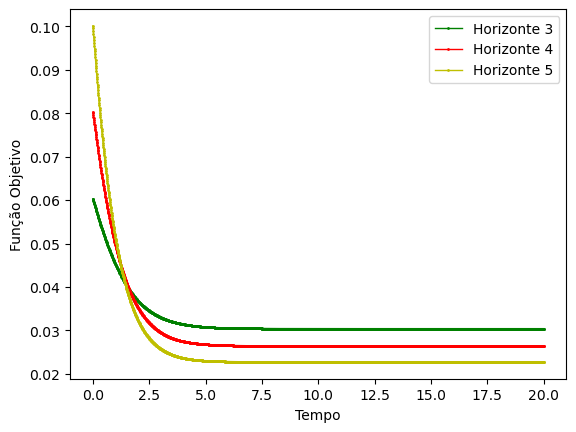

In [11]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo3[0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 3")
plt.plot(ts, abs(valoresFuncaoObjetivo4[0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 4")
plt.plot(ts, abs(valoresFuncaoObjetivo5[0]), color='y', marker='o', linewidth=1, markersize=1, label="Horizonte 5")
plt.legend(loc="upper right")
plt.savefig('valoresFuncaoObjetivo1.png', format='png')
plt.show()

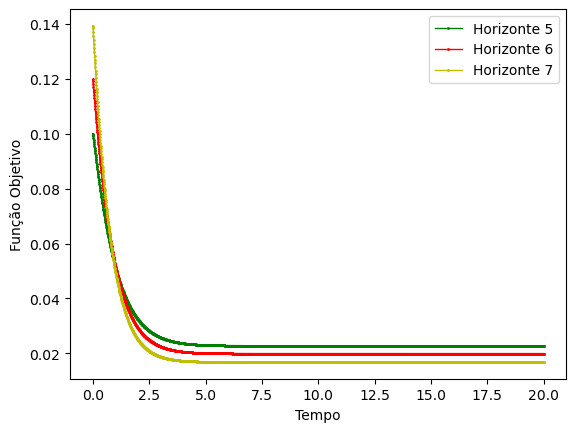

In [12]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo5[0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 5")
plt.plot(ts, abs(valoresFuncaoObjetivo6[0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 6")
plt.plot(ts, abs(valoresFuncaoObjetivo7[0]), color='y', marker='o', linewidth=1, markersize=1, label="Horizonte 7")
plt.legend(loc="upper right")
plt.savefig('valoresFuncaoObjetivo2.png', format='png')
plt.show()

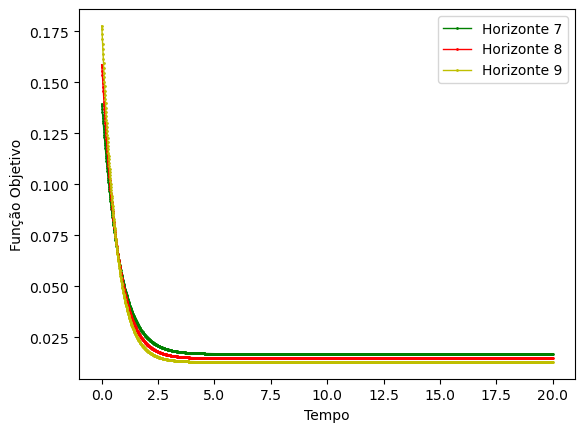

In [13]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo7[0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 7")
plt.plot(ts, abs(valoresFuncaoObjetivo8[0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 8")
plt.plot(ts, abs(valoresFuncaoObjetivo9[0]), color='y', marker='o', linewidth=1, markersize=1, label="Horizonte 9")
plt.legend(loc="upper right")
plt.savefig('valoresFuncaoObjetivo3.png', format='png')
plt.show()

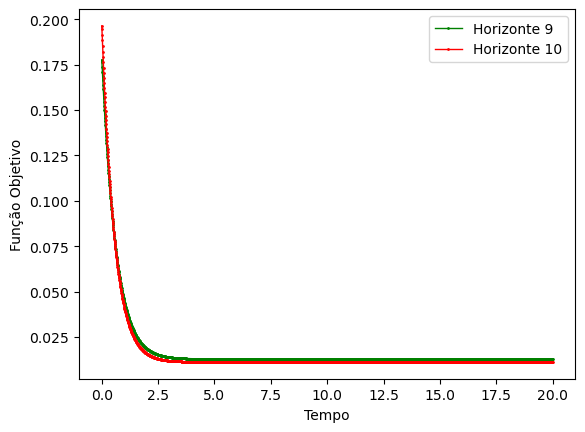

In [14]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo9[0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 9")
plt.plot(ts, abs(valoresFuncaoObjetivo10[0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 10")
plt.legend(loc="upper right")
plt.savefig('valoresFuncaoObjetivo4.png', format='png')
plt.show()

### Avaliação das componentes

Um grande problemas dos métodos de minimização está concentrado no cálculo numérico. O cálculo númerico se trata de um processo de aproximação de forma que quanto pior é a manipulação das variáveis, pior ficará a aproximação. Nesse sistema se torna perceptível a melhoria do ajuste através da desafagem do ajuste.

Conforme o livro, introdução à computação clássica e quântica de Thomas Wong (2022), a defasagem apresentada por um sistema quântico não tem significado físico se for a mesma para todo o sistema, ou seja, todas as componentes devem ter a mesma diferença de fases. Para realizar essa avaliação, se faz necessário propor uma diferença entre a curva original e o destino, tanto na parte real quanto imaginária, além de realizar a diferença entre essas partes.

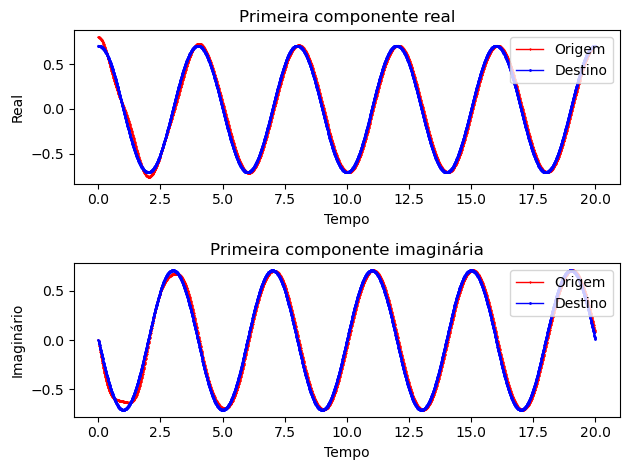

In [15]:
tempo = np.linspace(0, 20, 2000)

realObjetivoPrimeiraComponente = [elemento.real for elemento in valoresOnda3[0]] 
imaginarioObjetivoPrimeiraComponente = [elemento.imag for elemento in valoresOnda3[0]] 

realObjetivoSegundaComponente = [elemento.real for elemento in valoresOnda3[1]] 
imaginarioObjetivoSegundaComponente = [elemento.imag for elemento in valoresOnda3[1]] 

evolucaoDestino = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    evolucaoDestino[0][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
    evolucaoDestino[1][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100))

realDestinoPrimeiraComponente = [elemento.real for elemento in evolucaoDestino[0]] 
imaginarioDestinoPrimeiraComponente = [elemento.imag for elemento in evolucaoDestino[0]] 

realDestinoSegundaComponente = [elemento.real for elemento in evolucaoDestino[1]] 
imaginarioDestinoSegundaComponente = [elemento.imag for elemento in evolucaoDestino[1]] 

defasagem3 = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    defasagem3[0][i] = ((abs(valoresOnda3[0][i]) - abs(evolucaoDestino[0][i])))
    defasagem3[1][i] = ((abs(valoresOnda3[1][i]) - abs(evolucaoDestino[1][i])))

# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

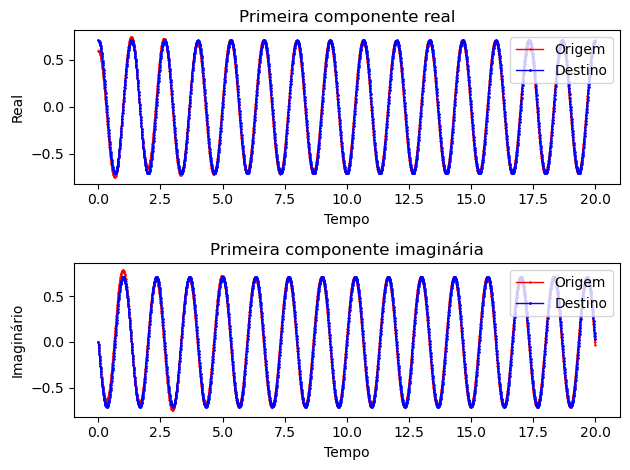

In [16]:
# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

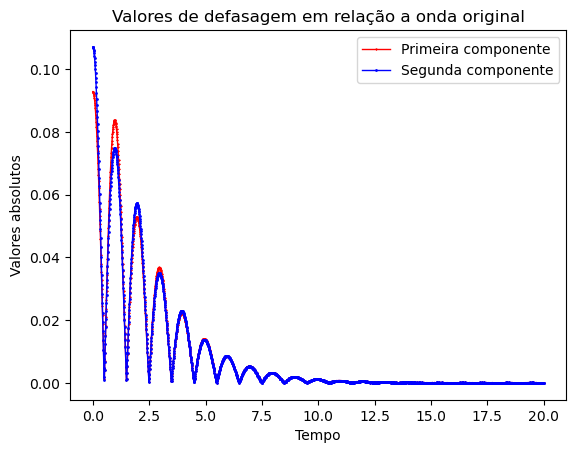

In [17]:
plt.ylabel('Valores absolutos') 
plt.xlabel('Tempo') 
plt.title('Valores de defasagem em relação a onda original')
plt.plot(ts, abs(defasagem3[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(defasagem3[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.legend(loc='upper right')

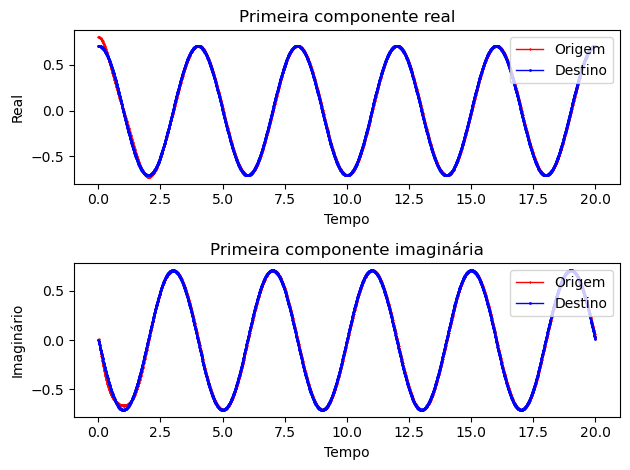

In [18]:
tempo = np.linspace(0, 20, 2000)

realObjetivoPrimeiraComponente = [elemento.real for elemento in valoresOnda10[0]] 
imaginarioObjetivoPrimeiraComponente = [elemento.imag for elemento in valoresOnda10[0]] 

realObjetivoSegundaComponente = [elemento.real for elemento in valoresOnda10[1]] 
imaginarioObjetivoSegundaComponente = [elemento.imag for elemento in valoresOnda10[1]] 

evolucaoDestino = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    evolucaoDestino[0][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
    evolucaoDestino[1][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100))

realDestinoPrimeiraComponente = [elemento.real for elemento in evolucaoDestino[0]] 
imaginarioDestinoPrimeiraComponente = [elemento.imag for elemento in evolucaoDestino[0]] 

realDestinoSegundaComponente = [elemento.real for elemento in evolucaoDestino[1]] 
imaginarioDestinoSegundaComponente = [elemento.imag for elemento in evolucaoDestino[1]] 

defasagem10 = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    defasagem10[0][i] = ((abs(valoresOnda10[0][i]) - abs(evolucaoDestino[0][i])))
    defasagem10[1][i] = ((abs(valoresOnda10[1][i]) - abs(evolucaoDestino[1][i])))

# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

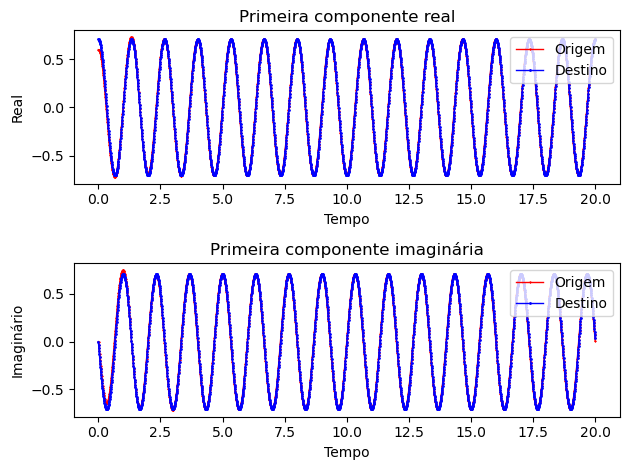

In [19]:
# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

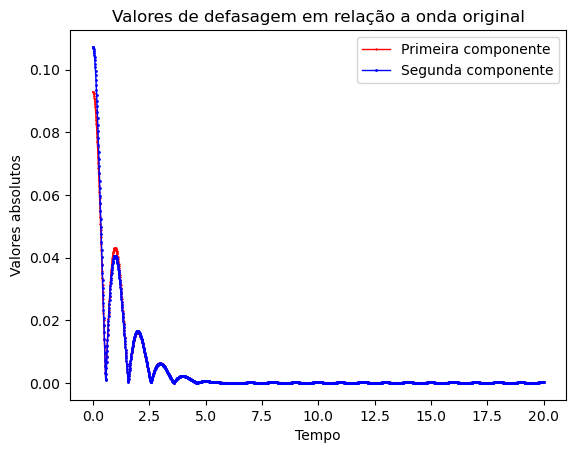

In [20]:
plt.ylabel('Valores absolutos') 
plt.xlabel('Tempo') 
plt.title('Valores de defasagem em relação a onda original')
plt.plot(ts, abs(defasagem10[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(defasagem10[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.legend(loc='upper right')

### Avaliação das constantes



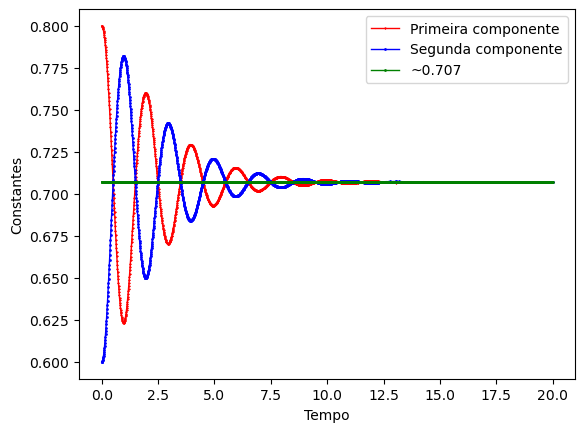

In [21]:
ts = np.linspace(0, 20, 2000) # Tempo em x 
const = []
for i in range(0, 2000):
    const.append(1/np.sqrt(2))

# Plotagem
plt.ylabel('Constantes') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(constantes3[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(constantes3[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.plot(ts, const, color='g', marker='o',  linewidth=1, markersize=1, label="~0.707")
plt.legend(loc="upper right")
plt.show()

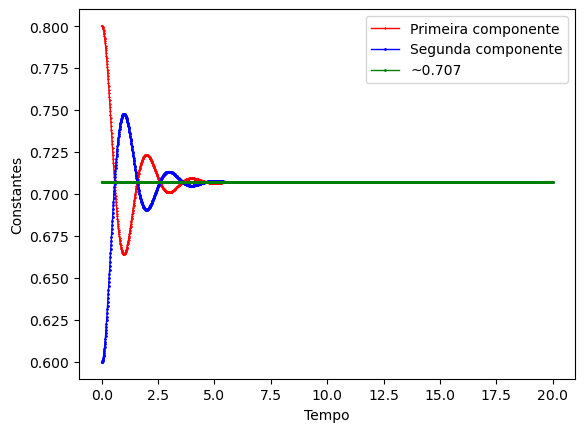

In [22]:
ts = np.linspace(0, 20, 2000) # Tempo em x 
const = []
for i in range(0, 2000):
    const.append(1/np.sqrt(2))

# Plotagem
plt.ylabel('Constantes') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(constantes10[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(constantes10[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.plot(ts, const, color='g', marker='o',  linewidth=1, markersize=1, label="~0.707")
plt.legend(loc="upper right")
plt.show()

### Gráficos - Avaliação da densidade de probabilidade para encontrar uma partícula no ponto x

Conforme descrito durante os capítulos 1, 2 e 3 do livro Mecânica Quântica por David Griffths, a estatística é um dos principais pontos para o entendimento da mecânica quântica, dessa forma é interessante entender qual é a probabilidade de uma partícula estar em um determinado lugar em um certo tempo e para tal se define:$$\int |\Psi(x,t)|^{2}dx = 1$$ Ainda nessa perspectiva, foi definido que o resultado da equação de Schrödinger pode ser definido a partir da escolha do potêncial V(x,t) e ainda que os enumeros resultados podem formar outros por meio de uma combinação linear de forma que o conjunto do quadrado das constantes que o formam, em sua soma resultam em 1. Isso define a probabilidade de um estado. Para este estudo considerou-se dois estados: $$0.80\psi_0(x,t)+0.60\psi_1(x,t)$$ de forma que para o primeiro estado a probabilidade é de 64% enquanto para o segundo é de 36%.

Se torna claro que a probabilidade total deve ser 1 e definindo o produto interno como $\int |\Psi(x,t)|^{2}dx = <\Psi | \Psi> = 1 = \sum_n |c_n|²$ podemos verificar se o ajuste da pesquisa está correto avaliando as constantes que são alteradas conforme o tempo de acordo com o gráfico apresentado acima.

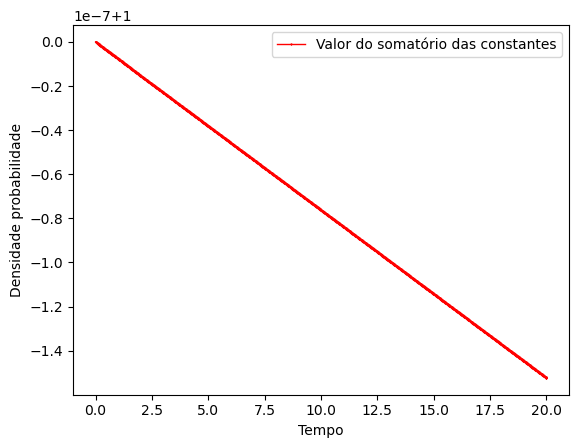

In [23]:
# Plotagem

dp = []
for i in range(0, 2000):
    dp.append((abs(constantes10[0][i])**2+abs(constantes10[1][i])**2))
    
plt.ylabel('Densidade probabilidade') 
plt.xlabel('Tempo') 
plt.plot(ts, dp, color='r', marker='*', linewidth=1, markersize=1, label="Valor do somatório das constantes")
plt.legend(loc="upper right")
plt.savefig('dp.png', format='png')
plt.show()